In [1]:
!pip install rdkit

In [2]:
!pip install rdkit-pypi
!pip install matplotlib

In [3]:
!pip install torch

In [4]:
!pip install torch_geometric

In [5]:
!pip install torchvision

In [6]:
!pip install pytorch-lightning

In [7]:
!pip install deepchem

In [8]:
!pip install pytorch-lightning

In [9]:
# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdchem
import torch
from torch_geometric.data import Data


In [10]:
import os
import csv
import glob
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data

In [11]:
from typing import List, Tuple
import numpy as np

from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol
from deepchem.feat.graph_data import GraphData
from deepchem.feat.base_classes import MolecularFeaturizer
from deepchem.utils.molecule_feature_utils import one_hot_encode
from deepchem.utils.molecule_feature_utils import get_atom_type_one_hot
from deepchem.utils.molecule_feature_utils import construct_hydrogen_bonding_info
from deepchem.utils.molecule_feature_utils import get_atom_hydrogen_bonding_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_hybridization_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_total_num_Hs_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_is_in_aromatic_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_chirality_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_formal_charge
from deepchem.utils.molecule_feature_utils import get_atom_partial_charge
from deepchem.utils.molecule_feature_utils import get_atom_total_degree_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_type_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_in_same_ring_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_conjugated_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_stereo_one_hot

In [12]:
# from deepchem.utils.molecule_feature_utils import get_atom_formal_charge_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_implicit_valence_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_explicit_valence_one_hot
# from deepchem.utils.rdkit_utils import compute_all_pairs_shortest_path
# from deepchem.utils.rdkit_utils import compute_pairwise_ring_info

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
DEFAULT_ATOM_TYPE_SET = [
    "C",
    "N",
    "O",
    "F",
    "P",
    "S",
    "Cl",
    "Br",
    "I",
]
DEFAULT_HYBRIDIZATION_SET = ["SP", "SP2", "SP3"]
DEFAULT_TOTAL_NUM_Hs_SET = [0, 1, 2, 3, 4]
DEFAULT_FORMAL_CHARGE_SET = [-2, -1, 0, 1, 2]
DEFAULT_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5]
DEFAULT_RING_SIZE_SET = [3, 4, 5, 6, 7, 8]
DEFAULT_BOND_TYPE_SET = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]
DEFAULT_BOND_STEREO_SET = ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"]
DEFAULT_GRAPH_DISTANCE_SET = [1, 2, 3, 4, 5, 6, 7]
DEFAULT_ATOM_IMPLICIT_VALENCE_SET = [0, 1, 2, 3, 4, 5, 6]
DEFAULT_ATOM_EXPLICIT_VALENCE_SET = [1, 2, 3, 4, 5, 6]

USER_ATOM_TYPE_SET  = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
       'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag',
       'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
       'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb']
USER_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
USER_HYBRIDIZATION_SET = ["SP", "SP2", "SP3", 'SP3D','SP3D2']

In [15]:
def one_hot_encode(value, allowed_values, include_unknown_set=False):
    """Create a one-hot encoded vector based on allowed values."""
    if include_unknown_set and value not in allowed_values:
        value = allowed_values[-1]

    return [1.0 if v == value else 0.0 for v in allowed_values]


In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
from torch_geometric.data import Data

class MolGraphConvFeaturizer:
    def __init__(self, use_edges=True, use_chirality=True, use_partial_charge=True):
        self.use_edges = use_edges
        self.use_chirality = use_chirality
        self.use_partial_charge = use_partial_charge

    def featurize(self, smiles):
        # Convert SMILES to RDKit Mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Compute Gasteiger charges if necessary
        if self.use_partial_charge:
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                return None  # Unable to compute charges for this molecule

        # Get atom features
        atom_features = np.array([self._get_atom_features(atom) for atom in mol.GetAtoms()])

        # Get bond features and indices
        if self.use_edges:
            edge_indices, edge_features = self._get_bond_features(mol)
        else:
            edge_indices, edge_features = None, None

        # Create a graph data object
        graph = Data(x=torch.tensor(atom_features, dtype=torch.float),
                     edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices is not None else None,
                     edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)

        return graph

    def _get_atom_features(self, atom):
        # One-hot encoding of atom type
        atom_type = one_hot_encode(atom.GetSymbol(), USER_ATOM_TYPE_SET, include_unknown_set=True)

        # Formal charge of the atom
        formal_charge = get_atom_formal_charge(atom)

        # One-hot encoding of the atom's hybridization
        hybridization = get_atom_hybridization_one_hot(atom, USER_HYBRIDIZATION_SET, include_unknown_set=True)

        # Aromaticity of the atom
        aromatic = get_atom_is_in_aromatic_one_hot(atom)

        # One-hot encoding of the atom's degree
        degree = get_atom_total_degree_one_hot(atom, USER_TOTAL_DEGREE_SET, include_unknown_set=True)

        # One-hot encoding of the total number of hydrogens connected to the atom
        total_num_Hs = get_atom_total_num_Hs_one_hot(atom, DEFAULT_TOTAL_NUM_Hs_SET, include_unknown_set=True)

        # Concatenating all the features
        atom_feat = np.concatenate([
            atom_type, formal_charge, hybridization, aromatic, degree, total_num_Hs
        ])

        if self.use_chirality:
            chirality = get_atom_chirality_one_hot(atom)
            atom_feat = np.concatenate([atom_feat, chirality])

        if self.use_partial_charge:
            partial_charge = get_atom_partial_charge(atom)
            atom_feat = np.concatenate([atom_feat, partial_charge])

        return atom_feat

    def _get_bond_features(self, mol):
        # Initialize lists for source and destination atoms of each bond
        src, dest, bond_features = [], [], []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            src += [start, end]
            dest += [end, start]

            # Extract bond features and duplicate for both bond directions
            bond_feat = self._extract_bond_features(bond)
            bond_features += [bond_feat, bond_feat]

        edge_indices = [src, dest]
        #print("edge_indices : ",edge_indices)
        #print("bond_features : ",bond_features)
        return edge_indices, bond_features
        
    def _extract_bond_features(self, bond):
        """
        Extract bond features from a RDKit bond object.
        """

        # One-hot encoding of bond type
        bond_type = one_hot_encode(bond.GetBondTypeAsDouble(), [1.0, 1.5, 2.0, 3.0], include_unknown_set=True)

        # Whether the bond is in the same ring
        same_ring = [1.0] if bond.IsInRing() else [0.0]

        # Whether the bond is conjugated
        conjugated = [1.0] if bond.GetIsConjugated() else [0.0]

        # One-hot encoding of bond stereo configuration
        stereo = one_hot_encode(bond.GetStereo(), [Chem.rdchem.BondStereo.STEREONONE, 
                                                   Chem.rdchem.BondStereo.STEREOANY, 
                                                   Chem.rdchem.BondStereo.STEREOZ, 
                                                   Chem.rdchem.BondStereo.STEREOE], 
                                include_unknown_set=True)

        # Concatenate all bond features
        bond_feat = np.concatenate([bond_type, same_ring, conjugated, stereo])

        return bond_feat        


In [17]:
# Example usage
#featurizer = MolGraphConvFeaturizer()
#graph = featurizer.featurize('CCO')  # Example SMILES string
#print(type(graph))
#print((graph))

In [18]:
## Assuming graphs[0] is a torch_geometric.data.Data object from your graphs list

## Print node features
#print("Len of graph:", len(graph))
#print("Node Features:")
#for i, node_feature in enumerate(graph.x):
#    print(f"Node {i}: {node_feature}")

## Print edge pairs and edge features
#print("\nEdge Pairs and Features:")
#for i, edge in enumerate(graph.edge_index.t()):
#    src, dest = edge[0].item(), edge[1].item()
#    edge_feature = graph.edge_attr[i]
#    print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


In [19]:
#graph.is_directed()

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def visualize_graph(data):
    # Create a networkx graph
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(data.num_nodes):
        G.add_node(i)

    # Add edges to the graph
    edge_index = data.edge_index.t().cpu().numpy()
    for edge in edge_index:
        src, dest = edge[0], edge[1]
        G.add_edge(src, dest)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()
#visualize_graph(graph)

In [21]:
# Load the data 
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-41-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test.txt", header=None, names=['SMILES'])
smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test50k.txt", header=None, names=['SMILES'])
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test25k.txt", header=None, names=['SMILES'])


In [22]:
smiles_df.head(5)

SMILES
0             CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1         CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2                 COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3                       OCCn1cc(CNc2cccc3c2CCCC3)nn1
4  CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...

In [23]:
# Define a function to convert a SMILES string to a graph data object
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom.GetAtomicNum())

    # Get bond features and adjacency information
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [(start, end), (end, start)]
        edge_feature = [bond.GetBondTypeAsDouble()]
        edge_features += [edge_feature, edge_feature]  # add twice for both directions

    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create a graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


In [24]:
def read_smiles_df_check(smiles_df):
    graphs = []
    invalid_indices = []
    for idx, smiles in enumerate(smiles_df['SMILES']):
        graph = smiles_to_graph(smiles)
        if graph:
            graphs.append(graph)
        else:
            print("Invalid graph :", idx,smiles)
            invalid_indices.append(idx)
    return graphs, invalid_indices

graphs, invalid_indices = read_smiles_df_check(smiles_df)
print(f"Number of valid graphs: {len(graphs)}")
print(f"Indices of invalid SMILES: {invalid_indices}")

Number of valid graphs: 50001
Indices of invalid SMILES: []


In [25]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 50001


In [26]:
# Initialize the featurizer
featurizer = MolGraphConvFeaturizer(use_edges=True, use_chirality=True, use_partial_charge=True)

# Featurize SMILES strings and track invalid entries
graphs = []
invalid_indices = []
for idx, smiles in enumerate(smiles_df['SMILES']):
    print(idx)
    graph = featurizer.featurize(smiles)
    graphs.append(graph)    
    
#    try:
#        graph = featurizer.featurize(smiles)
#        graphs.append(graph)
#    except Exception as e:
#        print(f"Invalid SMILES at index {idx}: {smiles} (Error: {e})")
#        invalid_indices.append(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


C:\Users\Malli\AppData\Local\Temp\ipykernel_14164\3029635957.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)


48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310


1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147


3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812


5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475


7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201


8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773
8774
8775
8776
8777
8778
8779
8780
8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800
8801
8802
8803
8804
8805
8806
8807
8808
8809
8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823
8824
8825
8826
8827
8828
8829
8830
8831
8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842


10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
1049

11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
11855
11856
11857
11858
11859
11860
11861
11862
11863
11864
11865
11866
11867
11868
11869
11870
11871
11872
11873
11874
11875
11876
11877
11878
11879
11880
11881
11882
11883
11884
11885
11886
11887
11888
11889
11890
11891
11892
11893
11894
11895
11896
11897
11898
11899
11900
11901
11902
11903
11904
11905
11906
11907
11908
11909
11910
11911
11912
11913
11914
11915
11916
11917
11918
11919
11920
11921
11922
11923
11924
11925
11926
11927
11928
11929
11930
11931
1193

13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297
13298
13299
13300
13301
13302
13303
13304
13305
13306
13307
13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353
13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
1336

14655
14656
14657
14658
14659
14660
14661
14662
14663
14664
14665
14666
14667
14668
14669
14670
14671
14672
14673
14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687
14688
14689
14690
14691
14692
14693
14694
14695
14696
14697
14698
14699
14700
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733
14734
14735
14736
14737
14738
14739
14740
14741
14742
14743
14744
14745
14746
14747
14748
14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
14760
14761
14762
14763
14764
14765
14766
14767
14768
14769
14770
14771
14772
14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783
14784
14785
14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798
14799
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
14812
14813
14814
14815
14816
14817
14818
14819
14820
1482

16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185
16186
16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197
16198
16199
16200
16201
16202
16203
16204
16205
16206
16207
16208
16209
16210
16211
16212
16213
16214
16215
16216
16217
16218
16219
16220
16221
16222
16223
1622

17462
17463
17464
17465
17466
17467
17468
17469
17470
17471
17472
17473
17474
17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
17491
17492
17493
17494
17495
17496
17497
17498
17499
17500
17501
17502
17503
17504
17505
17506
17507
17508
17509
17510
17511
17512
17513
17514
17515
17516
17517
17518
17519
17520
17521
17522
17523
17524
17525
17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537
17538
17539
17540
17541
17542
17543
17544
17545
17546
17547
17548
17549
17550
17551
17552
17553
17554
17555
17556
17557
17558
17559
17560
17561
17562
17563
17564
17565
17566
17567
17568
17569
17570
17571
17572
17573
17574
17575
17576
17577
17578
17579
17580
17581
17582
17583
17584
17585
17586
17587
17588
17589
17590
17591
17592
17593
17594
17595
17596
17597
17598
17599
17600
17601
17602
17603
17604
17605
17606
17607
17608
17609
17610
17611
17612
17613
17614
17615
17616
17617
17618
17619
17620
17621
17622
17623
17624
17625
17626
17627
1762

18911
18912
18913
18914
18915
18916
18917
18918
18919
18920
18921
18922
18923
18924
18925
18926
18927
18928
18929
18930
18931
18932
18933
18934
18935
18936
18937
18938
18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
18999
19000
19001
19002
19003
19004
19005
19006
19007
19008
19009
19010
19011
19012
19013
19014
19015
19016
19017
19018
19019
19020
19021
19022
19023
19024
19025
19026
19027
19028
19029
19030
19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070
19071
19072
19073
19074
19075
19076
1907

20347
20348
20349
20350
20351
20352
20353
20354
20355
20356
20357
20358
20359
20360
20361
20362
20363
20364
20365
20366
20367
20368
20369
20370
20371
20372
20373
20374
20375
20376
20377
20378
20379
20380
20381
20382
20383
20384
20385
20386
20387
20388
20389
20390
20391
20392
20393
20394
20395
20396
20397
20398
20399
20400
20401
20402
20403
20404
20405
20406
20407
20408
20409
20410
20411
20412
20413
20414
20415
20416
20417
20418
20419
20420
20421
20422
20423
20424
20425
20426
20427
20428
20429
20430
20431
20432
20433
20434
20435
20436
20437
20438
20439
20440
20441
20442
20443
20444
20445
20446
20447
20448
20449
20450
20451
20452
20453
20454
20455
20456
20457
20458
20459
20460
20461
20462
20463
20464
20465
20466
20467
20468
20469
20470
20471
20472
20473
20474
20475
20476
20477
20478
20479
20480
20481
20482
20483
20484
20485
20486
20487
20488
20489
20490
20491
20492
20493
20494
20495
20496
20497
20498
20499
20500
20501
20502
20503
20504
20505
20506
20507
20508
20509
20510
20511
20512
2051

21786
21787
21788
21789
21790
21791
21792
21793
21794
21795
21796
21797
21798
21799
21800
21801
21802
21803
21804
21805
21806
21807
21808
21809
21810
21811
21812
21813
21814
21815
21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827
21828
21829
21830
21831
21832
21833
21834
21835
21836
21837
21838
21839
21840
21841
21842
21843
21844
21845
21846
21847
21848
21849
21850
21851
21852
21853
21854
21855
21856
21857
21858
21859
21860
21861
21862
21863
21864
21865
21866
21867
21868
21869
21870
21871
21872
21873
21874
21875
21876
21877
21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889
21890
21891
21892
21893
21894
21895
21896
21897
21898
21899
21900
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913
21914
21915
21916
21917
21918
21919
21920
21921
21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934
21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947
21948
21949
21950
21951
2195

23204
23205
23206
23207
23208
23209
23210
23211
23212
23213
23214
23215
23216
23217
23218
23219
23220
23221
23222
23223
23224
23225
23226
23227
23228
23229
23230
23231
23232
23233
23234
23235
23236
23237
23238
23239
23240
23241
23242
23243
23244
23245
23246
23247
23248
23249
23250
23251
23252
23253
23254
23255
23256
23257
23258
23259
23260
23261
23262
23263
23264
23265
23266
23267
23268
23269
23270
23271
23272
23273
23274
23275
23276
23277
23278
23279
23280
23281
23282
23283
23284
23285
23286
23287
23288
23289
23290
23291
23292
23293
23294
23295
23296
23297
23298
23299
23300
23301
23302
23303
23304
23305
23306
23307
23308
23309
23310
23311
23312
23313
23314
23315
23316
23317
23318
23319
23320
23321
23322
23323
23324
23325
23326
23327
23328
23329
23330
23331
23332
23333
23334
23335
23336
23337
23338
23339
23340
23341
23342
23343
23344
23345
23346
23347
23348
23349
23350
23351
23352
23353
23354
23355
23356
23357
23358
23359
23360
23361
23362
23363
23364
23365
23366
23367
23368
23369
2337

24571
24572
24573
24574
24575
24576
24577
24578
24579
24580
24581
24582
24583
24584
24585
24586
24587
24588
24589
24590
24591
24592
24593
24594
24595
24596
24597
24598
24599
24600
24601
24602
24603
24604
24605
24606
24607
24608
24609
24610
24611
24612
24613
24614
24615
24616
24617
24618
24619
24620
24621
24622
24623
24624
24625
24626
24627
24628
24629
24630
24631
24632
24633
24634
24635
24636
24637
24638
24639
24640
24641
24642
24643
24644
24645
24646
24647
24648
24649
24650
24651
24652
24653
24654
24655
24656
24657
24658
24659
24660
24661
24662
24663
24664
24665
24666
24667
24668
24669
24670
24671
24672
24673
24674
24675
24676
24677
24678
24679
24680
24681
24682
24683
24684
24685
24686
24687
24688
24689
24690
24691
24692
24693
24694
24695
24696
24697
24698
24699
24700
24701
24702
24703
24704
24705
24706
24707
24708
24709
24710
24711
24712
24713
24714
24715
24716
24717
24718
24719
24720
24721
24722
24723
24724
24725
24726
24727
24728
24729
24730
24731
24732
24733
24734
24735
24736
2473

25943
25944
25945
25946
25947
25948
25949
25950
25951
25952
25953
25954
25955
25956
25957
25958
25959
25960
25961
25962
25963
25964
25965
25966
25967
25968
25969
25970
25971
25972
25973
25974
25975
25976
25977
25978
25979
25980
25981
25982
25983
25984
25985
25986
25987
25988
25989
25990
25991
25992
25993
25994
25995
25996
25997
25998
25999
26000
26001
26002
26003
26004
26005
26006
26007
26008
26009
26010
26011
26012
26013
26014
26015
26016
26017
26018
26019
26020
26021
26022
26023
26024
26025
26026
26027
26028
26029
26030
26031
26032
26033
26034
26035
26036
26037
26038
26039
26040
26041
26042
26043
26044
26045
26046
26047
26048
26049
26050
26051
26052
26053
26054
26055
26056
26057
26058
26059
26060
26061
26062
26063
26064
26065
26066
26067
26068
26069
26070
26071
26072
26073
26074
26075
26076
26077
26078
26079
26080
26081
26082
26083
26084
26085
26086
26087
26088
26089
26090
26091
26092
26093
26094
26095
26096
26097
26098
26099
26100
26101
26102
26103
26104
26105
26106
26107
26108
2610

27335
27336
27337
27338
27339
27340
27341
27342
27343
27344
27345
27346
27347
27348
27349
27350
27351
27352
27353
27354
27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365
27366
27367
27368
27369
27370
27371
27372
27373
27374
27375
27376
27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388
27389
27390
27391
27392
27393
27394
27395
27396
27397
27398
27399
27400
27401
27402
27403
27404
27405
27406
27407
27408
27409
27410
27411
27412
27413
27414
27415
27416
27417
27418
27419
27420
27421
27422
27423
27424
27425
27426
27427
27428
27429
27430
27431
27432
27433
27434
27435
27436
27437
27438
27439
27440
27441
27442
27443
27444
27445
27446
27447
27448
27449
27450
27451
27452
27453
27454
27455
27456
27457
27458
27459
27460
27461
27462
27463
27464
27465
27466
27467
27468
27469
27470
27471
27472
27473
27474
27475
27476
27477
27478
27479
27480
27481
27482
27483
27484
27485
27486
27487
27488
27489
27490
27491
27492
27493
27494
27495
27496
27497
27498
27499
27500
2750

28726
28727
28728
28729
28730
28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743
28744
28745
28746
28747
28748
28749
28750
28751
28752
28753
28754
28755
28756
28757
28758
28759
28760
28761
28762
28763
28764
28765
28766
28767
28768
28769
28770
28771
28772
28773
28774
28775
28776
28777
28778
28779
28780
28781
28782
28783
28784
28785
28786
28787
28788
28789
28790
28791
28792
28793
28794
28795
28796
28797
28798
28799
28800
28801
28802
28803
28804
28805
28806
28807
28808
28809
28810
28811
28812
28813
28814
28815
28816
28817
28818
28819
28820
28821
28822
28823
28824
28825
28826
28827
28828
28829
28830
28831
28832
28833
28834
28835
28836
28837
28838
28839
28840
28841
28842
28843
28844
28845
28846
28847
28848
28849
28850
28851
28852
28853
28854
28855
28856
28857
28858
28859
28860
28861
28862
28863
28864
28865
28866
28867
28868
28869
28870
28871
28872
28873
28874
28875
28876
28877
28878
28879
28880
28881
28882
28883
28884
28885
28886
28887
28888
28889
28890
28891
2889

30164
30165
30166
30167
30168
30169
30170
30171
30172
30173
30174
30175
30176
30177
30178
30179
30180
30181
30182
30183
30184
30185
30186
30187
30188
30189
30190
30191
30192
30193
30194
30195
30196
30197
30198
30199
30200
30201
30202
30203
30204
30205
30206
30207
30208
30209
30210
30211
30212
30213
30214
30215
30216
30217
30218
30219
30220
30221
30222
30223
30224
30225
30226
30227
30228
30229
30230
30231
30232
30233
30234
30235
30236
30237
30238
30239
30240
30241
30242
30243
30244
30245
30246
30247
30248
30249
30250
30251
30252
30253
30254
30255
30256
30257
30258
30259
30260
30261
30262
30263
30264
30265
30266
30267
30268
30269
30270
30271
30272
30273
30274
30275
30276
30277
30278
30279
30280
30281
30282
30283
30284
30285
30286
30287
30288
30289
30290
30291
30292
30293
30294
30295
30296
30297
30298
30299
30300
30301
30302
30303
30304
30305
30306
30307
30308
30309
30310
30311
30312
30313
30314
30315
30316
30317
30318
30319
30320
30321
30322
30323
30324
30325
30326
30327
30328
30329
3033

31594
31595
31596
31597
31598
31599
31600
31601
31602
31603
31604
31605
31606
31607
31608
31609
31610
31611
31612
31613
31614
31615
31616
31617
31618
31619
31620
31621
31622
31623
31624
31625
31626
31627
31628
31629
31630
31631
31632
31633
31634
31635
31636
31637
31638
31639
31640
31641
31642
31643
31644
31645
31646
31647
31648
31649
31650
31651
31652
31653
31654
31655
31656
31657
31658
31659
31660
31661
31662
31663
31664
31665
31666
31667
31668
31669
31670
31671
31672
31673
31674
31675
31676
31677
31678
31679
31680
31681
31682
31683
31684
31685
31686
31687
31688
31689
31690
31691
31692
31693
31694
31695
31696
31697
31698
31699
31700
31701
31702
31703
31704
31705
31706
31707
31708
31709
31710
31711
31712
31713
31714
31715
31716
31717
31718
31719
31720
31721
31722
31723
31724
31725
31726
31727
31728
31729
31730
31731
31732
31733
31734
31735
31736
31737
31738
31739
31740
31741
31742
31743
31744
31745
31746
31747
31748
31749
31750
31751
31752
31753
31754
31755
31756
31757
31758
31759
3176

33006
33007
33008
33009
33010
33011
33012
33013
33014
33015
33016
33017
33018
33019
33020
33021
33022
33023
33024
33025
33026
33027
33028
33029
33030
33031
33032
33033
33034
33035
33036
33037
33038
33039
33040
33041
33042
33043
33044
33045
33046
33047
33048
33049
33050
33051
33052
33053
33054
33055
33056
33057
33058
33059
33060
33061
33062
33063
33064
33065
33066
33067
33068
33069
33070
33071
33072
33073
33074
33075
33076
33077
33078
33079
33080
33081
33082
33083
33084
33085
33086
33087
33088
33089
33090
33091
33092
33093
33094
33095
33096
33097
33098
33099
33100
33101
33102
33103
33104
33105
33106
33107
33108
33109
33110
33111
33112
33113
33114
33115
33116
33117
33118
33119
33120
33121
33122
33123
33124
33125
33126
33127
33128
33129
33130
33131
33132
33133
33134
33135
33136
33137
33138
33139
33140
33141
33142
33143
33144
33145
33146
33147
33148
33149
33150
33151
33152
33153
33154
33155
33156
33157
33158
33159
33160
33161
33162
33163
33164
33165
33166
33167
33168
33169
33170
33171
3317

34426
34427
34428
34429
34430
34431
34432
34433
34434
34435
34436
34437
34438
34439
34440
34441
34442
34443
34444
34445
34446
34447
34448
34449
34450
34451
34452
34453
34454
34455
34456
34457
34458
34459
34460
34461
34462
34463
34464
34465
34466
34467
34468
34469
34470
34471
34472
34473
34474
34475
34476
34477
34478
34479
34480
34481
34482
34483
34484
34485
34486
34487
34488
34489
34490
34491
34492
34493
34494
34495
34496
34497
34498
34499
34500
34501
34502
34503
34504
34505
34506
34507
34508
34509
34510
34511
34512
34513
34514
34515
34516
34517
34518
34519
34520
34521
34522
34523
34524
34525
34526
34527
34528
34529
34530
34531
34532
34533
34534
34535
34536
34537
34538
34539
34540
34541
34542
34543
34544
34545
34546
34547
34548
34549
34550
34551
34552
34553
34554
34555
34556
34557
34558
34559
34560
34561
34562
34563
34564
34565
34566
34567
34568
34569
34570
34571
34572
34573
34574
34575
34576
34577
34578
34579
34580
34581
34582
34583
34584
34585
34586
34587
34588
34589
34590
34591
3459

35831
35832
35833
35834
35835
35836
35837
35838
35839
35840
35841
35842
35843
35844
35845
35846
35847
35848
35849
35850
35851
35852
35853
35854
35855
35856
35857
35858
35859
35860
35861
35862
35863
35864
35865
35866
35867
35868
35869
35870
35871
35872
35873
35874
35875
35876
35877
35878
35879
35880
35881
35882
35883
35884
35885
35886
35887
35888
35889
35890
35891
35892
35893
35894
35895
35896
35897
35898
35899
35900
35901
35902
35903
35904
35905
35906
35907
35908
35909
35910
35911
35912
35913
35914
35915
35916
35917
35918
35919
35920
35921
35922
35923
35924
35925
35926
35927
35928
35929
35930
35931
35932
35933
35934
35935
35936
35937
35938
35939
35940
35941
35942
35943
35944
35945
35946
35947
35948
35949
35950
35951
35952
35953
35954
35955
35956
35957
35958
35959
35960
35961
35962
35963
35964
35965
35966
35967
35968
35969
35970
35971
35972
35973
35974
35975
35976
35977
35978
35979
35980
35981
35982
35983
35984
35985
35986
35987
35988
35989
35990
35991
35992
35993
35994
35995
35996
3599

37297
37298
37299
37300
37301
37302
37303
37304
37305
37306
37307
37308
37309
37310
37311
37312
37313
37314
37315
37316
37317
37318
37319
37320
37321
37322
37323
37324
37325
37326
37327
37328
37329
37330
37331
37332
37333
37334
37335
37336
37337
37338
37339
37340
37341
37342
37343
37344
37345
37346
37347
37348
37349
37350
37351
37352
37353
37354
37355
37356
37357
37358
37359
37360
37361
37362
37363
37364
37365
37366
37367
37368
37369
37370
37371
37372
37373
37374
37375
37376
37377
37378
37379
37380
37381
37382
37383
37384
37385
37386
37387
37388
37389
37390
37391
37392
37393
37394
37395
37396
37397
37398
37399
37400
37401
37402
37403
37404
37405
37406
37407
37408
37409
37410
37411
37412
37413
37414
37415
37416
37417
37418
37419
37420
37421
37422
37423
37424
37425
37426
37427
37428
37429
37430
37431
37432
37433
37434
37435
37436
37437
37438
37439
37440
37441
37442
37443
37444
37445
37446
37447
37448
37449
37450
37451
37452
37453
37454
37455
37456
37457
37458
37459
37460
37461
37462
3746

38714
38715
38716
38717
38718
38719
38720
38721
38722
38723
38724
38725
38726
38727
38728
38729
38730
38731
38732
38733
38734
38735
38736
38737
38738
38739
38740
38741
38742
38743
38744
38745
38746
38747
38748
38749
38750
38751
38752
38753
38754
38755
38756
38757
38758
38759
38760
38761
38762
38763
38764
38765
38766
38767
38768
38769
38770
38771
38772
38773
38774
38775
38776
38777
38778
38779
38780
38781
38782
38783
38784
38785
38786
38787
38788
38789
38790
38791
38792
38793
38794
38795
38796
38797
38798
38799
38800
38801
38802
38803
38804
38805
38806
38807
38808
38809
38810
38811
38812
38813
38814
38815
38816
38817
38818
38819
38820
38821
38822
38823
38824
38825
38826
38827
38828
38829
38830
38831
38832
38833
38834
38835
38836
38837
38838
38839
38840
38841
38842
38843
38844
38845
38846
38847
38848
38849
38850
38851
38852
38853
38854
38855
38856
38857
38858
38859
38860
38861
38862
38863
38864
38865
38866
38867
38868
38869
38870
38871
38872
38873
38874
38875
38876
38877
38878
38879
3888

40156
40157
40158
40159
40160
40161
40162
40163
40164
40165
40166
40167
40168
40169
40170
40171
40172
40173
40174
40175
40176
40177
40178
40179
40180
40181
40182
40183
40184
40185
40186
40187
40188
40189
40190
40191
40192
40193
40194
40195
40196
40197
40198
40199
40200
40201
40202
40203
40204
40205
40206
40207
40208
40209
40210
40211
40212
40213
40214
40215
40216
40217
40218
40219
40220
40221
40222
40223
40224
40225
40226
40227
40228
40229
40230
40231
40232
40233
40234
40235
40236
40237
40238
40239
40240
40241
40242
40243
40244
40245
40246
40247
40248
40249
40250
40251
40252
40253
40254
40255
40256
40257
40258
40259
40260
40261
40262
40263
40264
40265
40266
40267
40268
40269
40270
40271
40272
40273
40274
40275
40276
40277
40278
40279
40280
40281
40282
40283
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
40298
40299
40300
40301
40302
40303
40304
40305
40306
40307
40308
40309
40310
40311
40312
40313
40314
40315
40316
40317
40318
40319
40320
40321
4032

41613
41614
41615
41616
41617
41618
41619
41620
41621
41622
41623
41624
41625
41626
41627
41628
41629
41630
41631
41632
41633
41634
41635
41636
41637
41638
41639
41640
41641
41642
41643
41644
41645
41646
41647
41648
41649
41650
41651
41652
41653
41654
41655
41656
41657
41658
41659
41660
41661
41662
41663
41664
41665
41666
41667
41668
41669
41670
41671
41672
41673
41674
41675
41676
41677
41678
41679
41680
41681
41682
41683
41684
41685
41686
41687
41688
41689
41690
41691
41692
41693
41694
41695
41696
41697
41698
41699
41700
41701
41702
41703
41704
41705
41706
41707
41708
41709
41710
41711
41712
41713
41714
41715
41716
41717
41718
41719
41720
41721
41722
41723
41724
41725
41726
41727
41728
41729
41730
41731
41732
41733
41734
41735
41736
41737
41738
41739
41740
41741
41742
41743
41744
41745
41746
41747
41748
41749
41750
41751
41752
41753
41754
41755
41756
41757
41758
41759
41760
41761
41762
41763
41764
41765
41766
41767
41768
41769
41770
41771
41772
41773
41774
41775
41776
41777
41778
4177

43038
43039
43040
43041
43042
43043
43044
43045
43046
43047
43048
43049
43050
43051
43052
43053
43054
43055
43056
43057
43058
43059
43060
43061
43062
43063
43064
43065
43066
43067
43068
43069
43070
43071
43072
43073
43074
43075
43076
43077
43078
43079
43080
43081
43082
43083
43084
43085
43086
43087
43088
43089
43090
43091
43092
43093
43094
43095
43096
43097
43098
43099
43100
43101
43102
43103
43104
43105
43106
43107
43108
43109
43110
43111
43112
43113
43114
43115
43116
43117
43118
43119
43120
43121
43122
43123
43124
43125
43126
43127
43128
43129
43130
43131
43132
43133
43134
43135
43136
43137
43138
43139
43140
43141
43142
43143
43144
43145
43146
43147
43148
43149
43150
43151
43152
43153
43154
43155
43156
43157
43158
43159
43160
43161
43162
43163
43164
43165
43166
43167
43168
43169
43170
43171
43172
43173
43174
43175
43176
43177
43178
43179
43180
43181
43182
43183
43184
43185
43186
43187
43188
43189
43190
43191
43192
43193
43194
43195
43196
43197
43198
43199
43200
43201
43202
43203
4320

44443
44444
44445
44446
44447
44448
44449
44450
44451
44452
44453
44454
44455
44456
44457
44458
44459
44460
44461
44462
44463
44464
44465
44466
44467
44468
44469
44470
44471
44472
44473
44474
44475
44476
44477
44478
44479
44480
44481
44482
44483
44484
44485
44486
44487
44488
44489
44490
44491
44492
44493
44494
44495
44496
44497
44498
44499
44500
44501
44502
44503
44504
44505
44506
44507
44508
44509
44510
44511
44512
44513
44514
44515
44516
44517
44518
44519
44520
44521
44522
44523
44524
44525
44526
44527
44528
44529
44530
44531
44532
44533
44534
44535
44536
44537
44538
44539
44540
44541
44542
44543
44544
44545
44546
44547
44548
44549
44550
44551
44552
44553
44554
44555
44556
44557
44558
44559
44560
44561
44562
44563
44564
44565
44566
44567
44568
44569
44570
44571
44572
44573
44574
44575
44576
44577
44578
44579
44580
44581
44582
44583
44584
44585
44586
44587
44588
44589
44590
44591
44592
44593
44594
44595
44596
44597
44598
44599
44600
44601
44602
44603
44604
44605
44606
44607
44608
4460

45849
45850
45851
45852
45853
45854
45855
45856
45857
45858
45859
45860
45861
45862
45863
45864
45865
45866
45867
45868
45869
45870
45871
45872
45873
45874
45875
45876
45877
45878
45879
45880
45881
45882
45883
45884
45885
45886
45887
45888
45889
45890
45891
45892
45893
45894
45895
45896
45897
45898
45899
45900
45901
45902
45903
45904
45905
45906
45907
45908
45909
45910
45911
45912
45913
45914
45915
45916
45917
45918
45919
45920
45921
45922
45923
45924
45925
45926
45927
45928
45929
45930
45931
45932
45933
45934
45935
45936
45937
45938
45939
45940
45941
45942
45943
45944
45945
45946
45947
45948
45949
45950
45951
45952
45953
45954
45955
45956
45957
45958
45959
45960
45961
45962
45963
45964
45965
45966
45967
45968
45969
45970
45971
45972
45973
45974
45975
45976
45977
45978
45979
45980
45981
45982
45983
45984
45985
45986
45987
45988
45989
45990
45991
45992
45993
45994
45995
45996
45997
45998
45999
46000
46001
46002
46003
46004
46005
46006
46007
46008
46009
46010
46011
46012
46013
46014
4601

47278
47279
47280
47281
47282
47283
47284
47285
47286
47287
47288
47289
47290
47291
47292
47293
47294
47295
47296
47297
47298
47299
47300
47301
47302
47303
47304
47305
47306
47307
47308
47309
47310
47311
47312
47313
47314
47315
47316
47317
47318
47319
47320
47321
47322
47323
47324
47325
47326
47327
47328
47329
47330
47331
47332
47333
47334
47335
47336
47337
47338
47339
47340
47341
47342
47343
47344
47345
47346
47347
47348
47349
47350
47351
47352
47353
47354
47355
47356
47357
47358
47359
47360
47361
47362
47363
47364
47365
47366
47367
47368
47369
47370
47371
47372
47373
47374
47375
47376
47377
47378
47379
47380
47381
47382
47383
47384
47385
47386
47387
47388
47389
47390
47391
47392
47393
47394
47395
47396
47397
47398
47399
47400
47401
47402
47403
47404
47405
47406
47407
47408
47409
47410
47411
47412
47413
47414
47415
47416
47417
47418
47419
47420
47421
47422
47423
47424
47425
47426
47427
47428
47429
47430
47431
47432
47433
47434
47435
47436
47437
47438
47439
47440
47441
47442
47443
4744

48693
48694
48695
48696
48697
48698
48699
48700
48701
48702
48703
48704
48705
48706
48707
48708
48709
48710
48711
48712
48713
48714
48715
48716
48717
48718
48719
48720
48721
48722
48723
48724
48725
48726
48727
48728
48729
48730
48731
48732
48733
48734
48735
48736
48737
48738
48739
48740
48741
48742
48743
48744
48745
48746
48747
48748
48749
48750
48751
48752
48753
48754
48755
48756
48757
48758
48759
48760
48761
48762
48763
48764
48765
48766
48767
48768
48769
48770
48771
48772
48773
48774
48775
48776
48777
48778
48779
48780
48781
48782
48783
48784
48785
48786
48787
48788
48789
48790
48791
48792
48793
48794
48795
48796
48797
48798
48799
48800
48801
48802
48803
48804
48805
48806
48807
48808
48809
48810
48811
48812
48813
48814
48815
48816
48817
48818
48819
48820
48821
48822
48823
48824
48825
48826
48827
48828
48829
48830
48831
48832
48833
48834
48835
48836
48837
48838
48839
48840
48841
48842
48843
48844
48845
48846
48847
48848
48849
48850
48851
48852
48853
48854
48855
48856
48857
48858
4885

In [27]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))

Length of smiles_df: 50001


In [28]:
print(len(graphs))
print(type(graphs[1]))
print((graphs[1]))

50001
<class 'torch_geometric.data.data.Data'>
Data(x=[17, 72], edge_index=[36, 2], edge_attr=[36, 10])


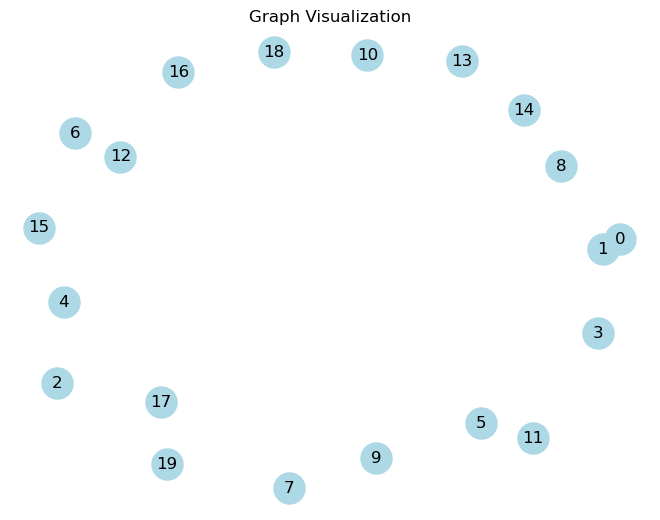

In [29]:
visualize_graph(graphs[3])

In [30]:
!pip install torch_geometric

In [31]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx

In [32]:
import torch

# Example graph object from the user's data
graph = graphs[3]

# Extracting edge indices
edge_indices = graph.edge_index.t().tolist()

# Extracting node features (assuming each node has a feature vector)
node_features = graph.x.tolist()

# The nodes can be represented as a list of indices from 0 to the number of nodes - 1
node_indices = list(range(len(node_features)))

# Displaying the node indices and edge indices
#node_indices, edge_indices
#print(node_features)

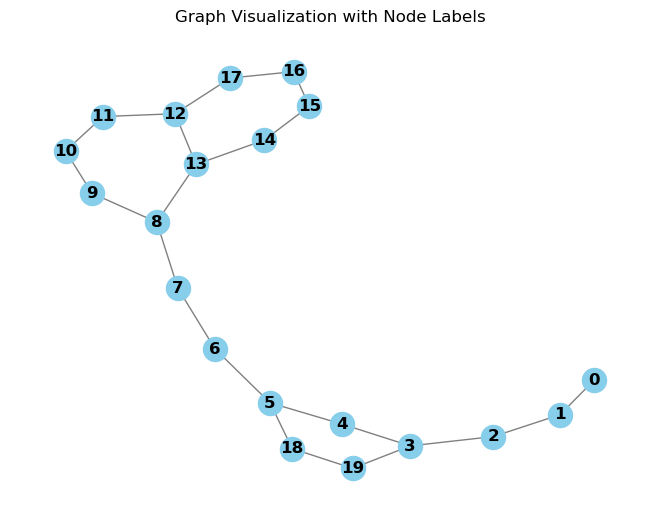

In [33]:
import networkx as nx
import torch_geometric

edge_index = torch.tensor(edge_indices, dtype=torch.long)
x = torch.tensor(node_indices, dtype=torch.float)

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Draw the graph with node labels
pos = nx.spring_layout(g)  # Compute layout
nx.draw(g, pos, with_labels=True, font_weight='bold', node_color='skyblue', edge_color='gray')
plt.title("Graph Visualization with Node Labels")
plt.show()

In [34]:
# Print the edge indices
print(graphs[3].edge_index.t().tolist())

[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 5, 18, 18, 19, 19, 3, 13, 8, 17, 12], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 5, 19, 18, 3, 19, 8, 13, 12, 17]]


In [35]:
# graphs[0] is a torch_geometric.data.Data object from your graphs list
graph = graphs[3]

# Print node features
print("Len of graph:", len(graph))
print("Node Features:")
print(len(graph.x))
#for i, node_feature in enumerate(graph.x):
    #print(f"Node {i}: {node_feature}")

# Print edge pairs and edge features
print("\nEdge Pairs and Features:")
print(graph.edge_index.t())
for i, edge in enumerate(graph.edge_index.t()):
    src, dest = edge[0].item(), edge[1].item()
    edge_feature = graph.edge_attr[i]
    #print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


Len of graph: 3
Node Features:
20

Edge Pairs and Features:
tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,  5, 18,
         18, 19, 19,  3, 13,  8, 17, 12],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18,  5,
         19, 18,  3, 19,  8, 13, 12, 17]])


In [36]:
# Extracting edge list and edge features from the provided graph
graph = graphs[5]  

# Extracting edge index
edge_index = graph.edge_index.t()

# Preparing the edge list
edge_list = []
for i in range(edge_index.shape[1]):
    edge = edge_index[:, i]
    edge_list.append((edge[0].item(), edge[1].item()))

edge_list


[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (7, 9),
 (9, 7),
 (9, 10),
 (10, 9),
 (1, 11),
 (11, 1),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (18, 17),
 (18, 19),
 (19, 18),
 (19, 20),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 21),
 (22, 23),
 (23, 22),
 (14, 24),
 (24, 14),
 (24, 25),
 (25, 24),
 (10, 4),
 (4, 10),
 (25, 11),
 (11, 25),
 (23, 15),
 (15, 23),
 (23, 18),
 (18, 23)]

In [37]:
import torch
from torch_geometric.data import Data

# Assuming graph_data is your list of graph objects
# graph_data[0] is the first graph object

# Select the first graph object
first_graph = graphs[3]

# Convert node features to a floating-point type if they aren't already
node_features_float = first_graph.x.float()

# Inspect node features
print("Node features (x) of the first graph:")
print(node_features_float)
print("Shape of node features:", node_features_float.shape)

# Inspect edge features
print("\nEdge features (edge_attr) of the first graph:")
print(first_graph.edge_attr)
print("Shape of edge features:", first_graph.edge_attr.shape)

# Inspect edge index (connectivity)
print("\nEdge index (edge_index) of the first graph:")
print(first_graph.edge_index)
print("Shape of edge index:", first_graph.edge_index.shape)

# Calculate min and max for each node feature of the first graph
min_values, max_values = node_features_float.min(dim=0)[0], node_features_float.max(dim=0)[0]

print("\nMinimum values of node features:", min_values)
print("Maximum values of node features:", max_values)

# Calculate the standard deviation for each node feature
std_deviation = node_features_float.std(dim=0)
print("\nStandard deviation of node features:", std_deviation)


Node features (x) of the first graph:
tensor([[ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000, -0.3944],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0628],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0658],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0275],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1335],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0670]])
Shape of node features: torch.Size([20, 72])

Edge features (edge_attr) of the first graph:
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1.,

In [38]:
smiles_df['SMILES'][3]

'OCCn1cc(CNc2cccc3c2CCCC3)nn1'

In [39]:
mol = Chem.MolFromSmiles(smiles_df['SMILES'][3])
AllChem.ComputeGasteigerCharges(mol)

In [40]:
edge_indices = []
for bond in mol.GetBonds():
    start_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    edge_indices.append((start_idx, end_idx))
    edge_indices.append((end_idx, start_idx))  # Add the reverse direction


In [41]:
edge_indices

[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (5, 18),
 (18, 5),
 (18, 19),
 (19, 18),
 (19, 3),
 (3, 19),
 (13, 8),
 (8, 13),
 (17, 12),
 (12, 17)]

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear

In [43]:
print((graphs[0]))
print((smiles_df.head(1)))

Data(x=[25, 72], edge_index=[54, 2], edge_attr=[54, 10])
                                   SMILES
0  CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1


In [44]:
print(len(graphs))
print(len(smiles_df))

50001
50001


In [45]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 50001


In [46]:
smiles_df.head(5)

SMILES
0             CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1         CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2                 COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3                       OCCn1cc(CNc2cccc3c2CCCC3)nn1
4  CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...

In [47]:
print(type(graphs[3]))

<class 'torch_geometric.data.data.Data'>


In [48]:
# Unsupervised Graph Generative Adversarial Netwrok

In [49]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

In [50]:
def generate_random_edge_index(num_nodes):
    # Example implementation to generate a random edge_index
    # Here we create a fully connected graph for simplicity
    edge_index = torch.combinations(torch.arange(num_nodes), r=2)
    return torch.cat([edge_index, edge_index.flip([1])], dim=0).t()  # Making it undirected

In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Data, Batch
from torch_geometric.utils import erdos_renyi_graph

def generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes):
    """
    Generate random noise for a batch of graphs with variable number of nodes and edges,
    but fixed node feature and edge feature dimensions.

    Args:
    - batch_size (int): Number of random graphs to generate.
    - node_feature_dim (int): Number of features for each node.
    - edge_feature_dim (int): Number of features for each edge.
    - max_num_nodes (int): Maximum number of nodes a graph can have.

    Returns:
    - A list of Data objects containing random noise for node and edge features.
    """
    random_graphs = []

    for _ in range(batch_size):
        # Randomly determine the number of nodes for this graph
        num_nodes = torch.randint(low=1, high=max_num_nodes, size=(1,)).item()

        # Generate random node features
        x = torch.randn(num_nodes, node_feature_dim)

        # Generate a random graph structure (edge_index)
        edge_index = erdos_renyi_graph(num_nodes, edge_prob=0.5)  # p is the probability of an edge

        # Generate random edge features (if needed)
        num_edges = edge_index.size(1)
        edge_attr = torch.randn(num_edges, edge_feature_dim) if edge_feature_dim > 0 else None

        # Create a Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        random_graphs.append(data)

    #return random_graphs
    return Batch.from_data_list(random_graphs)





In [52]:
# Example usage
batch_size = 32
node_feature_dim = 72  # Number of node features
edge_feature_dim = 10  # Number of edge features, adjust as needed
max_num_nodes = 50    # Maximum number of nodes in a graph

random_noise_graphs = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)

In [53]:
random_noise_graphs 

DataBatch(x=[890, 72], edge_index=[2, 15374], edge_attr=[15374, 10], batch=[890], ptr=[33])

In [54]:
# Generator Model
class Generator_v1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index gen",type(x), type(edge_index))
        #print("x, edge_index gen",x.size(), edge_index.size())
        #print("x, edge_index gen",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("Generator x layer 1:",x)
        x = torch.sigmoid(self.layer2(x, edge_index))
        #print("Generator x  layer 2:",x)
        return x

In [55]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)    

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.layer1(x, edge_index))
        x = torch.sigmoid(self.layer2(x, edge_index))

        # Generate fake edge_index (simple example, should be improved)
        fake_edge_index = self.generate_fake_edge_index(x.size(0))
        return x, fake_edge_index

    def generate_fake_edge_index(self, num_nodes):
        # Implement logic to generate a plausible edge_index for fake graphs
        # Placeholder logic: create a simple linear chain graph
        edge_index = torch.tensor([[i, i+1] for i in range(num_nodes - 1)], dtype=torch.long).t()
        return edge_index


In [56]:
# Discriminator Model  
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        #print("In discriminator")
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("self.layer1",input_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        #print("self.layer2",hidden_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index1",type(x), type(edge_index))
        #print("x, edge_index2",x.size(), edge_index.size())
        #print("x, edge_index3",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("x 2",x)
        x = torch.sigmoid(self.layer2(x))
        #print("x 3",x)
        return x

In [57]:
# Model Initialization
generator_input_dim = 72
generator_hidden_dim = 256
#generator_hidden_dim = 128
generator_output_dim = 72

discriminator_input_dim = 72
discriminator_hidden_dim = 256
#discriminator_hidden_dim = 128

In [58]:
generator = Generator(generator_input_dim, generator_hidden_dim, generator_output_dim)
discriminator = Discriminator(discriminator_input_dim, discriminator_hidden_dim)

In [59]:
import torch.optim as optim
from torch_geometric.data import DataLoader
#from torch_geometric.loader import DataLoader

from torch.utils.data import Dataset

# Sample data loader (replace with your dataset)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=['x', 'edge_index'])
data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=[])



# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Loss function
adversarial_loss = torch.nn.BCELoss()

C:\Users\Malli\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [60]:
# Function to calculate discriminator accuracy
def calculate_discriminator_accuracy(discriminator, real_data, fake_data):
    real_predictions = discriminator(real_data).round()
    fake_predictions = discriminator(fake_data).round()
    correct_predictions = (real_predictions == 1).sum() + (fake_predictions == 0).sum()
    total_predictions = real_predictions.numel() + fake_predictions.numel()
    accuracy = 100 * correct_predictions.float() / total_predictions
    return accuracy

In [61]:
print((data_loader))

In [62]:
print((graphs[3].x).shape)
print((graphs[3].edge_index).shape)

torch.Size([20, 72])
torch.Size([44, 2])


In [63]:
print((graphs[0].x).shape)
print((graphs[0].edge_index).shape)

torch.Size([25, 72])
torch.Size([54, 2])


In [64]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch

def custom_graph_data_loader(graph_dataset, batch_size):
    """
    Custom data loader for graph data.
    
    Args:
    - graph_dataset (list of Data): The dataset containing graph Data objects.
    - batch_size (int): The size of each batch.

    Yields:
    - Batched Data object containing a batch of graphs.
    """

    def batch_graphs(graphs):
        """
        Manually batches a list of graphs into a single Batch object.
        """
        batched_edge_index = []
        batched_x = []
        batched_batch = []

        current_node_idx = 0
        for i, graph in enumerate(graphs):
            # Offset the node indices by the current_node_idx and add them to the batched edge index.
            #edge_index_offset = graph.edge_index + current_node_idx
            #batched_edge_index.append(edge_index_offset)
            
            # Offset only the node indices in the edge_index tensor.
            edge_index_offset = graph.edge_index.clone()  # Make a copy to avoid modifying the original graph
            edge_index_offset[0, :] += current_node_idx  # Offset source node indices
            edge_index_offset[1, :] += current_node_idx  # Offset target node indices
            #batched_edge_index.append(edge_index_offset)            
            
            #Tring edge_index
            #batched_edge_index.append(graph.edge_index)
            batched_edge_index.append(graph.edge_index + current_node_idx)

            # Add the current graph's node features to the batched node features.
            batched_x.append(graph.x)

            # Add the graph index to the batch vector for all nodes of this graph.
            batched_batch.append(torch.full((graph.x.size(0),), i, dtype=torch.long))

            # Update the current_node_idx for the next graph.
            current_node_idx += graph.x.size(0)

        # Concatenate all the lists to create tensors.       
        
        batched_edge_index = torch.cat(batched_edge_index, dim=0)
        batched_x = torch.cat(batched_x, dim=0)
        batched_batch = torch.cat(batched_batch, dim=0)
        

        # Create a new Data object to hold the batched graph.
        batched_data = Data(x=batched_x, edge_index=batched_edge_index)
        batched_data.batch = batched_batch

        return batched_data

    # Shuffle dataset at the beginning of each epoch
    indices = torch.randperm(len(graph_dataset))
    
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]
        batch_graphs_list = [graph_dataset[i] for i in batch_indices]
        batch = batch_graphs(batch_graphs_list)
        yield batch


In [65]:
import matplotlib.pyplot as plt
import torch

def calculate_accuracy(preds, labels):
    predicted_labels = preds.round()  # Convert probabilities to 0/1
    correct = (predicted_labels == labels).float()  # Convert into float for division 
    accuracy = correct.sum() / len(correct)
    return accuracy

In [66]:
# Create a NetworkX graph from node features and edge index
def create_networkx_graph(node_features, edge_index):
    G = nx.Graph()
    for i, feature in enumerate(node_features):
        G.add_node(i, feature=feature)
    for source, target in edge_index.t().numpy():
        G.add_edge(source, target)
    return G

In [67]:
num_epochs = 50
batch_size = 32

# Lists to store metrics
epochs = []
d_losses = []
g_losses = []
real_accuracy_list =[]
fake_accuracy_list=[]
d_accuracies = []

early_stop_threshold = 1.0  # Define your threshold near 1
loss_smoothing = 0.1  # Smoothing factor for loss, to avoid immediate stopping due to fluctuations
fake_loss_history = []  # To store recent history of fake losses
smoothed_fake_loss = float('inf')  # Initialize smoothed_fake_loss
prev_d_loss = None  # Initialize previous discriminator loss



# Initialize storage for real and fake graph
graph_data_per_epoch = {}

# To define how often to take snapshots 
snapshot_interval = 5  

for epoch in range(num_epochs):
    print("epoch", epoch)
    early_stop_triggered = False  # Flag to indicate if early stopping was triggered
    graph_data_per_epoch[epoch] = []
    
    for batch in custom_graph_data_loader(graphs, batch_size):
        # Generate fake data
        random_noise_graphs_batch = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)

        # Ensure the real edge_index is correctly shaped [2, num_edges]
        if batch.edge_index.size(0) != 2:
            batch.edge_index = batch.edge_index.t()  # Transpose if necessary        
        
        # Create fake data batch with both x and edge_index
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)

        # Labels for real and fake data (for each node)
        real_labels = torch.ones(batch.x.size(0), 1)
        fake_labels = torch.zeros(fake_data.x.size(0), 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(batch), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_data), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        # Recompute fake data and perform forward pass through discriminator
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)
        updated_real_labels = torch.ones(fake_data.x.size(0), 1)
        g_loss = adversarial_loss(discriminator(fake_data), updated_real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        # Calculate discriminator accuracy
        real_accuracy = calculate_accuracy(discriminator(batch).detach(), real_labels)
        print("real_accuracy",real_accuracy)
        fake_accuracy = calculate_accuracy(discriminator(fake_data).detach(), fake_labels)
        print("fake_accuracy",fake_accuracy)
        d_accuracy = (real_accuracy + fake_accuracy) / 2

        # Store metrics
        d_losses.append(d_loss.item())
        print("d_loss.item()",d_loss.item())
        g_losses.append(g_loss.item())
        print("g_loss.item()",g_loss.item())
        d_accuracies.append(d_accuracy.item())
        real_accuracy_list.append(real_accuracy.item())
        fake_accuracy_list.append(fake_accuracy.item())

        # Get current discriminator loss
        current_g_loss = g_loss.item()    
        print("current_g_loss",current_g_loss)
        
        # Calculate and store fake loss
        current_fake_loss = fake_loss.item()
        fake_loss_history.append(current_fake_loss)             
        
        # Update previous discriminator loss
        prev_g_loss = current_g_loss        
        

    
        ##################################################        
        # Post-Processing for Visualization and Analysis
        # Early stopping check
        if epoch > 20:  # Ensure some minimum number of iterations

            if current_g_loss == 0.0 and prev_g_loss == 0.0:
                print(f"Early stopping triggered at epoch {epoch}")
                early_stop_triggered = True

                # Store both real and fake graph data for each batch
                graph_data = {
                    "real_x": batch.x.clone().detach(),
                    "real_edge_index": batch.edge_index.clone().detach(),
                    "fake_x": fake_x.clone().detach(),
                    "fake_edge_index": fake_edge_index.clone().detach()
                }
                graph_data_per_epoch[epoch].append(graph_data)                

                break

        # Update previous discriminator loss
        prev_g_loss = current_g_loss

        # At the end of the last epoch, store the fake graphs
        if epoch == num_epochs - 1:
            # Store both real and fake graph data for each batch
            graph_data = {
                "real_x": batch.x.clone().detach(),
                "real_edge_index": batch.edge_index.clone().detach(),
                "fake_x": fake_x.clone().detach(),
                "fake_edge_index": fake_edge_index.clone().detach()
            }
            graph_data_per_epoch[epoch].append(graph_data)

        # Update previous discriminator loss
        prev_g_loss = current_g_loss 

        if early_stop_triggered:
            break  # Break the outer loop if early stopping was triggered
        
        
        ##################################################        
        

        epochs.append(epoch)


epoch 0
real_accuracy tensor(0.5581)
fake_accuracy tensor(1.)
d_loss.item() 1.294039011001587
g_loss.item() 0.8896763324737549
current_g_loss 0.8896763324737549
real_accuracy tensor(0.6155)
fake_accuracy tensor(1.)
d_loss.item() 1.226759910583496
g_loss.item() 0.9744769334793091
current_g_loss 0.9744769334793091
real_accuracy tensor(0.7113)
fake_accuracy tensor(1.)
d_loss.item() 1.16502046585083
g_loss.item() 1.0621681213378906
current_g_loss 1.0621681213378906
real_accuracy tensor(0.7158)
fake_accuracy tensor(1.)
d_loss.item() 1.1116353273391724
g_loss.item() 1.1514137983322144
current_g_loss 1.1514137983322144
real_accuracy tensor(0.8086)
fake_accuracy tensor(1.)
d_loss.item() 1.059695839881897
g_loss.item() 1.2420109510421753
current_g_loss 1.2420109510421753
real_accuracy tensor(0.7532)
fake_accuracy tensor(1.)
d_loss.item() 1.017832636833191
g_loss.item() 1.3372550010681152
current_g_loss 1.3372550010681152
real_accuracy tensor(0.8993)
fake_accuracy tensor(1.)
d_loss.item() 0.9707

real_accuracy tensor(1.)
fake_accuracy tensor(0.8986)
d_loss.item() 0.43491581082344055
g_loss.item() 2.0007998943328857
current_g_loss 2.0007998943328857
real_accuracy tensor(1.)
fake_accuracy tensor(0.7721)
d_loss.item() 0.6198891401290894
g_loss.item() 1.5471357107162476
current_g_loss 1.5471357107162476
real_accuracy tensor(1.)
fake_accuracy tensor(0.8714)
d_loss.item() 0.478973925113678
g_loss.item() 1.8788783550262451
current_g_loss 1.8788783550262451
real_accuracy tensor(1.)
fake_accuracy tensor(0.9238)
d_loss.item() 0.47159796953201294
g_loss.item() 1.7817851305007935
current_g_loss 1.7817851305007935
real_accuracy tensor(1.)
fake_accuracy tensor(0.9093)
d_loss.item() 0.5156776905059814
g_loss.item() 1.691767692565918
current_g_loss 1.691767692565918
real_accuracy tensor(1.)
fake_accuracy tensor(0.9111)
d_loss.item() 0.4509052634239197
g_loss.item() 1.9607937335968018
current_g_loss 1.9607937335968018
real_accuracy tensor(1.)
fake_accuracy tensor(0.8343)
d_loss.item() 0.5627605

real_accuracy tensor(0.9351)
fake_accuracy tensor(1.)
d_loss.item() 0.7640396356582642
g_loss.item() 1.2536969184875488
current_g_loss 1.2536969184875488
real_accuracy tensor(0.9436)
fake_accuracy tensor(1.)
d_loss.item() 0.7558008432388306
g_loss.item() 1.274522066116333
current_g_loss 1.274522066116333
real_accuracy tensor(0.9298)
fake_accuracy tensor(1.)
d_loss.item() 0.7687829732894897
g_loss.item() 1.2341383695602417
current_g_loss 1.2341383695602417
real_accuracy tensor(0.9235)
fake_accuracy tensor(1.)
d_loss.item() 0.787368893623352
g_loss.item() 1.2486850023269653
current_g_loss 1.2486850023269653
real_accuracy tensor(0.8861)
fake_accuracy tensor(1.)
d_loss.item() 0.833134114742279
g_loss.item() 1.2119382619857788
current_g_loss 1.2119382619857788
real_accuracy tensor(0.8876)
fake_accuracy tensor(1.)
d_loss.item() 0.8435999155044556
g_loss.item() 1.1893057823181152
current_g_loss 1.1893057823181152
real_accuracy tensor(0.8776)
fake_accuracy tensor(1.)
d_loss.item() 0.8286137580

real_accuracy tensor(0.9179)
fake_accuracy tensor(1.)
d_loss.item() 0.5514358282089233
g_loss.item() 1.5325047969818115
current_g_loss 1.5325047969818115
real_accuracy tensor(0.8832)
fake_accuracy tensor(1.)
d_loss.item() 0.6004191637039185
g_loss.item() 1.539023518562317
current_g_loss 1.539023518562317
real_accuracy tensor(0.9022)
fake_accuracy tensor(1.)
d_loss.item() 0.6110973358154297
g_loss.item() 1.4960473775863647
current_g_loss 1.4960473775863647
real_accuracy tensor(0.8784)
fake_accuracy tensor(1.)
d_loss.item() 0.5965330600738525
g_loss.item() 1.5406427383422852
current_g_loss 1.5406427383422852
real_accuracy tensor(0.8727)
fake_accuracy tensor(1.)
d_loss.item() 0.6194193363189697
g_loss.item() 1.4608553647994995
current_g_loss 1.4608553647994995
real_accuracy tensor(0.8773)
fake_accuracy tensor(1.)
d_loss.item() 0.6168868541717529
g_loss.item() 1.4535819292068481
current_g_loss 1.4535819292068481
real_accuracy tensor(0.8323)
fake_accuracy tensor(1.)
d_loss.item() 0.68154889

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.2498413324356079
g_loss.item() 2.2389650344848633
current_g_loss 2.2389650344848633
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.23406252264976501
g_loss.item() 2.2018585205078125
current_g_loss 2.2018585205078125
real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.2293720245361328
g_loss.item() 2.212409257888794
current_g_loss 2.212409257888794
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.22926577925682068
g_loss.item() 2.1964504718780518
current_g_loss 2.1964504718780518
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.21720528602600098
g_loss.item() 2.216965675354004
current_g_loss 2.216965675354004
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.2217268943786621
g_loss.item() 2.1780471801757812
current_g_loss 2.1780471801757812
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.21596252918243408
g_loss.it

real_accuracy tensor(0.9535)
fake_accuracy tensor(1.)
d_loss.item() 0.4500395655632019
g_loss.item() 1.6766830682754517
current_g_loss 1.6766830682754517
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.4667409062385559
g_loss.item() 1.7072502374649048
current_g_loss 1.7072502374649048
real_accuracy tensor(0.9470)
fake_accuracy tensor(1.)
d_loss.item() 0.48098957538604736
g_loss.item() 1.6496577262878418
current_g_loss 1.6496577262878418
real_accuracy tensor(0.9142)
fake_accuracy tensor(1.)
d_loss.item() 0.5005926489830017
g_loss.item() 1.6109217405319214
current_g_loss 1.6109217405319214
real_accuracy tensor(0.9334)
fake_accuracy tensor(1.)
d_loss.item() 0.5017743706703186
g_loss.item() 1.6118991374969482
current_g_loss 1.6118991374969482
real_accuracy tensor(0.9411)
fake_accuracy tensor(1.)
d_loss.item() 0.508045494556427
g_loss.item() 1.5580692291259766
current_g_loss 1.5580692291259766
real_accuracy tensor(0.9458)
fake_accuracy tensor(1.)
d_loss.item() 0.553786

real_accuracy tensor(0.9002)
fake_accuracy tensor(1.)
d_loss.item() 0.6060689091682434
g_loss.item() 1.565354347229004
current_g_loss 1.565354347229004
real_accuracy tensor(0.9065)
fake_accuracy tensor(1.)
d_loss.item() 0.5841111540794373
g_loss.item() 1.6216970682144165
current_g_loss 1.6216970682144165
real_accuracy tensor(0.9015)
fake_accuracy tensor(1.)
d_loss.item() 0.566689133644104
g_loss.item() 1.678627371788025
current_g_loss 1.678627371788025
real_accuracy tensor(0.8940)
fake_accuracy tensor(1.)
d_loss.item() 0.5407605171203613
g_loss.item() 1.730897068977356
current_g_loss 1.730897068977356
real_accuracy tensor(0.9059)
fake_accuracy tensor(1.)
d_loss.item() 0.5076755285263062
g_loss.item() 1.8187744617462158
current_g_loss 1.8187744617462158
real_accuracy tensor(0.9481)
fake_accuracy tensor(1.)
d_loss.item() 0.444627583026886
g_loss.item() 1.8399966955184937
current_g_loss 1.8399966955184937
real_accuracy tensor(0.9263)
fake_accuracy tensor(1.)
d_loss.item() 0.47438782453536

real_accuracy tensor(0.9708)
fake_accuracy tensor(1.)
d_loss.item() 0.25445497035980225
g_loss.item() 2.3830654621124268
current_g_loss 2.3830654621124268
real_accuracy tensor(0.9728)
fake_accuracy tensor(1.)
d_loss.item() 0.24421727657318115
g_loss.item() 2.3786401748657227
current_g_loss 2.3786401748657227
real_accuracy tensor(0.9829)
fake_accuracy tensor(1.)
d_loss.item() 0.22384467720985413
g_loss.item() 2.3692805767059326
current_g_loss 2.3692805767059326
real_accuracy tensor(0.9863)
fake_accuracy tensor(1.)
d_loss.item() 0.2221842110157013
g_loss.item() 2.339886426925659
current_g_loss 2.339886426925659
real_accuracy tensor(0.9832)
fake_accuracy tensor(1.)
d_loss.item() 0.22386696934700012
g_loss.item() 2.343188762664795
current_g_loss 2.343188762664795
real_accuracy tensor(0.9893)
fake_accuracy tensor(1.)
d_loss.item() 0.21391168236732483
g_loss.item() 2.349841594696045
current_g_loss 2.349841594696045
real_accuracy tensor(0.9802)
fake_accuracy tensor(1.)
d_loss.item() 0.2257609

real_accuracy tensor(0.9529)
fake_accuracy tensor(1.)
d_loss.item() 0.1792268455028534
g_loss.item() 3.316401720046997
current_g_loss 3.316401720046997
real_accuracy tensor(0.9569)
fake_accuracy tensor(1.)
d_loss.item() 0.16003172099590302
g_loss.item() 3.3540353775024414
current_g_loss 3.3540353775024414
real_accuracy tensor(0.9619)
fake_accuracy tensor(1.)
d_loss.item() 0.1544923633337021
g_loss.item() 3.339843988418579
current_g_loss 3.339843988418579
real_accuracy tensor(0.9676)
fake_accuracy tensor(1.)
d_loss.item() 0.138947531580925
g_loss.item() 3.340132474899292
current_g_loss 3.340132474899292
real_accuracy tensor(0.9636)
fake_accuracy tensor(1.)
d_loss.item() 0.15523222088813782
g_loss.item() 3.3142547607421875
current_g_loss 3.3142547607421875
real_accuracy tensor(0.9608)
fake_accuracy tensor(1.)
d_loss.item() 0.13728198409080505
g_loss.item() 3.3899874687194824
current_g_loss 3.3899874687194824
real_accuracy tensor(0.9587)
fake_accuracy tensor(1.)
d_loss.item() 0.1559992432

real_accuracy tensor(0.6365)
fake_accuracy tensor(0.9838)
d_loss.item() 1.2294299602508545
g_loss.item() 1.0679512023925781
current_g_loss 1.0679512023925781
real_accuracy tensor(0.6149)
fake_accuracy tensor(0.9975)
d_loss.item() 1.222383975982666
g_loss.item() 1.1229140758514404
current_g_loss 1.1229140758514404
real_accuracy tensor(0.6540)
fake_accuracy tensor(1.)
d_loss.item() 1.1354390382766724
g_loss.item() 1.133976936340332
current_g_loss 1.133976936340332
real_accuracy tensor(0.6587)
fake_accuracy tensor(1.)
d_loss.item() 1.0648291110992432
g_loss.item() 1.1625279188156128
current_g_loss 1.1625279188156128
real_accuracy tensor(0.5937)
fake_accuracy tensor(1.)
d_loss.item() 1.163106918334961
g_loss.item() 1.1522482633590698
current_g_loss 1.1522482633590698
real_accuracy tensor(0.5714)
fake_accuracy tensor(1.)
d_loss.item() 1.1577634811401367
g_loss.item() 1.2217135429382324
current_g_loss 1.2217135429382324
real_accuracy tensor(0.5969)
fake_accuracy tensor(1.)
d_loss.item() 1.10

real_accuracy tensor(0.9621)
fake_accuracy tensor(1.)
d_loss.item() 0.20462191104888916
g_loss.item() 2.8347179889678955
current_g_loss 2.8347179889678955
real_accuracy tensor(0.9412)
fake_accuracy tensor(1.)
d_loss.item() 0.2375372350215912
g_loss.item() 2.9157450199127197
current_g_loss 2.9157450199127197
real_accuracy tensor(0.9465)
fake_accuracy tensor(1.)
d_loss.item() 0.24137169122695923
g_loss.item() 2.9658846855163574
current_g_loss 2.9658846855163574
real_accuracy tensor(0.9764)
fake_accuracy tensor(1.)
d_loss.item() 0.17243286967277527
g_loss.item() 3.084294557571411
current_g_loss 3.084294557571411
real_accuracy tensor(0.9569)
fake_accuracy tensor(1.)
d_loss.item() 0.18959996104240417
g_loss.item() 3.14985728263855
current_g_loss 3.14985728263855
real_accuracy tensor(0.9616)
fake_accuracy tensor(1.)
d_loss.item() 0.18974539637565613
g_loss.item() 3.1711761951446533
current_g_loss 3.1711761951446533
real_accuracy tensor(0.9588)
fake_accuracy tensor(1.)
d_loss.item() 0.1729651

real_accuracy tensor(0.8534)
fake_accuracy tensor(1.)
d_loss.item() 0.44915565848350525
g_loss.item() 2.5419654846191406
current_g_loss 2.5419654846191406
real_accuracy tensor(0.8618)
fake_accuracy tensor(1.)
d_loss.item() 0.4108613133430481
g_loss.item() 2.7567625045776367
current_g_loss 2.7567625045776367
real_accuracy tensor(0.8587)
fake_accuracy tensor(1.)
d_loss.item() 0.4006448984146118
g_loss.item() 3.0082333087921143
current_g_loss 3.0082333087921143
real_accuracy tensor(0.8598)
fake_accuracy tensor(1.)
d_loss.item() 0.3622814416885376
g_loss.item() 3.2317042350769043
current_g_loss 3.2317042350769043
real_accuracy tensor(0.8547)
fake_accuracy tensor(1.)
d_loss.item() 0.3339403569698334
g_loss.item() 3.352203130722046
current_g_loss 3.352203130722046
real_accuracy tensor(0.8052)
fake_accuracy tensor(1.)
d_loss.item() 0.4997948408126831
g_loss.item() 3.410407543182373
current_g_loss 3.410407543182373
real_accuracy tensor(0.8426)
fake_accuracy tensor(1.)
d_loss.item() 0.369247019

real_accuracy tensor(0.9748)
fake_accuracy tensor(1.)
d_loss.item() 0.1475580930709839
g_loss.item() 3.746687173843384
current_g_loss 3.746687173843384
real_accuracy tensor(0.9735)
fake_accuracy tensor(1.)
d_loss.item() 0.12192417681217194
g_loss.item() 3.8809566497802734
current_g_loss 3.8809566497802734
real_accuracy tensor(0.9859)
fake_accuracy tensor(1.)
d_loss.item() 0.11425812542438507
g_loss.item() 4.008363246917725
current_g_loss 4.008363246917725
real_accuracy tensor(0.9725)
fake_accuracy tensor(1.)
d_loss.item() 0.11797761917114258
g_loss.item() 4.107741355895996
current_g_loss 4.107741355895996
real_accuracy tensor(0.9771)
fake_accuracy tensor(1.)
d_loss.item() 0.10905124992132187
g_loss.item() 4.176713466644287
current_g_loss 4.176713466644287
real_accuracy tensor(0.9698)
fake_accuracy tensor(1.)
d_loss.item() 0.11987664550542831
g_loss.item() 4.245342254638672
current_g_loss 4.245342254638672
real_accuracy tensor(0.9798)
fake_accuracy tensor(1.)
d_loss.item() 0.11114807426

real_accuracy tensor(0.9899)
fake_accuracy tensor(1.)
d_loss.item() 0.15143164992332458
g_loss.item() 3.269392251968384
current_g_loss 3.269392251968384
real_accuracy tensor(0.9839)
fake_accuracy tensor(1.)
d_loss.item() 0.15044210851192474
g_loss.item() 3.2976155281066895
current_g_loss 3.2976155281066895
real_accuracy tensor(0.9620)
fake_accuracy tensor(1.)
d_loss.item() 0.19211840629577637
g_loss.item() 3.1151511669158936
current_g_loss 3.1151511669158936
real_accuracy tensor(0.9787)
fake_accuracy tensor(1.)
d_loss.item() 0.1693016141653061
g_loss.item() 3.085214376449585
current_g_loss 3.085214376449585
real_accuracy tensor(0.9923)
fake_accuracy tensor(1.)
d_loss.item() 0.16364097595214844
g_loss.item() 2.924459457397461
current_g_loss 2.924459457397461
real_accuracy tensor(0.9951)
fake_accuracy tensor(1.)
d_loss.item() 0.15800262987613678
g_loss.item() 2.8901336193084717
current_g_loss 2.8901336193084717
real_accuracy tensor(0.9712)
fake_accuracy tensor(1.)
d_loss.item() 0.1924911

real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.22969622910022736
g_loss.item() 2.2582788467407227
current_g_loss 2.2582788467407227
real_accuracy tensor(0.9858)
fake_accuracy tensor(1.)
d_loss.item() 0.27574867010116577
g_loss.item() 2.1038100719451904
current_g_loss 2.1038100719451904
real_accuracy tensor(0.9857)
fake_accuracy tensor(1.)
d_loss.item() 0.26542162895202637
g_loss.item() 2.154940605163574
current_g_loss 2.154940605163574
real_accuracy tensor(0.9797)
fake_accuracy tensor(1.)
d_loss.item() 0.33261838555336
g_loss.item() 1.8810195922851562
current_g_loss 1.8810195922851562
real_accuracy tensor(0.9771)
fake_accuracy tensor(1.)
d_loss.item() 0.41050058603286743
g_loss.item() 1.658704400062561
current_g_loss 1.658704400062561
real_accuracy tensor(0.9556)
fake_accuracy tensor(1.)
d_loss.item() 0.43221646547317505
g_loss.item() 1.683733582496643
current_g_loss 1.683733582496643
real_accuracy tensor(0.9441)
fake_accuracy tensor(0.9938)
d_loss.item() 0.45193

real_accuracy tensor(0.9240)
fake_accuracy tensor(1.)
d_loss.item() 0.259891539812088
g_loss.item() 2.4550445079803467
current_g_loss 2.4550445079803467
real_accuracy tensor(0.9487)
fake_accuracy tensor(1.)
d_loss.item() 0.2544909715652466
g_loss.item() 2.3839142322540283
current_g_loss 2.3839142322540283
real_accuracy tensor(0.9248)
fake_accuracy tensor(1.)
d_loss.item() 0.2815910875797272
g_loss.item() 2.3059322834014893
current_g_loss 2.3059322834014893
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item() 0.2549842596054077
g_loss.item() 2.2811217308044434
current_g_loss 2.2811217308044434
real_accuracy tensor(0.9176)
fake_accuracy tensor(1.)
d_loss.item() 0.30489620566368103
g_loss.item() 2.2336409091949463
current_g_loss 2.2336409091949463
real_accuracy tensor(0.9280)
fake_accuracy tensor(1.)
d_loss.item() 0.293329656124115
g_loss.item() 2.108663320541382
current_g_loss 2.108663320541382
real_accuracy tensor(0.9223)
fake_accuracy tensor(1.)
d_loss.item() 0.309442609

real_accuracy tensor(0.9372)
fake_accuracy tensor(1.)
d_loss.item() 0.21321964263916016
g_loss.item() 3.2346465587615967
current_g_loss 3.2346465587615967
real_accuracy tensor(0.9290)
fake_accuracy tensor(1.)
d_loss.item() 0.22517021000385284
g_loss.item() 3.3696835041046143
current_g_loss 3.3696835041046143
real_accuracy tensor(0.9365)
fake_accuracy tensor(1.)
d_loss.item() 0.20425353944301605
g_loss.item() 3.4418222904205322
current_g_loss 3.4418222904205322
real_accuracy tensor(0.9491)
fake_accuracy tensor(1.)
d_loss.item() 0.1792510598897934
g_loss.item() 3.515174627304077
current_g_loss 3.515174627304077
real_accuracy tensor(0.9293)
fake_accuracy tensor(1.)
d_loss.item() 0.1991482377052307
g_loss.item() 3.569192409515381
current_g_loss 3.569192409515381
real_accuracy tensor(0.9335)
fake_accuracy tensor(1.)
d_loss.item() 0.18471942842006683
g_loss.item() 3.62070894241333
current_g_loss 3.62070894241333
real_accuracy tensor(0.9233)
fake_accuracy tensor(1.)
d_loss.item() 0.2296837866

real_accuracy tensor(0.9718)
fake_accuracy tensor(1.)
d_loss.item() 0.1252640187740326
g_loss.item() 3.3875067234039307
current_g_loss 3.3875067234039307
real_accuracy tensor(0.9825)
fake_accuracy tensor(1.)
d_loss.item() 0.09748630225658417
g_loss.item() 3.3832650184631348
current_g_loss 3.3832650184631348
real_accuracy tensor(0.9778)
fake_accuracy tensor(1.)
d_loss.item() 0.11313797533512115
g_loss.item() 3.386488914489746
current_g_loss 3.386488914489746
real_accuracy tensor(0.9741)
fake_accuracy tensor(1.)
d_loss.item() 0.11255912482738495
g_loss.item() 3.4025909900665283
current_g_loss 3.4025909900665283
real_accuracy tensor(0.9814)
fake_accuracy tensor(1.)
d_loss.item() 0.09923854470252991
g_loss.item() 3.4184043407440186
current_g_loss 3.4184043407440186
real_accuracy tensor(0.9737)
fake_accuracy tensor(1.)
d_loss.item() 0.11286947876214981
g_loss.item() 3.423283100128174
current_g_loss 3.423283100128174
real_accuracy tensor(0.9779)
fake_accuracy tensor(1.)
d_loss.item() 0.10984

real_accuracy tensor(0.9445)
fake_accuracy tensor(1.)
d_loss.item() 0.19294379651546478
g_loss.item() 3.3720831871032715
current_g_loss 3.3720831871032715
real_accuracy tensor(0.9142)
fake_accuracy tensor(1.)
d_loss.item() 0.2537122666835785
g_loss.item() 3.2236969470977783
current_g_loss 3.2236969470977783
real_accuracy tensor(0.9598)
fake_accuracy tensor(1.)
d_loss.item() 0.15825220942497253
g_loss.item() 3.2250101566314697
current_g_loss 3.2250101566314697
real_accuracy tensor(0.9203)
fake_accuracy tensor(1.)
d_loss.item() 0.2267797291278839
g_loss.item() 3.071587085723877
current_g_loss 3.071587085723877
real_accuracy tensor(0.9542)
fake_accuracy tensor(1.)
d_loss.item() 0.20606566965579987
g_loss.item() 2.8436484336853027
current_g_loss 2.8436484336853027
real_accuracy tensor(0.9424)
fake_accuracy tensor(1.)
d_loss.item() 0.24209202826023102
g_loss.item() 2.5976336002349854
current_g_loss 2.5976336002349854
real_accuracy tensor(0.9485)
fake_accuracy tensor(1.)
d_loss.item() 0.2472

real_accuracy tensor(0.9511)
fake_accuracy tensor(1.)
d_loss.item() 0.11739670485258102
g_loss.item() 4.298394680023193
current_g_loss 4.298394680023193
real_accuracy tensor(0.9782)
fake_accuracy tensor(1.)
d_loss.item() 0.07464723289012909
g_loss.item() 4.371683597564697
current_g_loss 4.371683597564697
real_accuracy tensor(0.9645)
fake_accuracy tensor(1.)
d_loss.item() 0.10720996558666229
g_loss.item() 4.433107852935791
current_g_loss 4.433107852935791
real_accuracy tensor(0.9591)
fake_accuracy tensor(1.)
d_loss.item() 0.11378864198923111
g_loss.item() 4.471469879150391
current_g_loss 4.471469879150391
real_accuracy tensor(0.9621)
fake_accuracy tensor(1.)
d_loss.item() 0.10806532204151154
g_loss.item() 4.529523849487305
current_g_loss 4.529523849487305
real_accuracy tensor(0.9643)
fake_accuracy tensor(1.)
d_loss.item() 0.10733385384082794
g_loss.item() 4.573345184326172
current_g_loss 4.573345184326172
real_accuracy tensor(0.9709)
fake_accuracy tensor(1.)
d_loss.item() 0.086738847196

real_accuracy tensor(0.9906)
fake_accuracy tensor(1.)
d_loss.item() 0.032691702246665955
g_loss.item() 4.991041660308838
current_g_loss 4.991041660308838
real_accuracy tensor(0.9973)
fake_accuracy tensor(1.)
d_loss.item() 0.02587074600160122
g_loss.item() 5.005784034729004
current_g_loss 5.005784034729004
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.02417103759944439
g_loss.item() 5.015450954437256
current_g_loss 5.015450954437256
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.02314535528421402
g_loss.item() 5.0032958984375
current_g_loss 5.0032958984375
real_accuracy tensor(0.9964)
fake_accuracy tensor(1.)
d_loss.item() 0.023989448323845863
g_loss.item() 5.047196388244629
current_g_loss 5.047196388244629
real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.02773422747850418
g_loss.item() 5.039433002471924
current_g_loss 5.039433002471924
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.02105877362191677
g_lo

real_accuracy tensor(0.9711)
fake_accuracy tensor(1.)
d_loss.item() 0.11285537481307983
g_loss.item() 3.2484331130981445
current_g_loss 3.2484331130981445
real_accuracy tensor(0.9686)
fake_accuracy tensor(1.)
d_loss.item() 0.1331414431333542
g_loss.item() 3.297830104827881
current_g_loss 3.297830104827881
real_accuracy tensor(0.9663)
fake_accuracy tensor(1.)
d_loss.item() 0.11759931594133377
g_loss.item() 3.467855930328369
current_g_loss 3.467855930328369
real_accuracy tensor(0.9645)
fake_accuracy tensor(1.)
d_loss.item() 0.11528751254081726
g_loss.item() 3.625387668609619
current_g_loss 3.625387668609619
real_accuracy tensor(0.9601)
fake_accuracy tensor(1.)
d_loss.item() 0.12342044711112976
g_loss.item() 3.699280023574829
current_g_loss 3.699280023574829
real_accuracy tensor(0.9574)
fake_accuracy tensor(1.)
d_loss.item() 0.11823921650648117
g_loss.item() 3.8566834926605225
current_g_loss 3.8566834926605225
real_accuracy tensor(0.9505)
fake_accuracy tensor(1.)
d_loss.item() 0.138324990

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.026853565126657486
g_loss.item() 4.346723556518555
current_g_loss 4.346723556518555
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.026695460081100464
g_loss.item() 4.377962112426758
current_g_loss 4.377962112426758
real_accuracy tensor(0.9947)
fake_accuracy tensor(1.)
d_loss.item() 0.031834885478019714
g_loss.item() 4.380762577056885
current_g_loss 4.380762577056885
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.03328058496117592
g_loss.item() 4.413506507873535
current_g_loss 4.413506507873535
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.026513366028666496
g_loss.item() 4.385940074920654
current_g_loss 4.385940074920654
real_accuracy tensor(0.9955)
fake_accuracy tensor(1.)
d_loss.item() 0.03150281682610512
g_loss.item() 4.420446395874023
current_g_loss 4.420446395874023
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0265518371015787

real_accuracy tensor(0.9885)
fake_accuracy tensor(0.9749)
d_loss.item() 0.35816463828086853
g_loss.item() 1.912415623664856
current_g_loss 1.912415623664856
real_accuracy tensor(0.9872)
fake_accuracy tensor(0.9938)
d_loss.item() 0.3545522093772888
g_loss.item() 1.8050434589385986
current_g_loss 1.8050434589385986
real_accuracy tensor(0.9793)
fake_accuracy tensor(0.9975)
d_loss.item() 0.28348737955093384
g_loss.item() 2.0739119052886963
current_g_loss 2.0739119052886963
real_accuracy tensor(0.9850)
fake_accuracy tensor(0.9975)
d_loss.item() 0.3651491403579712
g_loss.item() 1.8588680028915405
current_g_loss 1.8588680028915405
real_accuracy tensor(0.9473)
fake_accuracy tensor(0.9819)
d_loss.item() 0.35907119512557983
g_loss.item() 2.1018483638763428
current_g_loss 2.1018483638763428
real_accuracy tensor(0.9723)
fake_accuracy tensor(0.9806)
d_loss.item() 0.32834962010383606
g_loss.item() 2.1329472064971924
current_g_loss 2.1329472064971924
real_accuracy tensor(0.9369)
fake_accuracy tensor(

real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.11516234278678894
g_loss.item() 3.0382111072540283
current_g_loss 3.0382111072540283
real_accuracy tensor(0.9904)
fake_accuracy tensor(1.)
d_loss.item() 0.12688365578651428
g_loss.item() 2.948758602142334
current_g_loss 2.948758602142334
real_accuracy tensor(0.9960)
fake_accuracy tensor(1.)
d_loss.item() 0.11857737600803375
g_loss.item() 2.990907907485962
current_g_loss 2.990907907485962
real_accuracy tensor(0.9900)
fake_accuracy tensor(1.)
d_loss.item() 0.1323651820421219
g_loss.item() 2.9000861644744873
current_g_loss 2.9000861644744873
real_accuracy tensor(0.9891)
fake_accuracy tensor(1.)
d_loss.item() 0.14138802886009216
g_loss.item() 2.772414207458496
current_g_loss 2.772414207458496
real_accuracy tensor(0.9948)
fake_accuracy tensor(1.)
d_loss.item() 0.15184608101844788
g_loss.item() 2.602811574935913
current_g_loss 2.602811574935913
real_accuracy tensor(0.9843)
fake_accuracy tensor(1.)
d_loss.item() 0.165810197

real_accuracy tensor(0.7569)
fake_accuracy tensor(1.)
d_loss.item() 0.7819610834121704
g_loss.item() 1.6457107067108154
current_g_loss 1.6457107067108154
real_accuracy tensor(0.7068)
fake_accuracy tensor(1.)
d_loss.item() 0.7609387636184692
g_loss.item() 1.8561949729919434
current_g_loss 1.8561949729919434
real_accuracy tensor(0.7553)
fake_accuracy tensor(1.)
d_loss.item() 0.6803792715072632
g_loss.item() 2.0533790588378906
current_g_loss 2.0533790588378906
real_accuracy tensor(0.6607)
fake_accuracy tensor(1.)
d_loss.item() 0.8297327756881714
g_loss.item() 2.167792558670044
current_g_loss 2.167792558670044
real_accuracy tensor(0.7190)
fake_accuracy tensor(1.)
d_loss.item() 0.7208827137947083
g_loss.item() 2.293482780456543
current_g_loss 2.293482780456543
real_accuracy tensor(0.7463)
fake_accuracy tensor(1.)
d_loss.item() 0.7100771069526672
g_loss.item() 2.2812814712524414
current_g_loss 2.2812814712524414
real_accuracy tensor(0.7728)
fake_accuracy tensor(1.)
d_loss.item() 0.6674015522

real_accuracy tensor(0.7486)
fake_accuracy tensor(1.)
d_loss.item() 0.891146183013916
g_loss.item() 1.98348069190979
current_g_loss 1.98348069190979
real_accuracy tensor(0.7908)
fake_accuracy tensor(1.)
d_loss.item() 0.7843334078788757
g_loss.item() 1.9392491579055786
current_g_loss 1.9392491579055786
real_accuracy tensor(0.7805)
fake_accuracy tensor(1.)
d_loss.item() 0.7792167663574219
g_loss.item() 2.0219240188598633
current_g_loss 2.0219240188598633
real_accuracy tensor(0.8061)
fake_accuracy tensor(1.)
d_loss.item() 0.7040342688560486
g_loss.item() 1.9699678421020508
current_g_loss 1.9699678421020508
real_accuracy tensor(0.8058)
fake_accuracy tensor(1.)
d_loss.item() 0.626304030418396
g_loss.item() 2.2655107975006104
current_g_loss 2.2655107975006104
real_accuracy tensor(0.8170)
fake_accuracy tensor(1.)
d_loss.item() 0.6330724954605103
g_loss.item() 2.1446475982666016
current_g_loss 2.1446475982666016
real_accuracy tensor(0.8636)
fake_accuracy tensor(1.)
d_loss.item() 0.543211996555

real_accuracy tensor(0.9195)
fake_accuracy tensor(0.9960)
d_loss.item() 0.42368587851524353
g_loss.item() 2.0502185821533203
current_g_loss 2.0502185821533203
real_accuracy tensor(0.9235)
fake_accuracy tensor(0.9946)
d_loss.item() 0.379459947347641
g_loss.item() 2.1718759536743164
current_g_loss 2.1718759536743164
real_accuracy tensor(0.9299)
fake_accuracy tensor(0.9989)
d_loss.item() 0.4104284644126892
g_loss.item() 2.105421543121338
current_g_loss 2.105421543121338
real_accuracy tensor(0.9078)
fake_accuracy tensor(1.)
d_loss.item() 0.44544070959091187
g_loss.item() 2.156982660293579
current_g_loss 2.156982660293579
real_accuracy tensor(0.8960)
fake_accuracy tensor(0.9975)
d_loss.item() 0.4359396696090698
g_loss.item() 2.291886568069458
current_g_loss 2.291886568069458
real_accuracy tensor(0.9190)
fake_accuracy tensor(1.)
d_loss.item() 0.3931520879268646
g_loss.item() 2.234931230545044
current_g_loss 2.234931230545044
real_accuracy tensor(0.9140)
fake_accuracy tensor(0.9962)
d_loss.it

real_accuracy tensor(0.9786)
fake_accuracy tensor(1.)
d_loss.item() 0.11819109320640564
g_loss.item() 3.053070545196533
current_g_loss 3.053070545196533
real_accuracy tensor(0.9778)
fake_accuracy tensor(1.)
d_loss.item() 0.14139097929000854
g_loss.item() 2.935415267944336
current_g_loss 2.935415267944336
real_accuracy tensor(0.9862)
fake_accuracy tensor(1.)
d_loss.item() 0.11874313652515411
g_loss.item() 2.951972723007202
current_g_loss 2.951972723007202
real_accuracy tensor(0.9875)
fake_accuracy tensor(1.)
d_loss.item() 0.11044080555438995
g_loss.item() 3.0012569427490234
current_g_loss 3.0012569427490234
real_accuracy tensor(0.9805)
fake_accuracy tensor(1.)
d_loss.item() 0.12961599230766296
g_loss.item() 2.875347852706909
current_g_loss 2.875347852706909
real_accuracy tensor(0.9741)
fake_accuracy tensor(1.)
d_loss.item() 0.15946154296398163
g_loss.item() 2.8289384841918945
current_g_loss 2.8289384841918945
real_accuracy tensor(0.9765)
fake_accuracy tensor(1.)
d_loss.item() 0.12478831

real_accuracy tensor(0.9880)
fake_accuracy tensor(1.)
d_loss.item() 0.08215701580047607
g_loss.item() 3.5948567390441895
current_g_loss 3.5948567390441895
real_accuracy tensor(0.9855)
fake_accuracy tensor(1.)
d_loss.item() 0.08606213331222534
g_loss.item() 3.704612970352173
current_g_loss 3.704612970352173
real_accuracy tensor(0.9853)
fake_accuracy tensor(1.)
d_loss.item() 0.0868038535118103
g_loss.item() 3.5695102214813232
current_g_loss 3.5695102214813232
real_accuracy tensor(0.9922)
fake_accuracy tensor(1.)
d_loss.item() 0.0953310877084732
g_loss.item() 3.303884267807007
current_g_loss 3.303884267807007
real_accuracy tensor(0.9890)
fake_accuracy tensor(0.9975)
d_loss.item() 0.11428012698888779
g_loss.item() 3.363635540008545
current_g_loss 3.363635540008545
real_accuracy tensor(0.9788)
fake_accuracy tensor(1.)
d_loss.item() 0.1228526383638382
g_loss.item() 3.263248920440674
current_g_loss 3.263248920440674
real_accuracy tensor(0.9852)
fake_accuracy tensor(1.)
d_loss.item() 0.1204555

real_accuracy tensor(0.9745)
fake_accuracy tensor(1.)
d_loss.item() 0.1913737803697586
g_loss.item() 3.2094268798828125
current_g_loss 3.2094268798828125
real_accuracy tensor(0.9622)
fake_accuracy tensor(1.)
d_loss.item() 0.15593743324279785
g_loss.item() 3.532724618911743
current_g_loss 3.532724618911743
real_accuracy tensor(0.9506)
fake_accuracy tensor(1.)
d_loss.item() 0.18182967603206635
g_loss.item() 3.2825493812561035
current_g_loss 3.2825493812561035
real_accuracy tensor(0.9440)
fake_accuracy tensor(1.)
d_loss.item() 0.17742565274238586
g_loss.item() 3.6197662353515625
current_g_loss 3.6197662353515625
real_accuracy tensor(0.9503)
fake_accuracy tensor(1.)
d_loss.item() 0.16438183188438416
g_loss.item() 3.261188268661499
current_g_loss 3.261188268661499
real_accuracy tensor(0.9415)
fake_accuracy tensor(1.)
d_loss.item() 0.1818612664937973
g_loss.item() 3.589860677719116
current_g_loss 3.589860677719116
real_accuracy tensor(0.9348)
fake_accuracy tensor(1.)
d_loss.item() 0.17093652

real_accuracy tensor(0.9808)
fake_accuracy tensor(1.)
d_loss.item() 0.1070576161146164
g_loss.item() 3.7919809818267822
current_g_loss 3.7919809818267822
real_accuracy tensor(0.9752)
fake_accuracy tensor(1.)
d_loss.item() 0.11273635923862457
g_loss.item() 3.751382350921631
current_g_loss 3.751382350921631
real_accuracy tensor(0.9695)
fake_accuracy tensor(1.)
d_loss.item() 0.1259894222021103
g_loss.item() 3.696058988571167
current_g_loss 3.696058988571167
real_accuracy tensor(0.9835)
fake_accuracy tensor(1.)
d_loss.item() 0.0915689766407013
g_loss.item() 3.8838093280792236
current_g_loss 3.8838093280792236
real_accuracy tensor(0.9584)
fake_accuracy tensor(1.)
d_loss.item() 0.1283445656299591
g_loss.item() 3.4367048740386963
current_g_loss 3.4367048740386963
real_accuracy tensor(0.9745)
fake_accuracy tensor(1.)
d_loss.item() 0.11137628555297852
g_loss.item() 3.4849863052368164
current_g_loss 3.4849863052368164
real_accuracy tensor(0.9851)
fake_accuracy tensor(1.)
d_loss.item() 0.10064288

real_accuracy tensor(0.9561)
fake_accuracy tensor(1.)
d_loss.item() 0.16682656109333038
g_loss.item() 3.1318347454071045
current_g_loss 3.1318347454071045
real_accuracy tensor(0.9519)
fake_accuracy tensor(1.)
d_loss.item() 0.16075710952281952
g_loss.item() 3.268094062805176
current_g_loss 3.268094062805176
real_accuracy tensor(0.9760)
fake_accuracy tensor(1.)
d_loss.item() 0.12479804456233978
g_loss.item() 3.1524808406829834
current_g_loss 3.1524808406829834
real_accuracy tensor(0.9563)
fake_accuracy tensor(1.)
d_loss.item() 0.1618478000164032
g_loss.item() 3.255258798599243
current_g_loss 3.255258798599243
real_accuracy tensor(0.9661)
fake_accuracy tensor(1.)
d_loss.item() 0.1339716613292694
g_loss.item() 3.277625322341919
current_g_loss 3.277625322341919
real_accuracy tensor(0.9574)
fake_accuracy tensor(1.)
d_loss.item() 0.13837668299674988
g_loss.item() 3.316927671432495
current_g_loss 3.316927671432495
real_accuracy tensor(0.9652)
fake_accuracy tensor(1.)
d_loss.item() 0.1250407248

real_accuracy tensor(0.9935)
fake_accuracy tensor(1.)
d_loss.item() 0.06693600863218307
g_loss.item() 3.9998762607574463
current_g_loss 3.9998762607574463
real_accuracy tensor(0.9901)
fake_accuracy tensor(0.9946)
d_loss.item() 0.10010716319084167
g_loss.item() 3.80290150642395
current_g_loss 3.80290150642395
real_accuracy tensor(0.9961)
fake_accuracy tensor(0.9985)
d_loss.item() 0.09654883295297623
g_loss.item() 3.578011989593506
current_g_loss 3.578011989593506
real_accuracy tensor(0.9902)
fake_accuracy tensor(0.9965)
d_loss.item() 0.11383670568466187
g_loss.item() 3.64214825630188
current_g_loss 3.64214825630188
real_accuracy tensor(0.9871)
fake_accuracy tensor(0.9765)
d_loss.item() 0.11713875830173492
g_loss.item() 3.7271132469177246
current_g_loss 3.7271132469177246
real_accuracy tensor(0.9850)
fake_accuracy tensor(0.9816)
d_loss.item() 0.1615392416715622
g_loss.item() 3.3687379360198975
current_g_loss 3.3687379360198975
real_accuracy tensor(0.9915)
fake_accuracy tensor(0.9852)
d_l

real_accuracy tensor(0.8894)
fake_accuracy tensor(1.)
d_loss.item() 0.39601486921310425
g_loss.item() 2.086235284805298
current_g_loss 2.086235284805298
real_accuracy tensor(0.8950)
fake_accuracy tensor(1.)
d_loss.item() 0.4120643734931946
g_loss.item() 2.0088560581207275
current_g_loss 2.0088560581207275
real_accuracy tensor(0.8855)
fake_accuracy tensor(1.)
d_loss.item() 0.4023434519767761
g_loss.item() 2.132963180541992
current_g_loss 2.132963180541992
real_accuracy tensor(0.8904)
fake_accuracy tensor(1.)
d_loss.item() 0.4398331642150879
g_loss.item() 1.9742053747177124
current_g_loss 1.9742053747177124
real_accuracy tensor(0.9046)
fake_accuracy tensor(1.)
d_loss.item() 0.4023963212966919
g_loss.item() 2.0052807331085205
current_g_loss 2.0052807331085205
real_accuracy tensor(0.8989)
fake_accuracy tensor(1.)
d_loss.item() 0.42173588275909424
g_loss.item() 1.9930105209350586
current_g_loss 1.9930105209350586
real_accuracy tensor(0.9119)
fake_accuracy tensor(1.)
d_loss.item() 0.40991091

real_accuracy tensor(0.9163)
fake_accuracy tensor(1.)
d_loss.item() 0.273556649684906
g_loss.item() 2.4631552696228027
current_g_loss 2.4631552696228027
real_accuracy tensor(0.9144)
fake_accuracy tensor(1.)
d_loss.item() 0.27884674072265625
g_loss.item() 2.5167486667633057
current_g_loss 2.5167486667633057
real_accuracy tensor(0.9280)
fake_accuracy tensor(1.)
d_loss.item() 0.26591721177101135
g_loss.item() 2.5072317123413086
current_g_loss 2.5072317123413086
real_accuracy tensor(0.9367)
fake_accuracy tensor(1.)
d_loss.item() 0.2394816279411316
g_loss.item() 2.550312042236328
current_g_loss 2.550312042236328
real_accuracy tensor(0.9335)
fake_accuracy tensor(1.)
d_loss.item() 0.24197018146514893
g_loss.item() 2.558866500854492
current_g_loss 2.558866500854492
real_accuracy tensor(0.9245)
fake_accuracy tensor(1.)
d_loss.item() 0.29664209485054016
g_loss.item() 2.3781065940856934
current_g_loss 2.3781065940856934
real_accuracy tensor(0.9320)
fake_accuracy tensor(1.)
d_loss.item() 0.2384148

real_accuracy tensor(0.7041)
fake_accuracy tensor(1.)
d_loss.item() 1.1824595928192139
g_loss.item() 1.5227199792861938
current_g_loss 1.5227199792861938
real_accuracy tensor(0.7034)
fake_accuracy tensor(1.)
d_loss.item() 1.0969109535217285
g_loss.item() 1.6865720748901367
current_g_loss 1.6865720748901367
real_accuracy tensor(0.7415)
fake_accuracy tensor(1.)
d_loss.item() 0.9514663219451904
g_loss.item() 1.6725736856460571
current_g_loss 1.6725736856460571
real_accuracy tensor(0.6915)
fake_accuracy tensor(1.)
d_loss.item() 1.0079450607299805
g_loss.item() 1.815324068069458
current_g_loss 1.815324068069458
real_accuracy tensor(0.6983)
fake_accuracy tensor(1.)
d_loss.item() 1.113053321838379
g_loss.item() 1.7999818325042725
current_g_loss 1.7999818325042725
real_accuracy tensor(0.7103)
fake_accuracy tensor(1.)
d_loss.item() 1.0795692205429077
g_loss.item() 1.841651201248169
current_g_loss 1.841651201248169
real_accuracy tensor(0.7506)
fake_accuracy tensor(1.)
d_loss.item() 0.84586215019

real_accuracy tensor(0.9197)
fake_accuracy tensor(1.)
d_loss.item() 0.38242584466934204
g_loss.item() 2.1402127742767334
current_g_loss 2.1402127742767334
real_accuracy tensor(0.9278)
fake_accuracy tensor(0.9979)
d_loss.item() 0.3343544602394104
g_loss.item() 2.1451053619384766
current_g_loss 2.1451053619384766
real_accuracy tensor(0.9176)
fake_accuracy tensor(1.)
d_loss.item() 0.3733974099159241
g_loss.item() 2.2664566040039062
current_g_loss 2.2664566040039062
real_accuracy tensor(0.8974)
fake_accuracy tensor(1.)
d_loss.item() 0.44009578227996826
g_loss.item() 2.1464500427246094
current_g_loss 2.1464500427246094
real_accuracy tensor(0.8794)
fake_accuracy tensor(1.)
d_loss.item() 0.450759619474411
g_loss.item() 2.3796629905700684
current_g_loss 2.3796629905700684
real_accuracy tensor(0.8967)
fake_accuracy tensor(1.)
d_loss.item() 0.45196157693862915
g_loss.item() 2.173266887664795
current_g_loss 2.173266887664795
real_accuracy tensor(0.9013)
fake_accuracy tensor(1.)
d_loss.item() 0.40

real_accuracy tensor(0.9519)
fake_accuracy tensor(1.)
d_loss.item() 0.24823129177093506
g_loss.item() 3.0457937717437744
current_g_loss 3.0457937717437744
real_accuracy tensor(0.9684)
fake_accuracy tensor(0.9958)
d_loss.item() 0.18673864006996155
g_loss.item() 3.2462592124938965
current_g_loss 3.2462592124938965
real_accuracy tensor(0.9516)
fake_accuracy tensor(1.)
d_loss.item() 0.2355341911315918
g_loss.item() 3.012371063232422
current_g_loss 3.012371063232422
real_accuracy tensor(0.9402)
fake_accuracy tensor(1.)
d_loss.item() 0.2546437978744507
g_loss.item() 2.8072752952575684
current_g_loss 2.8072752952575684
real_accuracy tensor(0.9372)
fake_accuracy tensor(1.)
d_loss.item() 0.2623363733291626
g_loss.item() 2.9169633388519287
current_g_loss 2.9169633388519287
real_accuracy tensor(0.9544)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2859020233154297
g_loss.item() 2.6335785388946533
current_g_loss 2.6335785388946533
real_accuracy tensor(0.9494)
fake_accuracy tensor(0.9986)
d_loss.ite

real_accuracy tensor(0.6667)
fake_accuracy tensor(1.)
d_loss.item() 1.0102553367614746
g_loss.item() 1.7506996393203735
current_g_loss 1.7506996393203735
real_accuracy tensor(0.7079)
fake_accuracy tensor(1.)
d_loss.item() 0.9355292320251465
g_loss.item() 1.6199092864990234
current_g_loss 1.6199092864990234
real_accuracy tensor(0.6985)
fake_accuracy tensor(1.)
d_loss.item() 0.9375066757202148
g_loss.item() 1.6562128067016602
current_g_loss 1.6562128067016602
real_accuracy tensor(0.7017)
fake_accuracy tensor(1.)
d_loss.item() 1.028809905052185
g_loss.item() 1.4817920923233032
current_g_loss 1.4817920923233032
real_accuracy tensor(0.7348)
fake_accuracy tensor(1.)
d_loss.item() 0.9114759564399719
g_loss.item() 1.3616973161697388
current_g_loss 1.3616973161697388
real_accuracy tensor(0.7121)
fake_accuracy tensor(1.)
d_loss.item() 0.9882223606109619
g_loss.item() 1.3137966394424438
current_g_loss 1.3137966394424438
real_accuracy tensor(0.7442)
fake_accuracy tensor(1.)
d_loss.item() 0.9340348

real_accuracy tensor(0.9419)
fake_accuracy tensor(0.9974)
d_loss.item() 0.2543516159057617
g_loss.item() 2.690643310546875
current_g_loss 2.690643310546875
real_accuracy tensor(0.9341)
fake_accuracy tensor(0.9927)
d_loss.item() 0.32345232367515564
g_loss.item() 2.404920816421509
current_g_loss 2.404920816421509
real_accuracy tensor(0.9184)
fake_accuracy tensor(1.)
d_loss.item() 0.29737618565559387
g_loss.item() 2.592451810836792
current_g_loss 2.592451810836792
real_accuracy tensor(0.9486)
fake_accuracy tensor(1.)
d_loss.item() 0.2229929268360138
g_loss.item() 2.6676151752471924
current_g_loss 2.6676151752471924
real_accuracy tensor(0.9249)
fake_accuracy tensor(0.9489)
d_loss.item() 0.43799519538879395
g_loss.item() 2.238252639770508
current_g_loss 2.238252639770508
real_accuracy tensor(0.8852)
fake_accuracy tensor(0.9298)
d_loss.item() 0.41050663590431213
g_loss.item() 2.5388431549072266
current_g_loss 2.5388431549072266
real_accuracy tensor(0.9239)
fake_accuracy tensor(0.9930)
d_loss

real_accuracy tensor(0.8628)
fake_accuracy tensor(1.)
d_loss.item() 0.4581199586391449
g_loss.item() 2.209535598754883
current_g_loss 2.209535598754883
real_accuracy tensor(0.8834)
fake_accuracy tensor(1.)
d_loss.item() 0.4338473081588745
g_loss.item() 2.123194932937622
current_g_loss 2.123194932937622
real_accuracy tensor(0.8885)
fake_accuracy tensor(1.)
d_loss.item() 0.3913731575012207
g_loss.item() 2.211282253265381
current_g_loss 2.211282253265381
real_accuracy tensor(0.9322)
fake_accuracy tensor(1.)
d_loss.item() 0.3244352638721466
g_loss.item() 2.1597647666931152
current_g_loss 2.1597647666931152
real_accuracy tensor(0.9015)
fake_accuracy tensor(1.)
d_loss.item() 0.35712742805480957
g_loss.item() 2.2263972759246826
current_g_loss 2.2263972759246826
real_accuracy tensor(0.9137)
fake_accuracy tensor(1.)
d_loss.item() 0.33312973380088806
g_loss.item() 2.2649643421173096
current_g_loss 2.2649643421173096
real_accuracy tensor(0.9046)
fake_accuracy tensor(1.)
d_loss.item() 0.3362963199

real_accuracy tensor(0.8646)
fake_accuracy tensor(1.)
d_loss.item() 0.4922502934932709
g_loss.item() 2.031118154525757
current_g_loss 2.031118154525757
real_accuracy tensor(0.8607)
fake_accuracy tensor(1.)
d_loss.item() 0.5053765773773193
g_loss.item() 2.013476848602295
current_g_loss 2.013476848602295
real_accuracy tensor(0.8630)
fake_accuracy tensor(1.)
d_loss.item() 0.4944893419742584
g_loss.item() 1.9223812818527222
current_g_loss 1.9223812818527222
real_accuracy tensor(0.8934)
fake_accuracy tensor(0.9888)
d_loss.item() 0.464269757270813
g_loss.item() 1.8279868364334106
current_g_loss 1.8279868364334106
real_accuracy tensor(0.8685)
fake_accuracy tensor(1.)
d_loss.item() 0.49012741446495056
g_loss.item() 1.8812059164047241
current_g_loss 1.8812059164047241
real_accuracy tensor(0.8951)
fake_accuracy tensor(0.9778)
d_loss.item() 0.4260443449020386
g_loss.item() 1.9439165592193604
current_g_loss 1.9439165592193604
real_accuracy tensor(0.8703)
fake_accuracy tensor(1.)
d_loss.item() 0.49

real_accuracy tensor(0.7554)
fake_accuracy tensor(0.9853)
d_loss.item() 0.7303852438926697
g_loss.item() 1.8432685136795044
current_g_loss 1.8432685136795044
real_accuracy tensor(0.7513)
fake_accuracy tensor(0.9845)
d_loss.item() 0.7226859331130981
g_loss.item() 1.6610122919082642
current_g_loss 1.6610122919082642
real_accuracy tensor(0.7711)
fake_accuracy tensor(1.)
d_loss.item() 0.6409720778465271
g_loss.item() 1.9097803831100464
current_g_loss 1.9097803831100464
real_accuracy tensor(0.7457)
fake_accuracy tensor(0.9894)
d_loss.item() 0.7159702181816101
g_loss.item() 1.9269486665725708
current_g_loss 1.9269486665725708
real_accuracy tensor(0.7345)
fake_accuracy tensor(0.9941)
d_loss.item() 0.7671171426773071
g_loss.item() 1.6983593702316284
current_g_loss 1.6983593702316284
real_accuracy tensor(0.7791)
fake_accuracy tensor(0.9920)
d_loss.item() 0.7027360200881958
g_loss.item() 1.7223796844482422
current_g_loss 1.7223796844482422
real_accuracy tensor(0.7841)
fake_accuracy tensor(0.9855

real_accuracy tensor(0.8184)
fake_accuracy tensor(1.)
d_loss.item() 0.5138939619064331
g_loss.item() 1.8874143362045288
current_g_loss 1.8874143362045288
real_accuracy tensor(0.8327)
fake_accuracy tensor(0.9927)
d_loss.item() 0.478412926197052
g_loss.item() 1.8200167417526245
current_g_loss 1.8200167417526245
real_accuracy tensor(0.8472)
fake_accuracy tensor(1.)
d_loss.item() 0.4603468179702759
g_loss.item() 1.8969557285308838
current_g_loss 1.8969557285308838
real_accuracy tensor(0.8016)
fake_accuracy tensor(0.9977)
d_loss.item() 0.5233720541000366
g_loss.item() 1.901820421218872
current_g_loss 1.901820421218872
real_accuracy tensor(0.8190)
fake_accuracy tensor(0.9935)
d_loss.item() 0.5178711414337158
g_loss.item() 1.8794455528259277
current_g_loss 1.8794455528259277
real_accuracy tensor(0.8168)
fake_accuracy tensor(1.)
d_loss.item() 0.49984046816825867
g_loss.item() 1.976138949394226
current_g_loss 1.976138949394226
real_accuracy tensor(0.7813)
fake_accuracy tensor(0.9779)
d_loss.ite

real_accuracy tensor(0.8077)
fake_accuracy tensor(0.9915)
d_loss.item() 0.6027376055717468
g_loss.item() 1.739338755607605
current_g_loss 1.739338755607605
real_accuracy tensor(0.8122)
fake_accuracy tensor(1.)
d_loss.item() 0.5892316699028015
g_loss.item() 1.7242547273635864
current_g_loss 1.7242547273635864
real_accuracy tensor(0.8312)
fake_accuracy tensor(0.9957)
d_loss.item() 0.574164867401123
g_loss.item() 1.7065558433532715
current_g_loss 1.7065558433532715
real_accuracy tensor(0.7830)
fake_accuracy tensor(0.9922)
d_loss.item() 0.6634453535079956
g_loss.item() 1.6209594011306763
current_g_loss 1.6209594011306763
real_accuracy tensor(0.8434)
fake_accuracy tensor(0.9986)
d_loss.item() 0.5946678519248962
g_loss.item() 1.5264043807983398
current_g_loss 1.5264043807983398
real_accuracy tensor(0.8160)
fake_accuracy tensor(0.9959)
d_loss.item() 0.6724261045455933
g_loss.item() 1.6078975200653076
current_g_loss 1.6078975200653076
real_accuracy tensor(0.8444)
fake_accuracy tensor(0.9831)
d

real_accuracy tensor(0.8408)
fake_accuracy tensor(0.9926)
d_loss.item() 0.619217574596405
g_loss.item() 1.5936334133148193
current_g_loss 1.5936334133148193
real_accuracy tensor(0.8036)
fake_accuracy tensor(0.9085)
d_loss.item() 0.6780593395233154
g_loss.item() 1.601413607597351
current_g_loss 1.601413607597351
real_accuracy tensor(0.8363)
fake_accuracy tensor(0.9809)
d_loss.item() 0.5383321046829224
g_loss.item() 1.7733843326568604
current_g_loss 1.7733843326568604
real_accuracy tensor(0.8135)
fake_accuracy tensor(0.9419)
d_loss.item() 0.6175763607025146
g_loss.item() 1.727913498878479
current_g_loss 1.727913498878479
real_accuracy tensor(0.8140)
fake_accuracy tensor(0.9922)
d_loss.item() 0.5920308828353882
g_loss.item() 1.7145752906799316
current_g_loss 1.7145752906799316
real_accuracy tensor(0.8337)
fake_accuracy tensor(0.9975)
d_loss.item() 0.5504460334777832
g_loss.item() 1.7378907203674316
current_g_loss 1.7378907203674316
real_accuracy tensor(0.8178)
fake_accuracy tensor(0.9638)

real_accuracy tensor(0.8394)
fake_accuracy tensor(0.9670)
d_loss.item() 0.5891072750091553
g_loss.item() 1.621117353439331
current_g_loss 1.621117353439331
real_accuracy tensor(0.8474)
fake_accuracy tensor(0.9292)
d_loss.item() 0.6505841016769409
g_loss.item() 1.547614336013794
current_g_loss 1.547614336013794
real_accuracy tensor(0.7837)
fake_accuracy tensor(0.9238)
d_loss.item() 0.7347793579101562
g_loss.item() 1.5555145740509033
current_g_loss 1.5555145740509033
real_accuracy tensor(0.8235)
fake_accuracy tensor(0.9962)
d_loss.item() 0.5692505836486816
g_loss.item() 1.7554463148117065
current_g_loss 1.7554463148117065
real_accuracy tensor(0.8181)
fake_accuracy tensor(0.9358)
d_loss.item() 0.6893978118896484
g_loss.item() 1.7259892225265503
current_g_loss 1.7259892225265503
real_accuracy tensor(0.8147)
fake_accuracy tensor(0.9922)
d_loss.item() 0.6064131259918213
g_loss.item() 1.8098899126052856
current_g_loss 1.8098899126052856
real_accuracy tensor(0.8413)
fake_accuracy tensor(0.9333

real_accuracy tensor(0.7851)
fake_accuracy tensor(0.9471)
d_loss.item() 0.7270441055297852
g_loss.item() 1.411057472229004
current_g_loss 1.411057472229004
real_accuracy tensor(0.8434)
fake_accuracy tensor(0.9753)
d_loss.item() 0.6099674701690674
g_loss.item() 1.45480477809906
current_g_loss 1.45480477809906
real_accuracy tensor(0.7472)
fake_accuracy tensor(0.9386)
d_loss.item() 0.7341334819793701
g_loss.item() 1.4640990495681763
current_g_loss 1.4640990495681763
real_accuracy tensor(0.7783)
fake_accuracy tensor(0.9611)
d_loss.item() 0.707734227180481
g_loss.item() 1.4813786745071411
current_g_loss 1.4813786745071411
real_accuracy tensor(0.7341)
fake_accuracy tensor(1.)
d_loss.item() 0.6701163053512573
g_loss.item() 1.5681865215301514
current_g_loss 1.5681865215301514
real_accuracy tensor(0.7608)
fake_accuracy tensor(0.9419)
d_loss.item() 0.7020119428634644
g_loss.item() 1.4643176794052124
current_g_loss 1.4643176794052124
real_accuracy tensor(0.7209)
fake_accuracy tensor(0.9976)
d_los

real_accuracy tensor(0.8616)
fake_accuracy tensor(1.)
d_loss.item() 0.4697330892086029
g_loss.item() 1.7260379791259766
current_g_loss 1.7260379791259766
real_accuracy tensor(0.8777)
fake_accuracy tensor(0.9989)
d_loss.item() 0.5132721066474915
g_loss.item() 1.6575602293014526
current_g_loss 1.6575602293014526
real_accuracy tensor(0.8051)
fake_accuracy tensor(0.9959)
d_loss.item() 0.6119973063468933
g_loss.item() 1.6878166198730469
current_g_loss 1.6878166198730469
real_accuracy tensor(0.8165)
fake_accuracy tensor(1.)
d_loss.item() 0.5699761509895325
g_loss.item() 1.7427773475646973
current_g_loss 1.7427773475646973
real_accuracy tensor(0.8194)
fake_accuracy tensor(1.)
d_loss.item() 0.5568276047706604
g_loss.item() 1.6585009098052979
current_g_loss 1.6585009098052979
real_accuracy tensor(0.8433)
fake_accuracy tensor(1.)
d_loss.item() 0.5268458127975464
g_loss.item() 1.768223524093628
current_g_loss 1.768223524093628
real_accuracy tensor(0.8827)
fake_accuracy tensor(1.)
d_loss.item() 0.

real_accuracy tensor(0.8164)
fake_accuracy tensor(1.)
d_loss.item() 0.6071393489837646
g_loss.item() 1.6860644817352295
current_g_loss 1.6860644817352295
real_accuracy tensor(0.8152)
fake_accuracy tensor(0.9642)
d_loss.item() 0.6036423444747925
g_loss.item() 1.7246909141540527
current_g_loss 1.7246909141540527
real_accuracy tensor(0.7892)
fake_accuracy tensor(0.9938)
d_loss.item() 0.6351500749588013
g_loss.item() 1.724179983139038
current_g_loss 1.724179983139038
real_accuracy tensor(0.7609)
fake_accuracy tensor(1.)
d_loss.item() 0.6984877586364746
g_loss.item() 1.7784090042114258
current_g_loss 1.7784090042114258
real_accuracy tensor(0.7500)
fake_accuracy tensor(0.9942)
d_loss.item() 0.7131165862083435
g_loss.item() 1.703203558921814
current_g_loss 1.703203558921814
real_accuracy tensor(0.7758)
fake_accuracy tensor(0.9597)
d_loss.item() 0.7183022499084473
g_loss.item() 1.538009524345398
current_g_loss 1.538009524345398
real_accuracy tensor(0.7682)
fake_accuracy tensor(0.9784)
d_loss.i

real_accuracy tensor(0.8086)
fake_accuracy tensor(1.)
d_loss.item() 0.6058694124221802
g_loss.item() 1.7340362071990967
current_g_loss 1.7340362071990967
real_accuracy tensor(0.8511)
fake_accuracy tensor(1.)
d_loss.item() 0.5281185507774353
g_loss.item() 1.7875771522521973
current_g_loss 1.7875771522521973
real_accuracy tensor(0.8506)
fake_accuracy tensor(0.9985)
d_loss.item() 0.5440546870231628
g_loss.item() 1.7820913791656494
current_g_loss 1.7820913791656494
real_accuracy tensor(0.8310)
fake_accuracy tensor(0.9986)
d_loss.item() 0.5657910108566284
g_loss.item() 1.8467152118682861
current_g_loss 1.8467152118682861
real_accuracy tensor(0.8776)
fake_accuracy tensor(1.)
d_loss.item() 0.47442731261253357
g_loss.item() 1.7521382570266724
current_g_loss 1.7521382570266724
real_accuracy tensor(0.8911)
fake_accuracy tensor(1.)
d_loss.item() 0.4597626328468323
g_loss.item() 1.857947587966919
current_g_loss 1.857947587966919
real_accuracy tensor(0.8906)
fake_accuracy tensor(1.)
d_loss.item() 0

real_accuracy tensor(0.7630)
fake_accuracy tensor(1.)
d_loss.item() 0.7645934820175171
g_loss.item() 1.3882156610488892
current_g_loss 1.3882156610488892
real_accuracy tensor(0.7659)
fake_accuracy tensor(1.)
d_loss.item() 0.7365495562553406
g_loss.item() 1.3892714977264404
current_g_loss 1.3892714977264404
real_accuracy tensor(0.7897)
fake_accuracy tensor(1.)
d_loss.item() 0.6861568689346313
g_loss.item() 1.438252329826355
current_g_loss 1.438252329826355
real_accuracy tensor(0.8294)
fake_accuracy tensor(1.)
d_loss.item() 0.6342669725418091
g_loss.item() 1.361372947692871
current_g_loss 1.361372947692871
real_accuracy tensor(0.7982)
fake_accuracy tensor(1.)
d_loss.item() 0.7272807359695435
g_loss.item() 1.3546440601348877
current_g_loss 1.3546440601348877
real_accuracy tensor(0.7626)
fake_accuracy tensor(1.)
d_loss.item() 0.7327377796173096
g_loss.item() 1.427930235862732
current_g_loss 1.427930235862732
real_accuracy tensor(0.8144)
fake_accuracy tensor(1.)
d_loss.item() 0.617778420448

real_accuracy tensor(0.8164)
fake_accuracy tensor(1.)
d_loss.item() 0.577751636505127
g_loss.item() 1.6661114692687988
current_g_loss 1.6661114692687988
real_accuracy tensor(0.8566)
fake_accuracy tensor(1.)
d_loss.item() 0.5496767163276672
g_loss.item() 1.606732726097107
current_g_loss 1.606732726097107
real_accuracy tensor(0.8065)
fake_accuracy tensor(0.9288)
d_loss.item() 0.6746878623962402
g_loss.item() 1.57076096534729
current_g_loss 1.57076096534729
real_accuracy tensor(0.8161)
fake_accuracy tensor(1.)
d_loss.item() 0.6158894300460815
g_loss.item() 1.6131610870361328
current_g_loss 1.6131610870361328
real_accuracy tensor(0.7939)
fake_accuracy tensor(0.9936)
d_loss.item() 0.6207901239395142
g_loss.item() 1.7931475639343262
current_g_loss 1.7931475639343262
real_accuracy tensor(0.7707)
fake_accuracy tensor(0.9691)
d_loss.item() 0.6513588428497314
g_loss.item() 1.7405385971069336
current_g_loss 1.7405385971069336
real_accuracy tensor(0.7585)
fake_accuracy tensor(0.9918)
d_loss.item()

real_accuracy tensor(0.8416)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5639879703521729
g_loss.item() 1.6108182668685913
current_g_loss 1.6108182668685913
real_accuracy tensor(0.8593)
fake_accuracy tensor(0.9960)
d_loss.item() 0.541919469833374
g_loss.item() 1.5759285688400269
current_g_loss 1.5759285688400269
real_accuracy tensor(0.8087)
fake_accuracy tensor(0.9971)
d_loss.item() 0.6073856949806213
g_loss.item() 1.594204306602478
current_g_loss 1.594204306602478
real_accuracy tensor(0.8101)
fake_accuracy tensor(0.9946)
d_loss.item() 0.569088339805603
g_loss.item() 1.6901631355285645
current_g_loss 1.6901631355285645
real_accuracy tensor(0.7923)
fake_accuracy tensor(0.9337)
d_loss.item() 0.7046961784362793
g_loss.item() 1.5579595565795898
current_g_loss 1.5579595565795898
real_accuracy tensor(0.8105)
fake_accuracy tensor(0.9833)
d_loss.item() 0.6464011669158936
g_loss.item() 1.6112767457962036
current_g_loss 1.6112767457962036
real_accuracy tensor(0.7960)
fake_accuracy tensor(0.9971

real_accuracy tensor(0.8230)
fake_accuracy tensor(0.9949)
d_loss.item() 0.5545950531959534
g_loss.item() 1.6424592733383179
current_g_loss 1.6424592733383179
real_accuracy tensor(0.8285)
fake_accuracy tensor(1.)
d_loss.item() 0.5273076295852661
g_loss.item() 1.752990961074829
current_g_loss 1.752990961074829
real_accuracy tensor(0.8223)
fake_accuracy tensor(0.9918)
d_loss.item() 0.5632556676864624
g_loss.item() 1.632168173789978
current_g_loss 1.632168173789978
real_accuracy tensor(0.8008)
fake_accuracy tensor(0.9974)
d_loss.item() 0.6138421893119812
g_loss.item() 1.5807212591171265
current_g_loss 1.5807212591171265
real_accuracy tensor(0.8004)
fake_accuracy tensor(0.9942)
d_loss.item() 0.6307451128959656
g_loss.item() 1.602956771850586
current_g_loss 1.602956771850586
real_accuracy tensor(0.8352)
fake_accuracy tensor(0.9961)
d_loss.item() 0.5624189376831055
g_loss.item() 1.6046912670135498
current_g_loss 1.6046912670135498
real_accuracy tensor(0.8210)
fake_accuracy tensor(0.9985)
d_lo

real_accuracy tensor(0.8260)
fake_accuracy tensor(1.)
d_loss.item() 0.5779060125350952
g_loss.item() 1.752564787864685
current_g_loss 1.752564787864685
real_accuracy tensor(0.8138)
fake_accuracy tensor(1.)
d_loss.item() 0.5503557920455933
g_loss.item() 1.7482713460922241
current_g_loss 1.7482713460922241
real_accuracy tensor(0.8236)
fake_accuracy tensor(0.9814)
d_loss.item() 0.5707007646560669
g_loss.item() 1.623509407043457
current_g_loss 1.623509407043457
real_accuracy tensor(0.8065)
fake_accuracy tensor(1.)
d_loss.item() 0.6161237955093384
g_loss.item() 1.5574111938476562
current_g_loss 1.5574111938476562
real_accuracy tensor(0.8391)
fake_accuracy tensor(0.9863)
d_loss.item() 0.5905294418334961
g_loss.item() 1.543957233428955
current_g_loss 1.543957233428955
real_accuracy tensor(0.8394)
fake_accuracy tensor(1.)
d_loss.item() 0.5485632419586182
g_loss.item() 1.5788402557373047
current_g_loss 1.5788402557373047
real_accuracy tensor(0.8022)
fake_accuracy tensor(1.)
d_loss.item() 0.6235

real_accuracy tensor(0.8666)
fake_accuracy tensor(1.)
d_loss.item() 0.4660709500312805
g_loss.item() 1.621232509613037
current_g_loss 1.621232509613037
real_accuracy tensor(0.8122)
fake_accuracy tensor(1.)
d_loss.item() 0.5410749316215515
g_loss.item() 1.641929030418396
current_g_loss 1.641929030418396
real_accuracy tensor(0.7904)
fake_accuracy tensor(1.)
d_loss.item() 0.6172394156455994
g_loss.item() 1.6650989055633545
current_g_loss 1.6650989055633545
real_accuracy tensor(0.8109)
fake_accuracy tensor(1.)
d_loss.item() 0.6034975051879883
g_loss.item() 1.6491369009017944
current_g_loss 1.6491369009017944
real_accuracy tensor(0.8150)
fake_accuracy tensor(1.)
d_loss.item() 0.596602201461792
g_loss.item() 1.599589228630066
current_g_loss 1.599589228630066
real_accuracy tensor(0.8474)
fake_accuracy tensor(1.)
d_loss.item() 0.5300974249839783
g_loss.item() 1.65772545337677
current_g_loss 1.65772545337677
real_accuracy tensor(0.8301)
fake_accuracy tensor(1.)
d_loss.item() 0.5411196947097778


real_accuracy tensor(0.8104)
fake_accuracy tensor(1.)
d_loss.item() 0.5436299443244934
g_loss.item() 1.6708985567092896
current_g_loss 1.6708985567092896
real_accuracy tensor(0.8430)
fake_accuracy tensor(1.)
d_loss.item() 0.5222069025039673
g_loss.item() 1.6681369543075562
current_g_loss 1.6681369543075562
real_accuracy tensor(0.8411)
fake_accuracy tensor(1.)
d_loss.item() 0.49086058139801025
g_loss.item() 1.7157893180847168
current_g_loss 1.7157893180847168
real_accuracy tensor(0.8166)
fake_accuracy tensor(1.)
d_loss.item() 0.570458173751831
g_loss.item() 1.7072296142578125
current_g_loss 1.7072296142578125
real_accuracy tensor(0.8118)
fake_accuracy tensor(1.)
d_loss.item() 0.5515514612197876
g_loss.item() 1.7545466423034668
current_g_loss 1.7545466423034668
real_accuracy tensor(0.8197)
fake_accuracy tensor(1.)
d_loss.item() 0.5301166772842407
g_loss.item() 1.7831194400787354
current_g_loss 1.7831194400787354
real_accuracy tensor(0.8103)
fake_accuracy tensor(1.)
d_loss.item() 0.548669

fake_accuracy tensor(0.9978)
d_loss.item() 0.5673882961273193
g_loss.item() 1.6892579793930054
current_g_loss 1.6892579793930054
real_accuracy tensor(0.7961)
fake_accuracy tensor(0.9984)
d_loss.item() 0.6034330129623413
g_loss.item() 1.6709568500518799
current_g_loss 1.6709568500518799
real_accuracy tensor(0.8081)
fake_accuracy tensor(0.9986)
d_loss.item() 0.5793923139572144
g_loss.item() 1.7145872116088867
current_g_loss 1.7145872116088867
real_accuracy tensor(0.8301)
fake_accuracy tensor(1.)
d_loss.item() 0.5566674470901489
g_loss.item() 1.758989930152893
current_g_loss 1.758989930152893
real_accuracy tensor(0.7935)
fake_accuracy tensor(1.)
d_loss.item() 0.5728237628936768
g_loss.item() 1.805897831916809
current_g_loss 1.805897831916809
real_accuracy tensor(0.8395)
fake_accuracy tensor(0.9970)
d_loss.item() 0.5119497179985046
g_loss.item() 1.7051869630813599
current_g_loss 1.7051869630813599
real_accuracy tensor(0.8107)
fake_accuracy tensor(0.9758)
d_loss.item() 0.6000024080276489
g_

real_accuracy tensor(0.8604)
fake_accuracy tensor(1.)
d_loss.item() 0.4996615946292877
g_loss.item() 1.6444580554962158
current_g_loss 1.6444580554962158
real_accuracy tensor(0.7988)
fake_accuracy tensor(0.9971)
d_loss.item() 0.6049826145172119
g_loss.item() 1.6815146207809448
current_g_loss 1.6815146207809448
real_accuracy tensor(0.8311)
fake_accuracy tensor(1.)
d_loss.item() 0.5337414145469666
g_loss.item() 1.6150344610214233
current_g_loss 1.6150344610214233
real_accuracy tensor(0.8377)
fake_accuracy tensor(1.)
d_loss.item() 0.5424302816390991
g_loss.item() 1.6368017196655273
current_g_loss 1.6368017196655273
real_accuracy tensor(0.8464)
fake_accuracy tensor(0.9946)
d_loss.item() 0.5229231119155884
g_loss.item() 1.5746791362762451
current_g_loss 1.5746791362762451
real_accuracy tensor(0.8058)
fake_accuracy tensor(0.9942)
d_loss.item() 0.5911740660667419
g_loss.item() 1.660767912864685
current_g_loss 1.660767912864685
real_accuracy tensor(0.8213)
fake_accuracy tensor(0.9935)
d_loss.i

real_accuracy tensor(0.8350)
fake_accuracy tensor(1.)
d_loss.item() 0.5020791292190552
g_loss.item() 1.7029893398284912
current_g_loss 1.7029893398284912
real_accuracy tensor(0.8418)
fake_accuracy tensor(0.9987)
d_loss.item() 0.499986469745636
g_loss.item() 1.6776832342147827
current_g_loss 1.6776832342147827
real_accuracy tensor(0.8588)
fake_accuracy tensor(0.9515)
d_loss.item() 0.6026418209075928
g_loss.item() 1.5956039428710938
current_g_loss 1.5956039428710938
real_accuracy tensor(0.8057)
fake_accuracy tensor(1.)
d_loss.item() 0.552148699760437
g_loss.item() 1.7443886995315552
current_g_loss 1.7443886995315552
real_accuracy tensor(0.8279)
fake_accuracy tensor(0.9979)
d_loss.item() 0.5238673686981201
g_loss.item() 1.80097496509552
current_g_loss 1.80097496509552
real_accuracy tensor(0.8583)
fake_accuracy tensor(1.)
d_loss.item() 0.4642641544342041
g_loss.item() 1.8293204307556152
current_g_loss 1.8293204307556152
real_accuracy tensor(0.8515)
fake_accuracy tensor(0.9703)
d_loss.item(

real_accuracy tensor(0.8599)
fake_accuracy tensor(0.9962)
d_loss.item() 0.4594838619232178
g_loss.item() 1.8653160333633423
current_g_loss 1.8653160333633423
real_accuracy tensor(0.8185)
fake_accuracy tensor(0.9950)
d_loss.item() 0.5503265857696533
g_loss.item() 1.7761942148208618
current_g_loss 1.7761942148208618
real_accuracy tensor(0.8074)
fake_accuracy tensor(1.)
d_loss.item() 0.5441501140594482
g_loss.item() 1.8442010879516602
current_g_loss 1.8442010879516602
real_accuracy tensor(0.8073)
fake_accuracy tensor(0.9661)
d_loss.item() 0.5987817645072937
g_loss.item() 1.7515449523925781
current_g_loss 1.7515449523925781
real_accuracy tensor(0.8145)
fake_accuracy tensor(0.9936)
d_loss.item() 0.5520841479301453
g_loss.item() 1.7613186836242676
current_g_loss 1.7613186836242676
real_accuracy tensor(0.8188)
fake_accuracy tensor(0.9952)
d_loss.item() 0.560088038444519
g_loss.item() 1.7915887832641602
current_g_loss 1.7915887832641602
real_accuracy tensor(0.8272)
fake_accuracy tensor(0.9973)

real_accuracy tensor(0.8135)
fake_accuracy tensor(0.9416)
d_loss.item() 0.6751816868782043
g_loss.item() 1.7752187252044678
current_g_loss 1.7752187252044678
real_accuracy tensor(0.8558)
fake_accuracy tensor(0.9933)
d_loss.item() 0.5041805505752563
g_loss.item() 1.7713209390640259
current_g_loss 1.7713209390640259
real_accuracy tensor(0.8288)
fake_accuracy tensor(0.9972)
d_loss.item() 0.536569356918335
g_loss.item() 1.8812062740325928
current_g_loss 1.8812062740325928
real_accuracy tensor(0.8383)
fake_accuracy tensor(0.9663)
d_loss.item() 0.6011613607406616
g_loss.item() 1.713716745376587
current_g_loss 1.713716745376587
real_accuracy tensor(0.8148)
fake_accuracy tensor(0.9810)
d_loss.item() 0.601043164730072
g_loss.item() 2.0042502880096436
current_g_loss 2.0042502880096436
real_accuracy tensor(0.7997)
fake_accuracy tensor(1.)
d_loss.item() 0.5594674348831177
g_loss.item() 1.9662582874298096
current_g_loss 1.9662582874298096
real_accuracy tensor(0.8554)
fake_accuracy tensor(0.9944)
d_

real_accuracy tensor(0.7840)
fake_accuracy tensor(0.9905)
d_loss.item() 0.6670280694961548
g_loss.item() 1.6011741161346436
current_g_loss 1.6011741161346436
real_accuracy tensor(0.8308)
fake_accuracy tensor(1.)
d_loss.item() 0.5321954488754272
g_loss.item() 1.774693250656128
current_g_loss 1.774693250656128
real_accuracy tensor(0.7928)
fake_accuracy tensor(0.9753)
d_loss.item() 0.6938828229904175
g_loss.item() 1.722632646560669
current_g_loss 1.722632646560669
real_accuracy tensor(0.8414)
fake_accuracy tensor(0.9831)
d_loss.item() 0.589996337890625
g_loss.item() 1.6133415699005127
current_g_loss 1.6133415699005127
real_accuracy tensor(0.8137)
fake_accuracy tensor(0.9852)
d_loss.item() 0.5857292413711548
g_loss.item() 1.684398889541626
current_g_loss 1.684398889541626
real_accuracy tensor(0.8278)
fake_accuracy tensor(0.9727)
d_loss.item() 0.6475868821144104
g_loss.item() 1.6643345355987549
current_g_loss 1.6643345355987549
real_accuracy tensor(0.8097)
fake_accuracy tensor(0.9586)
d_los

real_accuracy tensor(0.8000)
fake_accuracy tensor(0.9736)
d_loss.item() 0.5699832439422607
g_loss.item() 1.8899388313293457
current_g_loss 1.8899388313293457
real_accuracy tensor(0.8058)
fake_accuracy tensor(0.9134)
d_loss.item() 0.6767346262931824
g_loss.item() 1.692068338394165
current_g_loss 1.692068338394165
real_accuracy tensor(0.8025)
fake_accuracy tensor(0.9724)
d_loss.item() 0.5910194516181946
g_loss.item() 1.781792163848877
current_g_loss 1.781792163848877
real_accuracy tensor(0.8029)
fake_accuracy tensor(0.9843)
d_loss.item() 0.5856567621231079
g_loss.item() 1.8007398843765259
current_g_loss 1.8007398843765259
real_accuracy tensor(0.8096)
fake_accuracy tensor(0.9932)
d_loss.item() 0.5302549004554749
g_loss.item() 1.9364465475082397
current_g_loss 1.9364465475082397
real_accuracy tensor(0.8215)
fake_accuracy tensor(0.9536)
d_loss.item() 0.5907089710235596
g_loss.item() 1.7214562892913818
current_g_loss 1.7214562892913818
real_accuracy tensor(0.7940)
fake_accuracy tensor(0.9106

real_accuracy tensor(0.7762)
fake_accuracy tensor(0.9895)
d_loss.item() 0.6175737977027893
g_loss.item() 1.749937653541565
current_g_loss 1.749937653541565
real_accuracy tensor(0.7728)
fake_accuracy tensor(0.9578)
d_loss.item() 0.674513578414917
g_loss.item() 1.6653395891189575
current_g_loss 1.6653395891189575
real_accuracy tensor(0.8082)
fake_accuracy tensor(0.9612)
d_loss.item() 0.6540489196777344
g_loss.item() 1.5627248287200928
current_g_loss 1.5627248287200928
real_accuracy tensor(0.8000)
fake_accuracy tensor(0.9970)
d_loss.item() 0.6381601095199585
g_loss.item() 1.5279829502105713
current_g_loss 1.5279829502105713
real_accuracy tensor(0.8067)
fake_accuracy tensor(0.9879)
d_loss.item() 0.6398935317993164
g_loss.item() 1.557783842086792
current_g_loss 1.557783842086792
real_accuracy tensor(0.8407)
fake_accuracy tensor(0.9857)
d_loss.item() 0.572314977645874
g_loss.item() 1.6033872365951538
current_g_loss 1.6033872365951538
real_accuracy tensor(0.7687)
fake_accuracy tensor(0.9867)


real_accuracy tensor(0.7477)
fake_accuracy tensor(0.9487)
d_loss.item() 0.9345929622650146
g_loss.item() 1.4818346500396729
current_g_loss 1.4818346500396729
real_accuracy tensor(0.7542)
fake_accuracy tensor(0.9567)
d_loss.item() 0.7532135248184204
g_loss.item() 1.5754778385162354
current_g_loss 1.5754778385162354
real_accuracy tensor(0.8081)
fake_accuracy tensor(0.9472)
d_loss.item() 0.6649892330169678
g_loss.item() 1.5197386741638184
current_g_loss 1.5197386741638184
real_accuracy tensor(0.8193)
fake_accuracy tensor(0.9825)
d_loss.item() 0.6087854504585266
g_loss.item() 1.6091464757919312
current_g_loss 1.6091464757919312
real_accuracy tensor(0.7796)
fake_accuracy tensor(0.9921)
d_loss.item() 0.6603973507881165
g_loss.item() 1.5832593441009521
current_g_loss 1.5832593441009521
real_accuracy tensor(0.8195)
fake_accuracy tensor(0.9878)
d_loss.item() 0.565742015838623
g_loss.item() 1.65485680103302
current_g_loss 1.65485680103302
real_accuracy tensor(0.8279)
fake_accuracy tensor(0.9727)

real_accuracy tensor(0.8061)
fake_accuracy tensor(0.9159)
d_loss.item() 0.6944260597229004
g_loss.item() 1.6766400337219238
current_g_loss 1.6766400337219238
real_accuracy tensor(0.7600)
fake_accuracy tensor(0.9080)
d_loss.item() 0.8383617401123047
g_loss.item() 1.6090035438537598
current_g_loss 1.6090035438537598
real_accuracy tensor(0.7406)
fake_accuracy tensor(0.9292)
d_loss.item() 0.8308365941047668
g_loss.item() 1.7148821353912354
current_g_loss 1.7148821353912354
real_accuracy tensor(0.7840)
fake_accuracy tensor(0.9934)
d_loss.item() 0.6863635778427124
g_loss.item() 1.7944406270980835
current_g_loss 1.7944406270980835
real_accuracy tensor(0.7361)
fake_accuracy tensor(0.9626)
d_loss.item() 0.8332700729370117
g_loss.item() 1.6719895601272583
current_g_loss 1.6719895601272583
real_accuracy tensor(0.7477)
fake_accuracy tensor(0.9165)
d_loss.item() 0.8484700322151184
g_loss.item() 1.7597582340240479
current_g_loss 1.7597582340240479
real_accuracy tensor(0.7455)
fake_accuracy tensor(0.

real_accuracy tensor(0.8003)
fake_accuracy tensor(0.9259)
d_loss.item() 0.6489851474761963
g_loss.item() 1.6333526372909546
current_g_loss 1.6333526372909546
real_accuracy tensor(0.7946)
fake_accuracy tensor(0.9921)
d_loss.item() 0.5646354556083679
g_loss.item() 1.8082120418548584
current_g_loss 1.8082120418548584
real_accuracy tensor(0.8089)
fake_accuracy tensor(0.9585)
d_loss.item() 0.5588768124580383
g_loss.item() 1.7408220767974854
current_g_loss 1.7408220767974854
real_accuracy tensor(0.8064)
fake_accuracy tensor(0.9208)
d_loss.item() 0.6068984270095825
g_loss.item() 1.7151695489883423
current_g_loss 1.7151695489883423
real_accuracy tensor(0.7796)
fake_accuracy tensor(0.9779)
d_loss.item() 0.583366870880127
g_loss.item() 1.8317409753799438
current_g_loss 1.8317409753799438
real_accuracy tensor(0.8184)
fake_accuracy tensor(0.9698)
d_loss.item() 0.5924265384674072
g_loss.item() 1.7790093421936035
current_g_loss 1.7790093421936035
real_accuracy tensor(0.7928)
fake_accuracy tensor(0.9

real_accuracy tensor(0.7389)
fake_accuracy tensor(0.9087)
d_loss.item() 0.7534335851669312
g_loss.item() 1.5249807834625244
current_g_loss 1.5249807834625244
real_accuracy tensor(0.8008)
fake_accuracy tensor(0.9309)
d_loss.item() 0.6703799962997437
g_loss.item() 1.521959662437439
current_g_loss 1.521959662437439
real_accuracy tensor(0.7916)
fake_accuracy tensor(0.9974)
d_loss.item() 0.6107177734375
g_loss.item() 1.5814416408538818
current_g_loss 1.5814416408538818
real_accuracy tensor(0.7827)
fake_accuracy tensor(0.9661)
d_loss.item() 0.6131021976470947
g_loss.item() 1.5878947973251343
current_g_loss 1.5878947973251343
real_accuracy tensor(0.7905)
fake_accuracy tensor(0.9836)
d_loss.item() 0.6404248476028442
g_loss.item() 1.4839941263198853
current_g_loss 1.4839941263198853
real_accuracy tensor(0.7721)
fake_accuracy tensor(0.9866)
d_loss.item() 0.6527674198150635
g_loss.item() 1.5069694519042969
current_g_loss 1.5069694519042969
real_accuracy tensor(0.8085)
fake_accuracy tensor(0.9851)

real_accuracy tensor(0.7976)
fake_accuracy tensor(0.9963)
d_loss.item() 0.5706467032432556
g_loss.item() 1.670106291770935
current_g_loss 1.670106291770935
real_accuracy tensor(0.8092)
fake_accuracy tensor(0.9341)
d_loss.item() 0.6516332626342773
g_loss.item() 1.5043221712112427
current_g_loss 1.5043221712112427
real_accuracy tensor(0.7909)
fake_accuracy tensor(0.9687)
d_loss.item() 0.6389697194099426
g_loss.item() 1.551486849784851
current_g_loss 1.551486849784851
real_accuracy tensor(0.7728)
fake_accuracy tensor(0.9948)
d_loss.item() 0.6004481315612793
g_loss.item() 1.7033413648605347
current_g_loss 1.7033413648605347
real_accuracy tensor(0.7710)
fake_accuracy tensor(0.8905)
d_loss.item() 0.8763429522514343
g_loss.item() 1.515756607055664
current_g_loss 1.515756607055664
real_accuracy tensor(0.7448)
fake_accuracy tensor(0.9418)
d_loss.item() 0.7782596349716187
g_loss.item() 1.5608515739440918
current_g_loss 1.5608515739440918
real_accuracy tensor(0.7706)
fake_accuracy tensor(0.9209)


real_accuracy tensor(0.7780)
fake_accuracy tensor(0.9932)
d_loss.item() 0.6106110215187073
g_loss.item() 1.6824697256088257
current_g_loss 1.6824697256088257
real_accuracy tensor(0.8000)
fake_accuracy tensor(0.9870)
d_loss.item() 0.5634889602661133
g_loss.item() 1.7387664318084717
current_g_loss 1.7387664318084717
real_accuracy tensor(0.8085)
fake_accuracy tensor(0.9507)
d_loss.item() 0.6186696887016296
g_loss.item() 1.576413869857788
current_g_loss 1.576413869857788
real_accuracy tensor(0.8443)
fake_accuracy tensor(0.9835)
d_loss.item() 0.5231903195381165
g_loss.item() 1.6871906518936157
current_g_loss 1.6871906518936157
real_accuracy tensor(0.8247)
fake_accuracy tensor(0.9927)
d_loss.item() 0.5835069417953491
g_loss.item() 1.5484917163848877
current_g_loss 1.5484917163848877
real_accuracy tensor(0.7936)
fake_accuracy tensor(0.9962)
d_loss.item() 0.5753447413444519
g_loss.item() 1.6169589757919312
current_g_loss 1.6169589757919312
real_accuracy tensor(0.8192)
fake_accuracy tensor(0.99

real_accuracy tensor(0.7935)
fake_accuracy tensor(0.9966)
d_loss.item() 0.5805990695953369
g_loss.item() 1.7887797355651855
current_g_loss 1.7887797355651855
real_accuracy tensor(0.7655)
fake_accuracy tensor(0.9547)
d_loss.item() 0.7105950713157654
g_loss.item() 1.4417438507080078
current_g_loss 1.4417438507080078
real_accuracy tensor(0.7988)
fake_accuracy tensor(0.9705)
d_loss.item() 0.6006025075912476
g_loss.item() 1.6746503114700317
current_g_loss 1.6746503114700317
real_accuracy tensor(0.8142)
fake_accuracy tensor(0.9661)
d_loss.item() 0.6462573409080505
g_loss.item() 1.442742109298706
current_g_loss 1.442742109298706
real_accuracy tensor(0.8106)
fake_accuracy tensor(0.9871)
d_loss.item() 0.5941219329833984
g_loss.item() 1.5749250650405884
current_g_loss 1.5749250650405884
real_accuracy tensor(0.7753)
fake_accuracy tensor(0.9952)
d_loss.item() 0.6427762508392334
g_loss.item() 1.5465142726898193
current_g_loss 1.5465142726898193
real_accuracy tensor(0.8099)
fake_accuracy tensor(0.94

real_accuracy tensor(0.8096)
fake_accuracy tensor(0.9976)
d_loss.item() 0.6022300124168396
g_loss.item() 1.630460500717163
current_g_loss 1.630460500717163
real_accuracy tensor(0.8083)
fake_accuracy tensor(0.9666)
d_loss.item() 0.6696930527687073
g_loss.item() 1.413265347480774
current_g_loss 1.413265347480774
real_accuracy tensor(0.8068)
fake_accuracy tensor(0.9937)
d_loss.item() 0.5732108950614929
g_loss.item() 1.7525711059570312
current_g_loss 1.7525711059570312
real_accuracy tensor(0.7970)
fake_accuracy tensor(0.9354)
d_loss.item() 0.6979557871818542
g_loss.item() 1.4698901176452637
current_g_loss 1.4698901176452637
real_accuracy tensor(0.8061)
fake_accuracy tensor(0.9876)
d_loss.item() 0.6211893558502197
g_loss.item() 1.629584789276123
current_g_loss 1.629584789276123
real_accuracy tensor(0.8000)
fake_accuracy tensor(0.9731)
d_loss.item() 0.6495938301086426
g_loss.item() 1.542981743812561
current_g_loss 1.542981743812561
real_accuracy tensor(0.8303)
fake_accuracy tensor(0.9931)
d_

real_accuracy tensor(0.8109)
fake_accuracy tensor(0.9698)
d_loss.item() 0.6366952657699585
g_loss.item() 1.5344855785369873
current_g_loss 1.5344855785369873
real_accuracy tensor(0.8128)
fake_accuracy tensor(0.9830)
d_loss.item() 0.5882730484008789
g_loss.item() 1.6828174591064453
current_g_loss 1.6828174591064453
real_accuracy tensor(0.8003)
fake_accuracy tensor(1.)
d_loss.item() 0.5698467493057251
g_loss.item() 1.6161502599716187
current_g_loss 1.6161502599716187
real_accuracy tensor(0.8597)
fake_accuracy tensor(0.9281)
d_loss.item() 0.6080446243286133
g_loss.item() 1.4664955139160156
current_g_loss 1.4664955139160156
real_accuracy tensor(0.8399)
fake_accuracy tensor(0.9081)
d_loss.item() 0.6282708644866943
g_loss.item() 1.5121098756790161
current_g_loss 1.5121098756790161
real_accuracy tensor(0.8029)
fake_accuracy tensor(0.9976)
d_loss.item() 0.5679659247398376
g_loss.item() 1.6934601068496704
current_g_loss 1.6934601068496704
real_accuracy tensor(0.8113)
fake_accuracy tensor(0.9612

real_accuracy tensor(0.8077)
fake_accuracy tensor(0.9927)
d_loss.item() 0.5761493444442749
g_loss.item() 1.852460503578186
current_g_loss 1.852460503578186
real_accuracy tensor(0.7938)
fake_accuracy tensor(0.9785)
d_loss.item() 0.663652241230011
g_loss.item() 1.5895050764083862
current_g_loss 1.5895050764083862
real_accuracy tensor(0.7974)
fake_accuracy tensor(0.9964)
d_loss.item() 0.5377751588821411
g_loss.item() 1.9348384141921997
current_g_loss 1.9348384141921997
real_accuracy tensor(0.7942)
fake_accuracy tensor(1.)
d_loss.item() 0.5727261304855347
g_loss.item() 1.7869393825531006
current_g_loss 1.7869393825531006
real_accuracy tensor(0.8326)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5525499582290649
g_loss.item() 1.6541204452514648
current_g_loss 1.6541204452514648
real_accuracy tensor(0.8139)
fake_accuracy tensor(0.9939)
d_loss.item() 0.5927339196205139
g_loss.item() 1.6647225618362427
current_g_loss 1.6647225618362427
real_accuracy tensor(0.8321)
fake_accuracy tensor(0.9966)
d

real_accuracy tensor(0.8085)
fake_accuracy tensor(0.9778)
d_loss.item() 0.5856627821922302
g_loss.item() 1.7859653234481812
current_g_loss 1.7859653234481812
real_accuracy tensor(0.8120)
fake_accuracy tensor(0.9540)
d_loss.item() 0.5955882668495178
g_loss.item() 1.7495267391204834
current_g_loss 1.7495267391204834
real_accuracy tensor(0.8014)
fake_accuracy tensor(0.9249)
d_loss.item() 0.6478722095489502
g_loss.item() 1.6525533199310303
current_g_loss 1.6525533199310303
real_accuracy tensor(0.8401)
fake_accuracy tensor(0.9270)
d_loss.item() 0.5914285182952881
g_loss.item() 1.7522255182266235
current_g_loss 1.7522255182266235
real_accuracy tensor(0.7949)
fake_accuracy tensor(0.9411)
d_loss.item() 0.6820486783981323
g_loss.item() 1.536695122718811
current_g_loss 1.536695122718811
real_accuracy tensor(0.7903)
fake_accuracy tensor(0.9890)
d_loss.item() 0.6097930669784546
g_loss.item() 1.7283796072006226
current_g_loss 1.7283796072006226
real_accuracy tensor(0.7982)
fake_accuracy tensor(0.99

real_accuracy tensor(0.8155)
fake_accuracy tensor(0.9603)
d_loss.item() 0.582430899143219
g_loss.item() 1.5904579162597656
current_g_loss 1.5904579162597656
real_accuracy tensor(0.8130)
fake_accuracy tensor(0.9849)
d_loss.item() 0.5323463082313538
g_loss.item() 1.771538496017456
current_g_loss 1.771538496017456
real_accuracy tensor(0.7878)
fake_accuracy tensor(0.9716)
d_loss.item() 0.6163358688354492
g_loss.item() 1.6988288164138794
current_g_loss 1.6988288164138794
real_accuracy tensor(0.8072)
fake_accuracy tensor(0.9926)
d_loss.item() 0.5717033743858337
g_loss.item() 1.6903150081634521
current_g_loss 1.6903150081634521
real_accuracy tensor(0.8002)
fake_accuracy tensor(0.9929)
d_loss.item() 0.6028544306755066
g_loss.item() 1.7079110145568848
current_g_loss 1.7079110145568848
real_accuracy tensor(0.8194)
fake_accuracy tensor(0.9894)
d_loss.item() 0.5858513116836548
g_loss.item() 1.5825104713439941
current_g_loss 1.5825104713439941
real_accuracy tensor(0.8401)
fake_accuracy tensor(0.957

real_accuracy tensor(0.8559)
fake_accuracy tensor(0.8798)
d_loss.item() 0.5839322805404663
g_loss.item() 1.6980229616165161
current_g_loss 1.6980229616165161
real_accuracy tensor(0.8711)
fake_accuracy tensor(0.9570)
d_loss.item() 0.5765187740325928
g_loss.item() 1.6337085962295532
current_g_loss 1.6337085962295532
real_accuracy tensor(0.8409)
fake_accuracy tensor(0.9723)
d_loss.item() 0.5903333425521851
g_loss.item() 1.686298131942749
current_g_loss 1.686298131942749
real_accuracy tensor(0.8488)
fake_accuracy tensor(0.9776)
d_loss.item() 0.5717974901199341
g_loss.item() 1.6719740629196167
current_g_loss 1.6719740629196167
real_accuracy tensor(0.8291)
fake_accuracy tensor(0.9966)
d_loss.item() 0.5711159110069275
g_loss.item() 1.7524250745773315
current_g_loss 1.7524250745773315
real_accuracy tensor(0.8111)
fake_accuracy tensor(0.9674)
d_loss.item() 0.6609710454940796
g_loss.item() 1.5803178548812866
current_g_loss 1.5803178548812866
real_accuracy tensor(0.8348)
fake_accuracy tensor(0.99

real_accuracy tensor(0.7791)
fake_accuracy tensor(0.9577)
d_loss.item() 0.7505472898483276
g_loss.item() 1.8642910718917847
current_g_loss 1.8642910718917847
real_accuracy tensor(0.7691)
fake_accuracy tensor(0.9756)
d_loss.item() 0.7458706498146057
g_loss.item() 1.9071364402770996
current_g_loss 1.9071364402770996
real_accuracy tensor(0.7222)
fake_accuracy tensor(0.9802)
d_loss.item() 0.8929356932640076
g_loss.item() 1.696348786354065
current_g_loss 1.696348786354065
real_accuracy tensor(0.7372)
fake_accuracy tensor(0.9362)
d_loss.item() 0.9944198727607727
g_loss.item() 1.4473580121994019
current_g_loss 1.4473580121994019
real_accuracy tensor(0.7147)
fake_accuracy tensor(0.9117)
d_loss.item() 0.9590179920196533
g_loss.item() 1.4758944511413574
current_g_loss 1.4758944511413574
real_accuracy tensor(0.7096)
fake_accuracy tensor(0.9954)
d_loss.item() 0.8983351588249207
g_loss.item() 1.67255699634552
current_g_loss 1.67255699634552
real_accuracy tensor(0.7127)
fake_accuracy tensor(0.9627)


real_accuracy tensor(0.6940)
fake_accuracy tensor(0.7860)
d_loss.item() 1.1257381439208984
g_loss.item() 1.3860408067703247
current_g_loss 1.3860408067703247
real_accuracy tensor(0.6888)
fake_accuracy tensor(0.9314)
d_loss.item() 1.0789852142333984
g_loss.item() 1.4632952213287354
current_g_loss 1.4632952213287354
real_accuracy tensor(0.7087)
fake_accuracy tensor(0.8237)
d_loss.item() 1.0301414728164673
g_loss.item() 1.5484111309051514
current_g_loss 1.5484111309051514
real_accuracy tensor(0.6634)
fake_accuracy tensor(0.9027)
d_loss.item() 1.1269842386245728
g_loss.item() 1.4180614948272705
current_g_loss 1.4180614948272705
real_accuracy tensor(0.6900)
fake_accuracy tensor(0.9372)
d_loss.item() 1.136588215827942
g_loss.item() 1.317626714706421
current_g_loss 1.317626714706421
real_accuracy tensor(0.7184)
fake_accuracy tensor(0.9112)
d_loss.item() 0.9907997846603394
g_loss.item() 1.4613926410675049
current_g_loss 1.4613926410675049
real_accuracy tensor(0.6934)
fake_accuracy tensor(0.851

real_accuracy tensor(0.8700)
fake_accuracy tensor(0.9913)
d_loss.item() 0.4283727705478668
g_loss.item() 2.5098319053649902
current_g_loss 2.5098319053649902
real_accuracy tensor(0.8763)
fake_accuracy tensor(0.9990)
d_loss.item() 0.42906653881073
g_loss.item() 2.293361186981201
current_g_loss 2.293361186981201
real_accuracy tensor(0.8596)
fake_accuracy tensor(0.9620)
d_loss.item() 0.49698173999786377
g_loss.item() 2.242236375808716
current_g_loss 2.242236375808716
real_accuracy tensor(0.8548)
fake_accuracy tensor(0.9712)
d_loss.item() 0.510858416557312
g_loss.item() 2.1408514976501465
current_g_loss 2.1408514976501465
real_accuracy tensor(0.8757)
fake_accuracy tensor(0.9466)
d_loss.item() 0.4929419159889221
g_loss.item() 2.25746750831604
current_g_loss 2.25746750831604
real_accuracy tensor(0.8638)
fake_accuracy tensor(0.8880)
d_loss.item() 0.5355676412582397
g_loss.item() 2.135594606399536
current_g_loss 2.135594606399536
real_accuracy tensor(0.8964)
fake_accuracy tensor(0.8835)
d_loss

real_accuracy tensor(0.9088)
fake_accuracy tensor(1.)
d_loss.item() 0.42826133966445923
g_loss.item() 2.18855619430542
current_g_loss 2.18855619430542
real_accuracy tensor(0.8921)
fake_accuracy tensor(1.)
d_loss.item() 0.35059797763824463
g_loss.item() 2.9246866703033447
current_g_loss 2.9246866703033447
real_accuracy tensor(0.9060)
fake_accuracy tensor(1.)
d_loss.item() 0.3587784767150879
g_loss.item() 2.9903783798217773
current_g_loss 2.9903783798217773
real_accuracy tensor(0.9068)
fake_accuracy tensor(0.9921)
d_loss.item() 0.32026299834251404
g_loss.item() 3.1038665771484375
current_g_loss 3.1038665771484375
real_accuracy tensor(0.9295)
fake_accuracy tensor(1.)
d_loss.item() 0.3220043480396271
g_loss.item() 2.6100356578826904
current_g_loss 2.6100356578826904
real_accuracy tensor(0.9164)
fake_accuracy tensor(1.)
d_loss.item() 0.2998521327972412
g_loss.item() 3.0354690551757812
current_g_loss 3.0354690551757812
real_accuracy tensor(0.9175)
fake_accuracy tensor(1.)
d_loss.item() 0.356

real_accuracy tensor(0.9861)
fake_accuracy tensor(0.9457)
d_loss.item() 0.2856285870075226
g_loss.item() 3.403958559036255
current_g_loss 3.403958559036255
real_accuracy tensor(0.9819)
fake_accuracy tensor(0.9090)
d_loss.item() 0.36258602142333984
g_loss.item() 3.013601779937744
current_g_loss 3.013601779937744
real_accuracy tensor(0.9702)
fake_accuracy tensor(0.9605)
d_loss.item() 0.342348575592041
g_loss.item() 3.014259099960327
current_g_loss 3.014259099960327
real_accuracy tensor(0.9153)
fake_accuracy tensor(0.9739)
d_loss.item() 0.38808998465538025
g_loss.item() 3.3590447902679443
current_g_loss 3.3590447902679443
real_accuracy tensor(0.9011)
fake_accuracy tensor(0.9989)
d_loss.item() 0.4104952812194824
g_loss.item() 3.34621000289917
current_g_loss 3.34621000289917
real_accuracy tensor(0.7848)
fake_accuracy tensor(0.9930)
d_loss.item() 0.4377107620239258
g_loss.item() 3.8659257888793945
current_g_loss 3.8659257888793945
real_accuracy tensor(0.7277)
fake_accuracy tensor(0.9975)
d_l

real_accuracy tensor(0.8429)
fake_accuracy tensor(0.9377)
d_loss.item() 0.565272331237793
g_loss.item() 3.0499777793884277
current_g_loss 3.0499777793884277
epoch 3
real_accuracy tensor(0.8160)
fake_accuracy tensor(0.8992)
d_loss.item() 0.7534738779067993
g_loss.item() 3.0018978118896484
current_g_loss 3.0018978118896484
real_accuracy tensor(0.7960)
fake_accuracy tensor(0.8329)
d_loss.item() 0.847572922706604
g_loss.item() 2.4689135551452637
current_g_loss 2.4689135551452637
real_accuracy tensor(0.7735)
fake_accuracy tensor(0.8617)
d_loss.item() 0.7654634714126587
g_loss.item() 2.902416229248047
current_g_loss 2.902416229248047
real_accuracy tensor(0.7867)
fake_accuracy tensor(0.8189)
d_loss.item() 0.9183907508850098
g_loss.item() 2.5469908714294434
current_g_loss 2.5469908714294434
real_accuracy tensor(0.7985)
fake_accuracy tensor(0.8743)
d_loss.item() 0.7275539636611938
g_loss.item() 2.6822149753570557
current_g_loss 2.6822149753570557
real_accuracy tensor(0.7689)
fake_accuracy tenso

real_accuracy tensor(0.8400)
fake_accuracy tensor(0.9415)
d_loss.item() 0.5425391793251038
g_loss.item() 2.0084590911865234
current_g_loss 2.0084590911865234
real_accuracy tensor(0.8166)
fake_accuracy tensor(0.9487)
d_loss.item() 0.5960159301757812
g_loss.item() 1.8024612665176392
current_g_loss 1.8024612665176392
real_accuracy tensor(0.8053)
fake_accuracy tensor(0.9250)
d_loss.item() 0.604880690574646
g_loss.item() 1.873416781425476
current_g_loss 1.873416781425476
real_accuracy tensor(0.8084)
fake_accuracy tensor(0.9860)
d_loss.item() 0.5774174928665161
g_loss.item() 1.823049545288086
current_g_loss 1.823049545288086
real_accuracy tensor(0.7550)
fake_accuracy tensor(0.9988)
d_loss.item() 0.6091986894607544
g_loss.item() 1.9186679124832153
current_g_loss 1.9186679124832153
real_accuracy tensor(0.7931)
fake_accuracy tensor(1.)
d_loss.item() 0.6148712038993835
g_loss.item() 1.82168447971344
current_g_loss 1.82168447971344
real_accuracy tensor(0.8074)
fake_accuracy tensor(0.9987)
d_loss.

real_accuracy tensor(0.7667)
fake_accuracy tensor(0.9849)
d_loss.item() 0.6162468194961548
g_loss.item() 1.7110681533813477
current_g_loss 1.7110681533813477
real_accuracy tensor(0.7962)
fake_accuracy tensor(0.9806)
d_loss.item() 0.6127215027809143
g_loss.item() 1.6642372608184814
current_g_loss 1.6642372608184814
real_accuracy tensor(0.8417)
fake_accuracy tensor(0.9948)
d_loss.item() 0.5128538608551025
g_loss.item() 1.8490959405899048
current_g_loss 1.8490959405899048
real_accuracy tensor(0.8308)
fake_accuracy tensor(0.9642)
d_loss.item() 0.5641545057296753
g_loss.item() 1.6714969873428345
current_g_loss 1.6714969873428345
real_accuracy tensor(0.8148)
fake_accuracy tensor(0.9856)
d_loss.item() 0.5598691701889038
g_loss.item() 1.683987021446228
current_g_loss 1.683987021446228
real_accuracy tensor(0.8123)
fake_accuracy tensor(0.9961)
d_loss.item() 0.5437487363815308
g_loss.item() 1.7310694456100464
current_g_loss 1.7310694456100464
real_accuracy tensor(0.8347)
fake_accuracy tensor(0.99

real_accuracy tensor(0.8335)
fake_accuracy tensor(1.)
d_loss.item() 0.5077727437019348
g_loss.item() 1.8819528818130493
current_g_loss 1.8819528818130493
real_accuracy tensor(0.7983)
fake_accuracy tensor(1.)
d_loss.item() 0.5830552577972412
g_loss.item() 1.7309211492538452
current_g_loss 1.7309211492538452
real_accuracy tensor(0.8177)
fake_accuracy tensor(1.)
d_loss.item() 0.5834866762161255
g_loss.item() 1.7585529088974
current_g_loss 1.7585529088974
real_accuracy tensor(0.8329)
fake_accuracy tensor(0.9978)
d_loss.item() 0.5180956721305847
g_loss.item() 1.804605484008789
current_g_loss 1.804605484008789
real_accuracy tensor(0.8383)
fake_accuracy tensor(0.9988)
d_loss.item() 0.577174186706543
g_loss.item() 1.7776442766189575
current_g_loss 1.7776442766189575
real_accuracy tensor(0.8453)
fake_accuracy tensor(0.9987)
d_loss.item() 0.5210568308830261
g_loss.item() 1.822558879852295
current_g_loss 1.822558879852295
real_accuracy tensor(0.8240)
fake_accuracy tensor(0.9906)
d_loss.item() 0.5

real_accuracy tensor(0.8396)
fake_accuracy tensor(0.9989)
d_loss.item() 0.539812445640564
g_loss.item() 1.6515214443206787
current_g_loss 1.6515214443206787
real_accuracy tensor(0.8249)
fake_accuracy tensor(0.9937)
d_loss.item() 0.577250599861145
g_loss.item() 1.6542737483978271
current_g_loss 1.6542737483978271
real_accuracy tensor(0.8526)
fake_accuracy tensor(0.9976)
d_loss.item() 0.47649702429771423
g_loss.item() 1.8735051155090332
current_g_loss 1.8735051155090332
real_accuracy tensor(0.8286)
fake_accuracy tensor(0.9964)
d_loss.item() 0.5467511415481567
g_loss.item() 1.7265129089355469
current_g_loss 1.7265129089355469
real_accuracy tensor(0.8449)
fake_accuracy tensor(0.9919)
d_loss.item() 0.5149898529052734
g_loss.item() 1.8517708778381348
current_g_loss 1.8517708778381348
real_accuracy tensor(0.8573)
fake_accuracy tensor(0.9964)
d_loss.item() 0.46815431118011475
g_loss.item() 1.9767330884933472
current_g_loss 1.9767330884933472
real_accuracy tensor(0.8564)
fake_accuracy tensor(1.

real_accuracy tensor(0.8269)
fake_accuracy tensor(0.9956)
d_loss.item() 0.4722294211387634
g_loss.item() 2.161957263946533
current_g_loss 2.161957263946533
real_accuracy tensor(0.8313)
fake_accuracy tensor(0.9487)
d_loss.item() 0.49722743034362793
g_loss.item() 2.04958176612854
current_g_loss 2.04958176612854
real_accuracy tensor(0.8283)
fake_accuracy tensor(0.9489)
d_loss.item() 0.5369918346405029
g_loss.item() 2.038006544113159
current_g_loss 2.038006544113159
real_accuracy tensor(0.7995)
fake_accuracy tensor(0.9731)
d_loss.item() 0.5746869444847107
g_loss.item() 1.9293212890625
current_g_loss 1.9293212890625
real_accuracy tensor(0.8433)
fake_accuracy tensor(0.9859)
d_loss.item() 0.4646081328392029
g_loss.item() 2.0321481227874756
current_g_loss 2.0321481227874756
real_accuracy tensor(0.7992)
fake_accuracy tensor(0.9866)
d_loss.item() 0.5463025569915771
g_loss.item() 1.85878586769104
current_g_loss 1.85878586769104
real_accuracy tensor(0.8593)
fake_accuracy tensor(0.9540)
d_loss.item

real_accuracy tensor(0.8353)
fake_accuracy tensor(0.9497)
d_loss.item() 0.6189002990722656
g_loss.item() 1.8332079648971558
current_g_loss 1.8332079648971558
real_accuracy tensor(0.8359)
fake_accuracy tensor(0.9315)
d_loss.item() 0.6558461785316467
g_loss.item() 1.6987769603729248
current_g_loss 1.6987769603729248
real_accuracy tensor(0.8089)
fake_accuracy tensor(0.9230)
d_loss.item() 0.7227374315261841
g_loss.item() 1.638109803199768
current_g_loss 1.638109803199768
real_accuracy tensor(0.7961)
fake_accuracy tensor(0.9459)
d_loss.item() 0.6829359531402588
g_loss.item() 1.9329020977020264
current_g_loss 1.9329020977020264
real_accuracy tensor(0.8076)
fake_accuracy tensor(0.9652)
d_loss.item() 0.6377989649772644
g_loss.item() 2.04546856880188
current_g_loss 2.04546856880188
real_accuracy tensor(0.8117)
fake_accuracy tensor(0.8973)
d_loss.item() 0.7759615182876587
g_loss.item() 1.6257269382476807
current_g_loss 1.6257269382476807
real_accuracy tensor(0.8127)
fake_accuracy tensor(0.9740)


real_accuracy tensor(0.8417)
fake_accuracy tensor(0.9736)
d_loss.item() 0.4864681363105774
g_loss.item() 1.8822911977767944
current_g_loss 1.8822911977767944
real_accuracy tensor(0.8657)
fake_accuracy tensor(0.9932)
d_loss.item() 0.450366348028183
g_loss.item() 1.862521767616272
current_g_loss 1.862521767616272
real_accuracy tensor(0.8642)
fake_accuracy tensor(0.9884)
d_loss.item() 0.46267616748809814
g_loss.item() 1.8036619424819946
current_g_loss 1.8036619424819946
real_accuracy tensor(0.8591)
fake_accuracy tensor(0.9954)
d_loss.item() 0.4387056827545166
g_loss.item() 1.9134761095046997
current_g_loss 1.9134761095046997
real_accuracy tensor(0.8040)
fake_accuracy tensor(1.)
d_loss.item() 0.49190735816955566
g_loss.item() 1.853082299232483
current_g_loss 1.853082299232483
real_accuracy tensor(0.8651)
fake_accuracy tensor(0.9849)
d_loss.item() 0.44321760535240173
g_loss.item() 1.9280240535736084
current_g_loss 1.9280240535736084
real_accuracy tensor(0.8787)
fake_accuracy tensor(0.9959)


real_accuracy tensor(0.7983)
fake_accuracy tensor(0.9470)
d_loss.item() 0.6416934132575989
g_loss.item() 1.5016404390335083
current_g_loss 1.5016404390335083
real_accuracy tensor(0.8366)
fake_accuracy tensor(0.9778)
d_loss.item() 0.6049282550811768
g_loss.item() 1.4476984739303589
current_g_loss 1.4476984739303589
real_accuracy tensor(0.8173)
fake_accuracy tensor(0.9758)
d_loss.item() 0.5996156930923462
g_loss.item() 1.5705657005310059
current_g_loss 1.5705657005310059
real_accuracy tensor(0.8263)
fake_accuracy tensor(0.9676)
d_loss.item() 0.605482280254364
g_loss.item() 1.527532696723938
current_g_loss 1.527532696723938
real_accuracy tensor(0.8160)
fake_accuracy tensor(0.9742)
d_loss.item() 0.5816680192947388
g_loss.item() 1.6533925533294678
current_g_loss 1.6533925533294678
real_accuracy tensor(0.8102)
fake_accuracy tensor(0.9919)
d_loss.item() 0.5869200229644775
g_loss.item() 1.6851187944412231
current_g_loss 1.6851187944412231
real_accuracy tensor(0.8150)
fake_accuracy tensor(0.971

real_accuracy tensor(0.8715)
fake_accuracy tensor(0.9840)
d_loss.item() 0.44000351428985596
g_loss.item() 1.978572964668274
current_g_loss 1.978572964668274
real_accuracy tensor(0.8275)
fake_accuracy tensor(0.9833)
d_loss.item() 0.5164172649383545
g_loss.item() 1.8924745321273804
current_g_loss 1.8924745321273804
real_accuracy tensor(0.8636)
fake_accuracy tensor(0.9932)
d_loss.item() 0.4369778037071228
g_loss.item() 2.061894416809082
current_g_loss 2.061894416809082
real_accuracy tensor(0.8380)
fake_accuracy tensor(0.9844)
d_loss.item() 0.5163834095001221
g_loss.item() 1.8429698944091797
current_g_loss 1.8429698944091797
real_accuracy tensor(0.8535)
fake_accuracy tensor(0.9976)
d_loss.item() 0.46368956565856934
g_loss.item() 1.998835802078247
current_g_loss 1.998835802078247
real_accuracy tensor(0.8396)
fake_accuracy tensor(0.9960)
d_loss.item() 0.4432435631752014
g_loss.item() 2.172419786453247
current_g_loss 2.172419786453247
real_accuracy tensor(0.8575)
fake_accuracy tensor(0.9857)


real_accuracy tensor(0.8525)
fake_accuracy tensor(1.)
d_loss.item() 0.4790930449962616
g_loss.item() 1.7215650081634521
current_g_loss 1.7215650081634521
real_accuracy tensor(0.8307)
fake_accuracy tensor(0.9970)
d_loss.item() 0.46980392932891846
g_loss.item() 1.8730353116989136
current_g_loss 1.8730353116989136
real_accuracy tensor(0.8265)
fake_accuracy tensor(1.)
d_loss.item() 0.49988412857055664
g_loss.item() 1.8306926488876343
current_g_loss 1.8306926488876343
real_accuracy tensor(0.8157)
fake_accuracy tensor(0.9943)
d_loss.item() 0.5049610733985901
g_loss.item() 1.801993727684021
current_g_loss 1.801993727684021
real_accuracy tensor(0.8216)
fake_accuracy tensor(0.9909)
d_loss.item() 0.5524730682373047
g_loss.item() 1.7563302516937256
current_g_loss 1.7563302516937256
real_accuracy tensor(0.8639)
fake_accuracy tensor(0.9808)
d_loss.item() 0.4766923189163208
g_loss.item() 1.7403287887573242
current_g_loss 1.7403287887573242
real_accuracy tensor(0.8261)
fake_accuracy tensor(1.)
d_loss

real_accuracy tensor(0.8763)
fake_accuracy tensor(1.)
d_loss.item() 0.41700857877731323
g_loss.item() 1.8569016456604004
current_g_loss 1.8569016456604004
real_accuracy tensor(0.8722)
fake_accuracy tensor(1.)
d_loss.item() 0.45847558975219727
g_loss.item() 1.8400944471359253
current_g_loss 1.8400944471359253
real_accuracy tensor(0.8353)
fake_accuracy tensor(0.9934)
d_loss.item() 0.46715909242630005
g_loss.item() 1.8313488960266113
current_g_loss 1.8313488960266113
real_accuracy tensor(0.8331)
fake_accuracy tensor(1.)
d_loss.item() 0.4761621057987213
g_loss.item() 1.9113202095031738
current_g_loss 1.9113202095031738
real_accuracy tensor(0.8434)
fake_accuracy tensor(1.)
d_loss.item() 0.4716734290122986
g_loss.item() 1.8367712497711182
current_g_loss 1.8367712497711182
real_accuracy tensor(0.8280)
fake_accuracy tensor(1.)
d_loss.item() 0.47514808177948
g_loss.item() 1.9667601585388184
current_g_loss 1.9667601585388184
real_accuracy tensor(0.8128)
fake_accuracy tensor(1.)
d_loss.item() 0.4

real_accuracy tensor(0.8490)
fake_accuracy tensor(0.9953)
d_loss.item() 0.48837950825691223
g_loss.item() 1.7963008880615234
current_g_loss 1.7963008880615234
real_accuracy tensor(0.8635)
fake_accuracy tensor(1.)
d_loss.item() 0.41764771938323975
g_loss.item() 1.8527406454086304
current_g_loss 1.8527406454086304
real_accuracy tensor(0.8375)
fake_accuracy tensor(0.9890)
d_loss.item() 0.5038948655128479
g_loss.item() 1.772404432296753
current_g_loss 1.772404432296753
real_accuracy tensor(0.8477)
fake_accuracy tensor(0.9971)
d_loss.item() 0.4918000102043152
g_loss.item() 1.8345694541931152
current_g_loss 1.8345694541931152
real_accuracy tensor(0.8510)
fake_accuracy tensor(1.)
d_loss.item() 0.4524029493331909
g_loss.item() 1.887904405593872
current_g_loss 1.887904405593872
real_accuracy tensor(0.8178)
fake_accuracy tensor(1.)
d_loss.item() 0.4697144031524658
g_loss.item() 1.9864039421081543
current_g_loss 1.9864039421081543
real_accuracy tensor(0.8470)
fake_accuracy tensor(1.)
d_loss.item(

real_accuracy tensor(0.8659)
fake_accuracy tensor(0.9987)
d_loss.item() 0.45663848519325256
g_loss.item() 1.807446837425232
current_g_loss 1.807446837425232
real_accuracy tensor(0.8693)
fake_accuracy tensor(0.9976)
d_loss.item() 0.4359169900417328
g_loss.item() 1.8772478103637695
current_g_loss 1.8772478103637695
real_accuracy tensor(0.8665)
fake_accuracy tensor(1.)
d_loss.item() 0.4125709533691406
g_loss.item() 1.9727734327316284
current_g_loss 1.9727734327316284
real_accuracy tensor(0.8595)
fake_accuracy tensor(0.9825)
d_loss.item() 0.4412407875061035
g_loss.item() 1.9618582725524902
current_g_loss 1.9618582725524902
real_accuracy tensor(0.8438)
fake_accuracy tensor(0.9964)
d_loss.item() 0.4564499855041504
g_loss.item() 1.9415981769561768
current_g_loss 1.9415981769561768
real_accuracy tensor(0.8455)
fake_accuracy tensor(0.9930)
d_loss.item() 0.480790376663208
g_loss.item() 1.8108152151107788
current_g_loss 1.8108152151107788
real_accuracy tensor(0.8714)
fake_accuracy tensor(0.9959)


real_accuracy tensor(0.8477)
fake_accuracy tensor(0.9930)
d_loss.item() 0.45744311809539795
g_loss.item() 1.9171432256698608
current_g_loss 1.9171432256698608
real_accuracy tensor(0.8381)
fake_accuracy tensor(0.9939)
d_loss.item() 0.4727539122104645
g_loss.item() 1.966545581817627
current_g_loss 1.966545581817627
real_accuracy tensor(0.8513)
fake_accuracy tensor(0.9909)
d_loss.item() 0.4253770709037781
g_loss.item() 1.9486711025238037
current_g_loss 1.9486711025238037
real_accuracy tensor(0.8559)
fake_accuracy tensor(0.9975)
d_loss.item() 0.43580925464630127
g_loss.item() 1.9145294427871704
current_g_loss 1.9145294427871704
real_accuracy tensor(0.8608)
fake_accuracy tensor(0.9986)
d_loss.item() 0.4012424349784851
g_loss.item() 2.0234432220458984
current_g_loss 2.0234432220458984
real_accuracy tensor(0.8474)
fake_accuracy tensor(0.9987)
d_loss.item() 0.42969703674316406
g_loss.item() 1.8968563079833984
current_g_loss 1.8968563079833984
real_accuracy tensor(0.8644)
fake_accuracy tensor(0

real_accuracy tensor(0.8365)
fake_accuracy tensor(0.9986)
d_loss.item() 0.4349570572376251
g_loss.item() 1.945914626121521
current_g_loss 1.945914626121521
real_accuracy tensor(0.8784)
fake_accuracy tensor(0.9985)
d_loss.item() 0.4187653064727783
g_loss.item() 1.833714246749878
current_g_loss 1.833714246749878
real_accuracy tensor(0.8618)
fake_accuracy tensor(0.9977)
d_loss.item() 0.42375385761260986
g_loss.item() 1.8878138065338135
current_g_loss 1.8878138065338135
real_accuracy tensor(0.8579)
fake_accuracy tensor(0.9986)
d_loss.item() 0.44392895698547363
g_loss.item() 1.8436989784240723
current_g_loss 1.8436989784240723
real_accuracy tensor(0.8691)
fake_accuracy tensor(0.9988)
d_loss.item() 0.42495524883270264
g_loss.item() 1.8692835569381714
current_g_loss 1.8692835569381714
real_accuracy tensor(0.8589)
fake_accuracy tensor(0.9975)
d_loss.item() 0.4400574564933777
g_loss.item() 1.848090410232544
current_g_loss 1.848090410232544
real_accuracy tensor(0.8609)
fake_accuracy tensor(1.)
d

real_accuracy tensor(0.8480)
fake_accuracy tensor(1.)
d_loss.item() 0.42566850781440735
g_loss.item() 1.9929132461547852
current_g_loss 1.9929132461547852
real_accuracy tensor(0.8506)
fake_accuracy tensor(1.)
d_loss.item() 0.4004834294319153
g_loss.item() 2.055532693862915
current_g_loss 2.055532693862915
real_accuracy tensor(0.8317)
fake_accuracy tensor(1.)
d_loss.item() 0.47620925307273865
g_loss.item() 1.8120800256729126
current_g_loss 1.8120800256729126
real_accuracy tensor(0.8535)
fake_accuracy tensor(0.9965)
d_loss.item() 0.44952085614204407
g_loss.item() 1.7450193166732788
current_g_loss 1.7450193166732788
real_accuracy tensor(0.8554)
fake_accuracy tensor(1.)
d_loss.item() 0.41336798667907715
g_loss.item() 1.8724145889282227
current_g_loss 1.8724145889282227
real_accuracy tensor(0.8741)
fake_accuracy tensor(1.)
d_loss.item() 0.4228253960609436
g_loss.item() 1.9256103038787842
current_g_loss 1.9256103038787842
real_accuracy tensor(0.8430)
fake_accuracy tensor(0.9987)
d_loss.item(

real_accuracy tensor(0.8452)
fake_accuracy tensor(1.)
d_loss.item() 0.42603886127471924
g_loss.item() 1.932668685913086
current_g_loss 1.932668685913086
real_accuracy tensor(0.8153)
fake_accuracy tensor(0.9951)
d_loss.item() 0.5052187442779541
g_loss.item() 1.896824598312378
current_g_loss 1.896824598312378
real_accuracy tensor(0.8354)
fake_accuracy tensor(0.9898)
d_loss.item() 0.47478944063186646
g_loss.item() 1.9433748722076416
current_g_loss 1.9433748722076416
real_accuracy tensor(0.8375)
fake_accuracy tensor(0.9795)
d_loss.item() 0.4499451518058777
g_loss.item() 1.9329042434692383
current_g_loss 1.9329042434692383
real_accuracy tensor(0.8803)
fake_accuracy tensor(0.9689)
d_loss.item() 0.41047853231430054
g_loss.item() 1.932063102722168
current_g_loss 1.932063102722168
real_accuracy tensor(0.8704)
fake_accuracy tensor(0.9841)
d_loss.item() 0.4212285578250885
g_loss.item() 1.9322867393493652
current_g_loss 1.9322867393493652
real_accuracy tensor(0.8534)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(0.8760)
fake_accuracy tensor(0.9913)
d_loss.item() 0.4005538523197174
g_loss.item() 1.8984458446502686
current_g_loss 1.8984458446502686
real_accuracy tensor(0.8732)
fake_accuracy tensor(0.9810)
d_loss.item() 0.44336652755737305
g_loss.item() 1.730944037437439
current_g_loss 1.730944037437439
real_accuracy tensor(0.8806)
fake_accuracy tensor(0.9825)
d_loss.item() 0.43527400493621826
g_loss.item() 1.7283164262771606
current_g_loss 1.7283164262771606
real_accuracy tensor(0.8640)
fake_accuracy tensor(0.9987)
d_loss.item() 0.4270842671394348
g_loss.item() 1.8711988925933838
current_g_loss 1.8711988925933838
real_accuracy tensor(0.8754)
fake_accuracy tensor(0.9885)
d_loss.item() 0.4403270483016968
g_loss.item() 1.885216236114502
current_g_loss 1.885216236114502
real_accuracy tensor(0.8395)
fake_accuracy tensor(0.9989)
d_loss.item() 0.4142521321773529
g_loss.item() 2.0410423278808594
current_g_loss 2.0410423278808594
real_accuracy tensor(0.8676)
fake_accuracy tensor(0.99

real_accuracy tensor(0.8579)
fake_accuracy tensor(0.9987)
d_loss.item() 0.45379960536956787
g_loss.item() 1.8804895877838135
current_g_loss 1.8804895877838135
real_accuracy tensor(0.8523)
fake_accuracy tensor(1.)
d_loss.item() 0.42351046204566956
g_loss.item() 1.8563990592956543
current_g_loss 1.8563990592956543
real_accuracy tensor(0.8281)
fake_accuracy tensor(0.9874)
d_loss.item() 0.450967401266098
g_loss.item() 1.9126828908920288
current_g_loss 1.9126828908920288
real_accuracy tensor(0.8596)
fake_accuracy tensor(1.)
d_loss.item() 0.39550769329071045
g_loss.item() 1.965267539024353
current_g_loss 1.965267539024353
real_accuracy tensor(0.8493)
fake_accuracy tensor(0.9933)
d_loss.item() 0.4127713441848755
g_loss.item() 1.9719219207763672
current_g_loss 1.9719219207763672
real_accuracy tensor(0.8598)
fake_accuracy tensor(0.9986)
d_loss.item() 0.4343636929988861
g_loss.item() 1.908068299293518
current_g_loss 1.908068299293518
real_accuracy tensor(0.8636)
fake_accuracy tensor(1.)
d_loss.i

real_accuracy tensor(0.8705)
fake_accuracy tensor(0.9986)
d_loss.item() 0.377410352230072
g_loss.item() 2.090893030166626
current_g_loss 2.090893030166626
real_accuracy tensor(0.8782)
fake_accuracy tensor(0.9928)
d_loss.item() 0.3944090008735657
g_loss.item() 2.0056729316711426
current_g_loss 2.0056729316711426
real_accuracy tensor(0.8599)
fake_accuracy tensor(0.9841)
d_loss.item() 0.4165099263191223
g_loss.item() 1.998993158340454
current_g_loss 1.998993158340454
real_accuracy tensor(0.8593)
fake_accuracy tensor(0.9989)
d_loss.item() 0.4455678164958954
g_loss.item() 1.8356525897979736
current_g_loss 1.8356525897979736
real_accuracy tensor(0.8977)
fake_accuracy tensor(0.9978)
d_loss.item() 0.37528979778289795
g_loss.item() 1.9191832542419434
current_g_loss 1.9191832542419434
real_accuracy tensor(0.8506)
fake_accuracy tensor(0.9836)
d_loss.item() 0.462369829416275
g_loss.item() 1.762789249420166
current_g_loss 1.762789249420166
real_accuracy tensor(0.8655)
fake_accuracy tensor(0.9975)
d

real_accuracy tensor(0.8609)
fake_accuracy tensor(0.9973)
d_loss.item() 0.39528989791870117
g_loss.item() 2.115230083465576
current_g_loss 2.115230083465576
real_accuracy tensor(0.8579)
fake_accuracy tensor(1.)
d_loss.item() 0.39845386147499084
g_loss.item() 2.2351295948028564
current_g_loss 2.2351295948028564
real_accuracy tensor(0.8257)
fake_accuracy tensor(1.)
d_loss.item() 0.41786840558052063
g_loss.item() 2.2561612129211426
current_g_loss 2.2561612129211426
real_accuracy tensor(0.8318)
fake_accuracy tensor(0.9988)
d_loss.item() 0.42780834436416626
g_loss.item() 2.086423635482788
current_g_loss 2.086423635482788
real_accuracy tensor(0.8491)
fake_accuracy tensor(0.9709)
d_loss.item() 0.4749901294708252
g_loss.item() 1.905370831489563
current_g_loss 1.905370831489563
real_accuracy tensor(0.8661)
fake_accuracy tensor(1.)
d_loss.item() 0.41884946823120117
g_loss.item() 1.9444911479949951
current_g_loss 1.9444911479949951
real_accuracy tensor(0.8562)
fake_accuracy tensor(0.9973)
d_loss.

real_accuracy tensor(0.8746)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3943275809288025
g_loss.item() 1.9255907535552979
current_g_loss 1.9255907535552979
real_accuracy tensor(0.9028)
fake_accuracy tensor(1.)
d_loss.item() 0.37317216396331787
g_loss.item() 1.9154683351516724
current_g_loss 1.9154683351516724
real_accuracy tensor(0.8745)
fake_accuracy tensor(1.)
d_loss.item() 0.386060893535614
g_loss.item() 1.8828049898147583
current_g_loss 1.8828049898147583
real_accuracy tensor(0.8669)
fake_accuracy tensor(1.)
d_loss.item() 0.3831053078174591
g_loss.item() 1.9854483604431152
current_g_loss 1.9854483604431152
real_accuracy tensor(0.8661)
fake_accuracy tensor(0.9964)
d_loss.item() 0.4089892506599426
g_loss.item() 2.014613628387451
current_g_loss 2.014613628387451
real_accuracy tensor(0.8750)
fake_accuracy tensor(1.)
d_loss.item() 0.36115068197250366
g_loss.item() 2.1483047008514404
current_g_loss 2.1483047008514404
real_accuracy tensor(0.8532)
fake_accuracy tensor(0.9736)
d_loss.item

real_accuracy tensor(0.8612)
fake_accuracy tensor(0.9987)
d_loss.item() 0.3608129322528839
g_loss.item() 2.190260887145996
current_g_loss 2.190260887145996
real_accuracy tensor(0.8809)
fake_accuracy tensor(1.)
d_loss.item() 0.36294156312942505
g_loss.item() 2.0200343132019043
current_g_loss 2.0200343132019043
real_accuracy tensor(0.8627)
fake_accuracy tensor(1.)
d_loss.item() 0.38449811935424805
g_loss.item() 2.1308059692382812
current_g_loss 2.1308059692382812
real_accuracy tensor(0.8580)
fake_accuracy tensor(1.)
d_loss.item() 0.39031440019607544
g_loss.item() 2.085362434387207
current_g_loss 2.085362434387207
real_accuracy tensor(0.8535)
fake_accuracy tensor(1.)
d_loss.item() 0.4236873388290405
g_loss.item() 2.0340020656585693
current_g_loss 2.0340020656585693
real_accuracy tensor(0.8661)
fake_accuracy tensor(1.)
d_loss.item() 0.39635783433914185
g_loss.item() 1.8806726932525635
current_g_loss 1.8806726932525635
real_accuracy tensor(0.8968)
fake_accuracy tensor(1.)
d_loss.item() 0.35

real_accuracy tensor(0.8747)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3791612982749939
g_loss.item() 2.0560176372528076
current_g_loss 2.0560176372528076
real_accuracy tensor(0.8632)
fake_accuracy tensor(0.9972)
d_loss.item() 0.3802761435508728
g_loss.item() 2.120882511138916
current_g_loss 2.120882511138916
real_accuracy tensor(0.8657)
fake_accuracy tensor(0.9988)
d_loss.item() 0.37199437618255615
g_loss.item() 2.098068952560425
current_g_loss 2.098068952560425
real_accuracy tensor(0.8746)
fake_accuracy tensor(1.)
d_loss.item() 0.3483486771583557
g_loss.item() 2.117295742034912
current_g_loss 2.117295742034912
real_accuracy tensor(0.8701)
fake_accuracy tensor(1.)
d_loss.item() 0.33649152517318726
g_loss.item() 2.209521770477295
current_g_loss 2.209521770477295
real_accuracy tensor(0.8993)
fake_accuracy tensor(1.)
d_loss.item() 0.30893614888191223
g_loss.item() 2.1610310077667236
current_g_loss 2.1610310077667236
real_accuracy tensor(0.8626)
fake_accuracy tensor(1.)
d_loss.item() 0

fake_accuracy tensor(1.)
d_loss.item() 0.3790706992149353
g_loss.item() 2.0050554275512695
current_g_loss 2.0050554275512695
real_accuracy tensor(0.8760)
fake_accuracy tensor(1.)
d_loss.item() 0.36403384804725647
g_loss.item() 2.028111219406128
current_g_loss 2.028111219406128
real_accuracy tensor(0.8738)
fake_accuracy tensor(1.)
d_loss.item() 0.37358784675598145
g_loss.item() 2.008756637573242
current_g_loss 2.008756637573242
real_accuracy tensor(0.8771)
fake_accuracy tensor(1.)
d_loss.item() 0.35244983434677124
g_loss.item() 2.198129415512085
current_g_loss 2.198129415512085
real_accuracy tensor(0.8640)
fake_accuracy tensor(1.)
d_loss.item() 0.3662889003753662
g_loss.item() 2.2106549739837646
current_g_loss 2.2106549739837646
real_accuracy tensor(0.8491)
fake_accuracy tensor(1.)
d_loss.item() 0.3950346112251282
g_loss.item() 2.0675158500671387
current_g_loss 2.0675158500671387
real_accuracy tensor(0.8718)
fake_accuracy tensor(1.)
d_loss.item() 0.38185209035873413
g_loss.item() 2.0943

real_accuracy tensor(0.8174)
fake_accuracy tensor(0.9955)
d_loss.item() 0.4568239450454712
g_loss.item() 2.0597312450408936
current_g_loss 2.0597312450408936
real_accuracy tensor(0.8719)
fake_accuracy tensor(1.)
d_loss.item() 0.3643483519554138
g_loss.item() 2.057657241821289
current_g_loss 2.057657241821289
real_accuracy tensor(0.8825)
fake_accuracy tensor(1.)
d_loss.item() 0.3441271185874939
g_loss.item() 2.054673433303833
current_g_loss 2.054673433303833
real_accuracy tensor(0.8736)
fake_accuracy tensor(0.9940)
d_loss.item() 0.3825511038303375
g_loss.item() 1.9477053880691528
current_g_loss 1.9477053880691528
real_accuracy tensor(0.8824)
fake_accuracy tensor(1.)
d_loss.item() 0.3819105923175812
g_loss.item() 1.8598777055740356
current_g_loss 1.8598777055740356
real_accuracy tensor(0.8849)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3706243634223938
g_loss.item() 1.885883092880249
current_g_loss 1.885883092880249
real_accuracy tensor(0.9029)
fake_accuracy tensor(0.9939)
d_loss.item(

real_accuracy tensor(0.8510)
fake_accuracy tensor(1.)
d_loss.item() 0.3853258192539215
g_loss.item() 2.2280261516571045
current_g_loss 2.2280261516571045
real_accuracy tensor(0.8534)
fake_accuracy tensor(0.9987)
d_loss.item() 0.37752801179885864
g_loss.item() 2.1377434730529785
current_g_loss 2.1377434730529785
real_accuracy tensor(0.8333)
fake_accuracy tensor(1.)
d_loss.item() 0.3977179527282715
g_loss.item() 2.2612295150756836
current_g_loss 2.2612295150756836
real_accuracy tensor(0.8692)
fake_accuracy tensor(1.)
d_loss.item() 0.3354019522666931
g_loss.item() 2.308196544647217
current_g_loss 2.308196544647217
real_accuracy tensor(0.8496)
fake_accuracy tensor(0.9948)
d_loss.item() 0.387138307094574
g_loss.item() 2.156174898147583
current_g_loss 2.156174898147583
real_accuracy tensor(0.8750)
fake_accuracy tensor(1.)
d_loss.item() 0.35049617290496826
g_loss.item() 2.1251778602600098
current_g_loss 2.1251778602600098
real_accuracy tensor(0.8509)
fake_accuracy tensor(1.)
d_loss.item() 0.3

real_accuracy tensor(0.8529)
fake_accuracy tensor(0.9961)
d_loss.item() 0.367877334356308
g_loss.item() 2.137812376022339
current_g_loss 2.137812376022339
real_accuracy tensor(0.8751)
fake_accuracy tensor(0.9913)
d_loss.item() 0.4126514494419098
g_loss.item() 1.8768599033355713
current_g_loss 1.8768599033355713
real_accuracy tensor(0.8913)
fake_accuracy tensor(1.)
d_loss.item() 0.34564751386642456
g_loss.item() 1.9973114728927612
current_g_loss 1.9973114728927612
real_accuracy tensor(0.8874)
fake_accuracy tensor(0.9929)
d_loss.item() 0.32609400153160095
g_loss.item() 2.149561643600464
current_g_loss 2.149561643600464
real_accuracy tensor(0.8674)
fake_accuracy tensor(1.)
d_loss.item() 0.38352108001708984
g_loss.item() 2.085245370864868
current_g_loss 2.085245370864868
real_accuracy tensor(0.8819)
fake_accuracy tensor(1.)
d_loss.item() 0.34579265117645264
g_loss.item() 2.13330078125
current_g_loss 2.13330078125
real_accuracy tensor(0.9059)
fake_accuracy tensor(0.9973)
d_loss.item() 0.294

real_accuracy tensor(0.8564)
fake_accuracy tensor(0.9925)
d_loss.item() 0.3579481542110443
g_loss.item() 2.4100217819213867
current_g_loss 2.4100217819213867
real_accuracy tensor(0.8730)
fake_accuracy tensor(1.)
d_loss.item() 0.3199933171272278
g_loss.item() 2.3367385864257812
current_g_loss 2.3367385864257812
real_accuracy tensor(0.8462)
fake_accuracy tensor(0.9611)
d_loss.item() 0.41426485776901245
g_loss.item() 2.320429563522339
current_g_loss 2.320429563522339
real_accuracy tensor(0.8536)
fake_accuracy tensor(0.9941)
d_loss.item() 0.37315279245376587
g_loss.item() 2.3610687255859375
current_g_loss 2.3610687255859375
real_accuracy tensor(0.8733)
fake_accuracy tensor(0.9978)
d_loss.item() 0.34170228242874146
g_loss.item() 2.198225259780884
current_g_loss 2.198225259780884
real_accuracy tensor(0.8787)
fake_accuracy tensor(0.9647)
d_loss.item() 0.38664746284484863
g_loss.item() 1.984643578529358
current_g_loss 1.984643578529358
real_accuracy tensor(0.8919)
fake_accuracy tensor(0.9843)


real_accuracy tensor(0.9037)
fake_accuracy tensor(1.)
d_loss.item() 0.33960139751434326
g_loss.item() 2.1412997245788574
current_g_loss 2.1412997245788574
real_accuracy tensor(0.8766)
fake_accuracy tensor(1.)
d_loss.item() 0.3442743122577667
g_loss.item() 2.176564931869507
current_g_loss 2.176564931869507
real_accuracy tensor(0.9181)
fake_accuracy tensor(1.)
d_loss.item() 0.293231725692749
g_loss.item() 2.2764909267425537
current_g_loss 2.2764909267425537
real_accuracy tensor(0.9038)
fake_accuracy tensor(1.)
d_loss.item() 0.30193978548049927
g_loss.item() 2.383866548538208
current_g_loss 2.383866548538208
real_accuracy tensor(0.9082)
fake_accuracy tensor(0.9986)
d_loss.item() 0.31209856271743774
g_loss.item() 2.2883944511413574
current_g_loss 2.2883944511413574
real_accuracy tensor(0.8987)
fake_accuracy tensor(1.)
d_loss.item() 0.28032463788986206
g_loss.item() 2.477937936782837
current_g_loss 2.477937936782837
real_accuracy tensor(0.8805)
fake_accuracy tensor(1.)
d_loss.item() 0.33255

real_accuracy tensor(0.9158)
fake_accuracy tensor(0.9985)
d_loss.item() 0.2749873101711273
g_loss.item() 2.534353017807007
current_g_loss 2.534353017807007
real_accuracy tensor(0.9014)
fake_accuracy tensor(1.)
d_loss.item() 0.2815459966659546
g_loss.item() 2.4186224937438965
current_g_loss 2.4186224937438965
real_accuracy tensor(0.8975)
fake_accuracy tensor(0.9986)
d_loss.item() 0.32767361402511597
g_loss.item() 2.244692802429199
current_g_loss 2.244692802429199
real_accuracy tensor(0.9247)
fake_accuracy tensor(0.9597)
d_loss.item() 0.3034743666648865
g_loss.item() 2.2487905025482178
current_g_loss 2.2487905025482178
real_accuracy tensor(0.9281)
fake_accuracy tensor(1.)
d_loss.item() 0.2786140441894531
g_loss.item() 2.45112681388855
current_g_loss 2.45112681388855
real_accuracy tensor(0.8983)
fake_accuracy tensor(1.)
d_loss.item() 0.3138520121574402
g_loss.item() 2.5006585121154785
current_g_loss 2.5006585121154785
real_accuracy tensor(0.9049)
fake_accuracy tensor(1.)
d_loss.item() 0.2

real_accuracy tensor(0.8494)
fake_accuracy tensor(0.9802)
d_loss.item() 0.47521793842315674
g_loss.item() 2.203012228012085
current_g_loss 2.203012228012085
real_accuracy tensor(0.8134)
fake_accuracy tensor(0.9820)
d_loss.item() 0.5215400457382202
g_loss.item() 2.1164772510528564
current_g_loss 2.1164772510528564
real_accuracy tensor(0.8603)
fake_accuracy tensor(0.9976)
d_loss.item() 0.39446067810058594
g_loss.item() 2.3153791427612305
current_g_loss 2.3153791427612305
real_accuracy tensor(0.8509)
fake_accuracy tensor(1.)
d_loss.item() 0.41158145666122437
g_loss.item() 2.442445755004883
current_g_loss 2.442445755004883
real_accuracy tensor(0.8438)
fake_accuracy tensor(0.9853)
d_loss.item() 0.48884427547454834
g_loss.item() 2.232278823852539
current_g_loss 2.232278823852539
real_accuracy tensor(0.8860)
fake_accuracy tensor(0.9810)
d_loss.item() 0.45230764150619507
g_loss.item() 1.9662615060806274
current_g_loss 1.9662615060806274
real_accuracy tensor(0.8484)
fake_accuracy tensor(0.9595)

real_accuracy tensor(0.8754)
fake_accuracy tensor(1.)
d_loss.item() 0.3548622727394104
g_loss.item() 2.0837345123291016
current_g_loss 2.0837345123291016
real_accuracy tensor(0.8909)
fake_accuracy tensor(0.9964)
d_loss.item() 0.3295642137527466
g_loss.item() 2.169637441635132
current_g_loss 2.169637441635132
real_accuracy tensor(0.8726)
fake_accuracy tensor(0.9940)
d_loss.item() 0.3688467741012573
g_loss.item() 2.178101062774658
current_g_loss 2.178101062774658
real_accuracy tensor(0.8716)
fake_accuracy tensor(0.9862)
d_loss.item() 0.3738171458244324
g_loss.item() 2.2357687950134277
current_g_loss 2.2357687950134277
real_accuracy tensor(0.8644)
fake_accuracy tensor(1.)
d_loss.item() 0.33935949206352234
g_loss.item() 2.2993602752685547
current_g_loss 2.2993602752685547
real_accuracy tensor(0.8459)
fake_accuracy tensor(0.9897)
d_loss.item() 0.38537105917930603
g_loss.item() 2.2465922832489014
current_g_loss 2.2465922832489014
real_accuracy tensor(0.8785)
fake_accuracy tensor(0.9904)
d_lo

real_accuracy tensor(0.8306)
fake_accuracy tensor(0.9653)
d_loss.item() 0.5148722529411316
g_loss.item() 2.3977227210998535
current_g_loss 2.3977227210998535
real_accuracy tensor(0.7965)
fake_accuracy tensor(0.9216)
d_loss.item() 0.6210852861404419
g_loss.item() 2.1948153972625732
current_g_loss 2.1948153972625732
real_accuracy tensor(0.8336)
fake_accuracy tensor(0.8915)
d_loss.item() 0.8657369017601013
g_loss.item() 2.025644063949585
current_g_loss 2.025644063949585
real_accuracy tensor(0.8447)
fake_accuracy tensor(0.9567)
d_loss.item() 0.4670635461807251
g_loss.item() 2.2692177295684814
current_g_loss 2.2692177295684814
real_accuracy tensor(0.8216)
fake_accuracy tensor(0.8814)
d_loss.item() 0.7270714044570923
g_loss.item() 1.9960232973098755
current_g_loss 1.9960232973098755
real_accuracy tensor(0.8034)
fake_accuracy tensor(0.9457)
d_loss.item() 0.6444979310035706
g_loss.item() 2.23459529876709
current_g_loss 2.23459529876709
real_accuracy tensor(0.8206)
fake_accuracy tensor(0.9177)


real_accuracy tensor(0.8839)
fake_accuracy tensor(0.9904)
d_loss.item() 0.3964948058128357
g_loss.item() 2.6719374656677246
current_g_loss 2.6719374656677246
real_accuracy tensor(0.8750)
fake_accuracy tensor(0.9536)
d_loss.item() 0.4292781352996826
g_loss.item() 2.6094720363616943
current_g_loss 2.6094720363616943
real_accuracy tensor(0.8764)
fake_accuracy tensor(0.9501)
d_loss.item() 0.4195297658443451
g_loss.item() 2.409158706665039
current_g_loss 2.409158706665039
real_accuracy tensor(0.9170)
fake_accuracy tensor(0.9406)
d_loss.item() 0.47347551584243774
g_loss.item() 2.6237711906433105
current_g_loss 2.6237711906433105
real_accuracy tensor(0.8679)
fake_accuracy tensor(0.9751)
d_loss.item() 0.4210929274559021
g_loss.item() 2.680601119995117
current_g_loss 2.680601119995117
real_accuracy tensor(0.8905)
fake_accuracy tensor(0.9863)
d_loss.item() 0.34369367361068726
g_loss.item() 2.701239824295044
current_g_loss 2.701239824295044
real_accuracy tensor(0.9144)
fake_accuracy tensor(0.9988

real_accuracy tensor(0.8761)
fake_accuracy tensor(0.9554)
d_loss.item() 0.3689548373222351
g_loss.item() 2.831547737121582
current_g_loss 2.831547737121582
real_accuracy tensor(0.8872)
fake_accuracy tensor(0.9885)
d_loss.item() 0.3520674705505371
g_loss.item() 2.591181755065918
current_g_loss 2.591181755065918
real_accuracy tensor(0.8708)
fake_accuracy tensor(0.9970)
d_loss.item() 0.3497273325920105
g_loss.item() 2.5650432109832764
current_g_loss 2.5650432109832764
real_accuracy tensor(0.8722)
fake_accuracy tensor(0.9688)
d_loss.item() 0.41177287697792053
g_loss.item() 2.1842851638793945
current_g_loss 2.1842851638793945
real_accuracy tensor(0.8855)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3581632673740387
g_loss.item() 2.397437810897827
current_g_loss 2.397437810897827
real_accuracy tensor(0.8682)
fake_accuracy tensor(0.9883)
d_loss.item() 0.3752402067184448
g_loss.item() 2.3917760848999023
current_g_loss 2.3917760848999023
real_accuracy tensor(0.9020)
fake_accuracy tensor(0.9534)

real_accuracy tensor(0.8956)
fake_accuracy tensor(0.9948)
d_loss.item() 0.3249341547489166
g_loss.item() 2.3219122886657715
current_g_loss 2.3219122886657715
real_accuracy tensor(0.8732)
fake_accuracy tensor(0.9629)
d_loss.item() 0.3917027711868286
g_loss.item() 2.308635711669922
current_g_loss 2.308635711669922
real_accuracy tensor(0.9028)
fake_accuracy tensor(0.9747)
d_loss.item() 0.3570554852485657
g_loss.item() 2.1545724868774414
current_g_loss 2.1545724868774414
real_accuracy tensor(0.8936)
fake_accuracy tensor(0.9717)
d_loss.item() 0.35192984342575073
g_loss.item() 2.132023572921753
current_g_loss 2.132023572921753
real_accuracy tensor(0.9274)
fake_accuracy tensor(0.9866)
d_loss.item() 0.30952343344688416
g_loss.item() 2.172773599624634
current_g_loss 2.172773599624634
real_accuracy tensor(0.8953)
fake_accuracy tensor(0.9172)
d_loss.item() 0.5056945085525513
g_loss.item() 2.008054256439209
current_g_loss 2.008054256439209
real_accuracy tensor(0.8582)
fake_accuracy tensor(0.9366)


real_accuracy tensor(0.8910)
fake_accuracy tensor(0.9901)
d_loss.item() 0.32181835174560547
g_loss.item() 2.354198455810547
current_g_loss 2.354198455810547
real_accuracy tensor(0.9227)
fake_accuracy tensor(1.)
d_loss.item() 0.2653225064277649
g_loss.item() 2.3756279945373535
current_g_loss 2.3756279945373535
real_accuracy tensor(0.9018)
fake_accuracy tensor(0.9734)
d_loss.item() 0.32784390449523926
g_loss.item() 2.233452320098877
current_g_loss 2.233452320098877
real_accuracy tensor(0.9059)
fake_accuracy tensor(0.9875)
d_loss.item() 0.2849329113960266
g_loss.item() 2.4081568717956543
current_g_loss 2.4081568717956543
real_accuracy tensor(0.8869)
fake_accuracy tensor(0.9926)
d_loss.item() 0.32613295316696167
g_loss.item() 2.4542558193206787
current_g_loss 2.4542558193206787
real_accuracy tensor(0.8885)
fake_accuracy tensor(0.9904)
d_loss.item() 0.3250081539154053
g_loss.item() 2.4227068424224854
current_g_loss 2.4227068424224854
real_accuracy tensor(0.8897)
fake_accuracy tensor(0.9987)

real_accuracy tensor(0.9166)
fake_accuracy tensor(0.9975)
d_loss.item() 0.2889593243598938
g_loss.item() 2.2289812564849854
current_g_loss 2.2289812564849854
real_accuracy tensor(0.9032)
fake_accuracy tensor(1.)
d_loss.item() 0.32000255584716797
g_loss.item() 2.1460275650024414
current_g_loss 2.1460275650024414
real_accuracy tensor(0.9013)
fake_accuracy tensor(0.9970)
d_loss.item() 0.30963200330734253
g_loss.item() 2.234123468399048
current_g_loss 2.234123468399048
real_accuracy tensor(0.9245)
fake_accuracy tensor(1.)
d_loss.item() 0.2742139399051666
g_loss.item() 2.181603193283081
current_g_loss 2.181603193283081
real_accuracy tensor(0.8776)
fake_accuracy tensor(0.9827)
d_loss.item() 0.35190773010253906
g_loss.item() 2.413897752761841
current_g_loss 2.413897752761841
real_accuracy tensor(0.8812)
fake_accuracy tensor(0.9932)
d_loss.item() 0.3394700884819031
g_loss.item() 2.3803043365478516
current_g_loss 2.3803043365478516
real_accuracy tensor(0.8871)
fake_accuracy tensor(0.9195)
d_los

real_accuracy tensor(0.8980)
fake_accuracy tensor(0.9976)
d_loss.item() 0.2930649220943451
g_loss.item() 2.443129539489746
current_g_loss 2.443129539489746
real_accuracy tensor(0.8824)
fake_accuracy tensor(0.9498)
d_loss.item() 0.3839769959449768
g_loss.item() 2.2639994621276855
current_g_loss 2.2639994621276855
real_accuracy tensor(0.9281)
fake_accuracy tensor(0.9978)
d_loss.item() 0.2683255672454834
g_loss.item() 2.2768383026123047
current_g_loss 2.2768383026123047
real_accuracy tensor(0.9225)
fake_accuracy tensor(0.9917)
d_loss.item() 0.29246652126312256
g_loss.item() 2.1745235919952393
current_g_loss 2.1745235919952393
real_accuracy tensor(0.8913)
fake_accuracy tensor(0.9486)
d_loss.item() 0.3658447563648224
g_loss.item() 2.1675896644592285
current_g_loss 2.1675896644592285
real_accuracy tensor(0.8889)
fake_accuracy tensor(0.9790)
d_loss.item() 0.3557881712913513
g_loss.item() 2.176084041595459
current_g_loss 2.176084041595459
real_accuracy tensor(0.8985)
fake_accuracy tensor(0.985

real_accuracy tensor(0.8876)
fake_accuracy tensor(0.9940)
d_loss.item() 0.3620525002479553
g_loss.item() 2.088643789291382
current_g_loss 2.088643789291382
real_accuracy tensor(0.9166)
fake_accuracy tensor(0.9930)
d_loss.item() 0.3199082314968109
g_loss.item() 2.193695545196533
current_g_loss 2.193695545196533
real_accuracy tensor(0.8796)
fake_accuracy tensor(0.9948)
d_loss.item() 0.36374431848526
g_loss.item() 2.167473077774048
current_g_loss 2.167473077774048
real_accuracy tensor(0.8801)
fake_accuracy tensor(0.9920)
d_loss.item() 0.36597955226898193
g_loss.item() 2.1129517555236816
current_g_loss 2.1129517555236816
real_accuracy tensor(0.8944)
fake_accuracy tensor(0.9947)
d_loss.item() 0.33351320028305054
g_loss.item() 2.197572708129883
current_g_loss 2.197572708129883
real_accuracy tensor(0.8849)
fake_accuracy tensor(1.)
d_loss.item() 0.35133376717567444
g_loss.item() 2.271735429763794
current_g_loss 2.271735429763794
real_accuracy tensor(0.8478)
fake_accuracy tensor(0.9963)
d_loss.

real_accuracy tensor(0.8438)
fake_accuracy tensor(0.9691)
d_loss.item() 0.44750767946243286
g_loss.item() 2.763582468032837
current_g_loss 2.763582468032837
real_accuracy tensor(0.8599)
fake_accuracy tensor(0.9423)
d_loss.item() 0.516157865524292
g_loss.item() 2.3141214847564697
current_g_loss 2.3141214847564697
real_accuracy tensor(0.8579)
fake_accuracy tensor(0.9585)
d_loss.item() 0.4422876238822937
g_loss.item() 2.6592905521392822
current_g_loss 2.6592905521392822
real_accuracy tensor(0.8445)
fake_accuracy tensor(0.9978)
d_loss.item() 0.4305045008659363
g_loss.item() 2.5947718620300293
current_g_loss 2.5947718620300293
real_accuracy tensor(0.8524)
fake_accuracy tensor(0.9739)
d_loss.item() 0.4100857675075531
g_loss.item() 2.938528537750244
current_g_loss 2.938528537750244
real_accuracy tensor(0.8426)
fake_accuracy tensor(1.)
d_loss.item() 0.38774800300598145
g_loss.item() 3.117992639541626
current_g_loss 3.117992639541626
real_accuracy tensor(0.8805)
fake_accuracy tensor(0.9843)
d_l

real_accuracy tensor(0.8842)
fake_accuracy tensor(0.9802)
d_loss.item() 0.3619312644004822
g_loss.item() 2.308126211166382
current_g_loss 2.308126211166382
real_accuracy tensor(0.8925)
fake_accuracy tensor(0.9766)
d_loss.item() 0.3814147412776947
g_loss.item() 2.306941509246826
current_g_loss 2.306941509246826
real_accuracy tensor(0.8684)
fake_accuracy tensor(0.9988)
d_loss.item() 0.38598474860191345
g_loss.item() 2.459460973739624
current_g_loss 2.459460973739624
real_accuracy tensor(0.8763)
fake_accuracy tensor(0.9838)
d_loss.item() 0.36726251244544983
g_loss.item() 2.328484535217285
current_g_loss 2.328484535217285
real_accuracy tensor(0.8927)
fake_accuracy tensor(0.9988)
d_loss.item() 0.29497000575065613
g_loss.item() 2.6975321769714355
current_g_loss 2.6975321769714355
real_accuracy tensor(0.8881)
fake_accuracy tensor(1.)
d_loss.item() 0.35462093353271484
g_loss.item() 2.4380648136138916
current_g_loss 2.4380648136138916
real_accuracy tensor(0.8852)
fake_accuracy tensor(0.9976)
d_

real_accuracy tensor(0.8651)
fake_accuracy tensor(0.9964)
d_loss.item() 0.3873930275440216
g_loss.item() 2.485961675643921
current_g_loss 2.485961675643921
real_accuracy tensor(0.8861)
fake_accuracy tensor(0.9961)
d_loss.item() 0.33012619614601135
g_loss.item() 2.429652690887451
current_g_loss 2.429652690887451
real_accuracy tensor(0.8945)
fake_accuracy tensor(0.9892)
d_loss.item() 0.379638671875
g_loss.item() 2.1385114192962646
current_g_loss 2.1385114192962646
real_accuracy tensor(0.8951)
fake_accuracy tensor(1.)
d_loss.item() 0.3723227381706238
g_loss.item() 2.06732439994812
current_g_loss 2.06732439994812
real_accuracy tensor(0.8889)
fake_accuracy tensor(0.9989)
d_loss.item() 0.3791182041168213
g_loss.item() 2.1431541442871094
current_g_loss 2.1431541442871094
real_accuracy tensor(0.8811)
fake_accuracy tensor(0.9975)
d_loss.item() 0.36659473180770874
g_loss.item() 2.2631430625915527
current_g_loss 2.2631430625915527
real_accuracy tensor(0.8972)
fake_accuracy tensor(0.9976)
d_loss.i

real_accuracy tensor(0.9003)
fake_accuracy tensor(1.)
d_loss.item() 0.3328917324542999
g_loss.item() 2.180028200149536
current_g_loss 2.180028200149536
real_accuracy tensor(0.8901)
fake_accuracy tensor(0.9937)
d_loss.item() 0.36107367277145386
g_loss.item() 2.2386186122894287
current_g_loss 2.2386186122894287
real_accuracy tensor(0.8997)
fake_accuracy tensor(0.9976)
d_loss.item() 0.30903953313827515
g_loss.item() 2.2586984634399414
current_g_loss 2.2586984634399414
real_accuracy tensor(0.8847)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3313055634498596
g_loss.item() 2.3230059146881104
current_g_loss 2.3230059146881104
real_accuracy tensor(0.8823)
fake_accuracy tensor(0.9950)
d_loss.item() 0.3433317542076111
g_loss.item() 2.3711776733398438
current_g_loss 2.3711776733398438
real_accuracy tensor(0.8973)
fake_accuracy tensor(0.9935)
d_loss.item() 0.3037388324737549
g_loss.item() 2.3532721996307373
current_g_loss 2.3532721996307373
real_accuracy tensor(0.9119)
fake_accuracy tensor(0.9959

real_accuracy tensor(0.9129)
fake_accuracy tensor(0.9925)
d_loss.item() 0.28850117325782776
g_loss.item() 2.6043708324432373
current_g_loss 2.6043708324432373
real_accuracy tensor(0.9008)
fake_accuracy tensor(1.)
d_loss.item() 0.3064507842063904
g_loss.item() 2.3886961936950684
current_g_loss 2.3886961936950684
real_accuracy tensor(0.8874)
fake_accuracy tensor(1.)
d_loss.item() 0.3136047422885895
g_loss.item() 2.477445602416992
current_g_loss 2.477445602416992
real_accuracy tensor(0.8859)
fake_accuracy tensor(0.9915)
d_loss.item() 0.29807519912719727
g_loss.item() 2.569969654083252
current_g_loss 2.569969654083252
real_accuracy tensor(0.8779)
fake_accuracy tensor(1.)
d_loss.item() 0.32215696573257446
g_loss.item() 2.438163995742798
current_g_loss 2.438163995742798
real_accuracy tensor(0.8744)
fake_accuracy tensor(1.)
d_loss.item() 0.30481037497520447
g_loss.item() 2.669206142425537
current_g_loss 2.669206142425537
real_accuracy tensor(0.8620)
fake_accuracy tensor(0.9989)
d_loss.item() 

real_accuracy tensor(0.8725)
fake_accuracy tensor(0.9953)
d_loss.item() 0.33818376064300537
g_loss.item() 2.3498895168304443
current_g_loss 2.3498895168304443
real_accuracy tensor(0.9094)
fake_accuracy tensor(1.)
d_loss.item() 0.2780466675758362
g_loss.item() 2.4230401515960693
current_g_loss 2.4230401515960693
real_accuracy tensor(0.9009)
fake_accuracy tensor(1.)
d_loss.item() 0.28249025344848633
g_loss.item() 2.544600486755371
current_g_loss 2.544600486755371
real_accuracy tensor(0.8904)
fake_accuracy tensor(1.)
d_loss.item() 0.306867778301239
g_loss.item() 2.4780828952789307
current_g_loss 2.4780828952789307
real_accuracy tensor(0.8949)
fake_accuracy tensor(1.)
d_loss.item() 0.2898971140384674
g_loss.item() 2.4551925659179688
current_g_loss 2.4551925659179688
real_accuracy tensor(0.8889)
fake_accuracy tensor(1.)
d_loss.item() 0.32795238494873047
g_loss.item() 2.259601593017578
current_g_loss 2.259601593017578
real_accuracy tensor(0.9052)
fake_accuracy tensor(0.9946)
d_loss.item() 0.

real_accuracy tensor(0.9006)
fake_accuracy tensor(1.)
d_loss.item() 0.2685520350933075
g_loss.item() 2.446772813796997
current_g_loss 2.446772813796997
real_accuracy tensor(0.9039)
fake_accuracy tensor(0.9988)
d_loss.item() 0.3057347536087036
g_loss.item() 2.3224833011627197
current_g_loss 2.3224833011627197
real_accuracy tensor(0.9066)
fake_accuracy tensor(1.)
d_loss.item() 0.2818495035171509
g_loss.item() 2.4369914531707764
current_g_loss 2.4369914531707764
real_accuracy tensor(0.9189)
fake_accuracy tensor(1.)
d_loss.item() 0.2912029027938843
g_loss.item() 2.2703440189361572
current_g_loss 2.2703440189361572
real_accuracy tensor(0.9171)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2898581922054291
g_loss.item() 2.2582263946533203
current_g_loss 2.2582263946533203
real_accuracy tensor(0.9349)
fake_accuracy tensor(1.)
d_loss.item() 0.2820361852645874
g_loss.item() 2.1234850883483887
current_g_loss 2.1234850883483887
real_accuracy tensor(0.9031)
fake_accuracy tensor(1.)
d_loss.item() 0.

real_accuracy tensor(0.8900)
fake_accuracy tensor(1.)
d_loss.item() 0.30170774459838867
g_loss.item() 2.4154160022735596
current_g_loss 2.4154160022735596
real_accuracy tensor(0.9209)
fake_accuracy tensor(1.)
d_loss.item() 0.2533780038356781
g_loss.item() 2.4487144947052
current_g_loss 2.4487144947052
real_accuracy tensor(0.9060)
fake_accuracy tensor(1.)
d_loss.item() 0.2858418822288513
g_loss.item() 2.3882524967193604
current_g_loss 2.3882524967193604
real_accuracy tensor(0.9011)
fake_accuracy tensor(0.9930)
d_loss.item() 0.3048461377620697
g_loss.item() 2.3233742713928223
current_g_loss 2.3233742713928223
real_accuracy tensor(0.9225)
fake_accuracy tensor(1.)
d_loss.item() 0.29027846455574036
g_loss.item() 2.304722547531128
current_g_loss 2.304722547531128
real_accuracy tensor(0.9249)
fake_accuracy tensor(1.)
d_loss.item() 0.2514371871948242
g_loss.item() 2.3865246772766113
current_g_loss 2.3865246772766113
real_accuracy tensor(0.9162)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2940

real_accuracy tensor(0.8922)
fake_accuracy tensor(1.)
d_loss.item() 0.30148181319236755
g_loss.item() 2.335947036743164
current_g_loss 2.335947036743164
real_accuracy tensor(0.9271)
fake_accuracy tensor(1.)
d_loss.item() 0.25690484046936035
g_loss.item() 2.459090232849121
current_g_loss 2.459090232849121
real_accuracy tensor(0.9361)
fake_accuracy tensor(1.)
d_loss.item() 0.23677432537078857
g_loss.item() 2.597238540649414
current_g_loss 2.597238540649414
real_accuracy tensor(0.8879)
fake_accuracy tensor(1.)
d_loss.item() 0.3009107708930969
g_loss.item() 2.419668197631836
current_g_loss 2.419668197631836
real_accuracy tensor(0.9132)
fake_accuracy tensor(1.)
d_loss.item() 0.2570459842681885
g_loss.item() 2.391462802886963
current_g_loss 2.391462802886963
real_accuracy tensor(0.9199)
fake_accuracy tensor(0.9973)
d_loss.item() 0.271674245595932
g_loss.item() 2.4047417640686035
current_g_loss 2.4047417640686035
real_accuracy tensor(0.9158)
fake_accuracy tensor(1.)
d_loss.item() 0.2780861258

real_accuracy tensor(0.9088)
fake_accuracy tensor(1.)
d_loss.item() 0.29449158906936646
g_loss.item() 2.2925360202789307
current_g_loss 2.2925360202789307
real_accuracy tensor(0.9048)
fake_accuracy tensor(1.)
d_loss.item() 0.26576152443885803
g_loss.item() 2.465599775314331
current_g_loss 2.465599775314331
real_accuracy tensor(0.9103)
fake_accuracy tensor(0.9973)
d_loss.item() 0.2864517569541931
g_loss.item() 2.2967028617858887
current_g_loss 2.2967028617858887
real_accuracy tensor(0.9099)
fake_accuracy tensor(1.)
d_loss.item() 0.2591438591480255
g_loss.item() 2.4739809036254883
current_g_loss 2.4739809036254883
real_accuracy tensor(0.9136)
fake_accuracy tensor(0.9988)
d_loss.item() 0.28007709980010986
g_loss.item() 2.514932155609131
current_g_loss 2.514932155609131
real_accuracy tensor(0.9217)
fake_accuracy tensor(0.9958)
d_loss.item() 0.28185856342315674
g_loss.item() 2.4726133346557617
current_g_loss 2.4726133346557617
real_accuracy tensor(0.9255)
fake_accuracy tensor(1.)
d_loss.ite

real_accuracy tensor(0.8954)
fake_accuracy tensor(0.9989)
d_loss.item() 0.259546160697937
g_loss.item() 2.5696828365325928
current_g_loss 2.5696828365325928
real_accuracy tensor(0.9027)
fake_accuracy tensor(1.)
d_loss.item() 0.2804945707321167
g_loss.item() 2.530599594116211
current_g_loss 2.530599594116211
real_accuracy tensor(0.9167)
fake_accuracy tensor(0.9977)
d_loss.item() 0.26436281204223633
g_loss.item() 2.5372307300567627
current_g_loss 2.5372307300567627
real_accuracy tensor(0.9195)
fake_accuracy tensor(0.9899)
d_loss.item() 0.26936542987823486
g_loss.item() 2.470031499862671
current_g_loss 2.470031499862671
real_accuracy tensor(0.9219)
fake_accuracy tensor(1.)
d_loss.item() 0.2714507579803467
g_loss.item() 2.45495343208313
current_g_loss 2.45495343208313
real_accuracy tensor(0.9116)
fake_accuracy tensor(1.)
d_loss.item() 0.2722509503364563
g_loss.item() 2.441763401031494
current_g_loss 2.441763401031494
real_accuracy tensor(0.9278)
fake_accuracy tensor(1.)
d_loss.item() 0.263

real_accuracy tensor(0.9066)
fake_accuracy tensor(0.9970)
d_loss.item() 0.3160848617553711
g_loss.item() 2.3367276191711426
current_g_loss 2.3367276191711426
real_accuracy tensor(0.9126)
fake_accuracy tensor(0.9971)
d_loss.item() 0.28711557388305664
g_loss.item() 2.358989715576172
current_g_loss 2.358989715576172
real_accuracy tensor(0.9143)
fake_accuracy tensor(1.)
d_loss.item() 0.26346683502197266
g_loss.item() 2.466369390487671
current_g_loss 2.466369390487671
real_accuracy tensor(0.9074)
fake_accuracy tensor(0.9988)
d_loss.item() 0.28015443682670593
g_loss.item() 2.396303415298462
current_g_loss 2.396303415298462
real_accuracy tensor(0.9382)
fake_accuracy tensor(1.)
d_loss.item() 0.24653497338294983
g_loss.item() 2.416907548904419
current_g_loss 2.416907548904419
real_accuracy tensor(0.9199)
fake_accuracy tensor(1.)
d_loss.item() 0.3089239299297333
g_loss.item() 2.350952625274658
current_g_loss 2.350952625274658
real_accuracy tensor(0.8961)
fake_accuracy tensor(0.9985)
d_loss.item(

real_accuracy tensor(0.9052)
fake_accuracy tensor(1.)
d_loss.item() 0.29314136505126953
g_loss.item() 2.46976900100708
current_g_loss 2.46976900100708
real_accuracy tensor(0.9275)
fake_accuracy tensor(1.)
d_loss.item() 0.2503816485404968
g_loss.item() 2.5060055255889893
current_g_loss 2.5060055255889893
real_accuracy tensor(0.9143)
fake_accuracy tensor(1.)
d_loss.item() 0.2538543939590454
g_loss.item() 2.631103277206421
current_g_loss 2.631103277206421
real_accuracy tensor(0.8986)
fake_accuracy tensor(1.)
d_loss.item() 0.2892845869064331
g_loss.item() 2.5239405632019043
current_g_loss 2.5239405632019043
real_accuracy tensor(0.8986)
fake_accuracy tensor(1.)
d_loss.item() 0.2796824872493744
g_loss.item() 2.428375244140625
current_g_loss 2.428375244140625
real_accuracy tensor(0.9250)
fake_accuracy tensor(0.9977)
d_loss.item() 0.23881778120994568
g_loss.item() 2.4911305904388428
current_g_loss 2.4911305904388428
real_accuracy tensor(0.9094)
fake_accuracy tensor(1.)
d_loss.item() 0.26514458

real_accuracy tensor(0.9161)
fake_accuracy tensor(0.9977)
d_loss.item() 0.25880616903305054
g_loss.item() 2.539069652557373
current_g_loss 2.539069652557373
real_accuracy tensor(0.9017)
fake_accuracy tensor(0.9988)
d_loss.item() 0.2900180220603943
g_loss.item() 2.411106824874878
current_g_loss 2.411106824874878
real_accuracy tensor(0.9284)
fake_accuracy tensor(1.)
d_loss.item() 0.26153430342674255
g_loss.item() 2.2910923957824707
current_g_loss 2.2910923957824707
real_accuracy tensor(0.9267)
fake_accuracy tensor(1.)
d_loss.item() 0.2595735788345337
g_loss.item() 2.344649076461792
current_g_loss 2.344649076461792
real_accuracy tensor(0.9127)
fake_accuracy tensor(0.9925)
d_loss.item() 0.26392504572868347
g_loss.item() 2.323453187942505
current_g_loss 2.323453187942505
real_accuracy tensor(0.9104)
fake_accuracy tensor(0.9989)
d_loss.item() 0.2676295042037964
g_loss.item() 2.3120827674865723
current_g_loss 2.3120827674865723
real_accuracy tensor(0.9198)
fake_accuracy tensor(0.9987)
d_loss.

real_accuracy tensor(0.9421)
fake_accuracy tensor(1.)
d_loss.item() 0.21045902371406555
g_loss.item() 2.516291379928589
current_g_loss 2.516291379928589
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.23967614769935608
g_loss.item() 2.458660364151001
current_g_loss 2.458660364151001
real_accuracy tensor(0.9014)
fake_accuracy tensor(1.)
d_loss.item() 0.28292644023895264
g_loss.item() 2.45599102973938
current_g_loss 2.45599102973938
real_accuracy tensor(0.9124)
fake_accuracy tensor(0.9963)
d_loss.item() 0.24844247102737427
g_loss.item() 2.6167538166046143
current_g_loss 2.6167538166046143
real_accuracy tensor(0.9222)
fake_accuracy tensor(1.)
d_loss.item() 0.24056053161621094
g_loss.item() 2.57720947265625
current_g_loss 2.57720947265625
real_accuracy tensor(0.8961)
fake_accuracy tensor(1.)
d_loss.item() 0.27713969349861145
g_loss.item() 2.4905035495758057
current_g_loss 2.4905035495758057
real_accuracy tensor(0.8931)
fake_accuracy tensor(1.)
d_loss.item() 0.29634577

real_accuracy tensor(0.9156)
fake_accuracy tensor(1.)
d_loss.item() 0.24571827054023743
g_loss.item() 2.513960123062134
current_g_loss 2.513960123062134
real_accuracy tensor(0.9092)
fake_accuracy tensor(0.9967)
d_loss.item() 0.2792665958404541
g_loss.item() 2.374852180480957
current_g_loss 2.374852180480957
real_accuracy tensor(0.9220)
fake_accuracy tensor(1.)
d_loss.item() 0.25034061074256897
g_loss.item() 2.4869167804718018
current_g_loss 2.4869167804718018
real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.2511635422706604
g_loss.item() 2.477485418319702
current_g_loss 2.477485418319702
real_accuracy tensor(0.9254)
fake_accuracy tensor(1.)
d_loss.item() 0.23346871137619019
g_loss.item() 2.5469131469726562
current_g_loss 2.5469131469726562
real_accuracy tensor(0.9374)
fake_accuracy tensor(1.)
d_loss.item() 0.21009662747383118
g_loss.item() 2.569810390472412
current_g_loss 2.569810390472412
real_accuracy tensor(0.9355)
fake_accuracy tensor(1.)
d_loss.item() 0.228043

real_accuracy tensor(0.9346)
fake_accuracy tensor(1.)
d_loss.item() 0.2428639531135559
g_loss.item() 2.4734046459198
current_g_loss 2.4734046459198
real_accuracy tensor(0.9176)
fake_accuracy tensor(0.9974)
d_loss.item() 0.27032724022865295
g_loss.item() 2.415600061416626
current_g_loss 2.415600061416626
real_accuracy tensor(0.9137)
fake_accuracy tensor(1.)
d_loss.item() 0.26652857661247253
g_loss.item() 2.5119059085845947
current_g_loss 2.5119059085845947
real_accuracy tensor(0.9006)
fake_accuracy tensor(1.)
d_loss.item() 0.27640897035598755
g_loss.item() 2.3829257488250732
current_g_loss 2.3829257488250732
real_accuracy tensor(0.9168)
fake_accuracy tensor(0.9986)
d_loss.item() 0.23158881068229675
g_loss.item() 2.62947416305542
current_g_loss 2.62947416305542
real_accuracy tensor(0.9270)
fake_accuracy tensor(1.)
d_loss.item() 0.24280714988708496
g_loss.item() 2.4928390979766846
current_g_loss 2.4928390979766846
real_accuracy tensor(0.9031)
fake_accuracy tensor(1.)
d_loss.item() 0.25038

real_accuracy tensor(0.9052)
fake_accuracy tensor(1.)
d_loss.item() 0.2576640248298645
g_loss.item() 2.6223840713500977
current_g_loss 2.6223840713500977
real_accuracy tensor(0.9000)
fake_accuracy tensor(0.9951)
d_loss.item() 0.2808181941509247
g_loss.item() 2.575281858444214
current_g_loss 2.575281858444214
real_accuracy tensor(0.9176)
fake_accuracy tensor(1.)
d_loss.item() 0.2555428743362427
g_loss.item() 2.4966187477111816
current_g_loss 2.4966187477111816
real_accuracy tensor(0.9272)
fake_accuracy tensor(1.)
d_loss.item() 0.24155184626579285
g_loss.item() 2.502500295639038
current_g_loss 2.502500295639038
real_accuracy tensor(0.8963)
fake_accuracy tensor(1.)
d_loss.item() 0.2888187766075134
g_loss.item() 2.6179327964782715
current_g_loss 2.6179327964782715
real_accuracy tensor(0.9284)
fake_accuracy tensor(1.)
d_loss.item() 0.23945516347885132
g_loss.item() 2.4682841300964355
current_g_loss 2.4682841300964355
real_accuracy tensor(0.9250)
fake_accuracy tensor(0.9973)
d_loss.item() 0.

real_accuracy tensor(0.9229)
fake_accuracy tensor(0.9857)
d_loss.item() 0.25463414192199707
g_loss.item() 2.54274320602417
current_g_loss 2.54274320602417
real_accuracy tensor(0.9226)
fake_accuracy tensor(0.9989)
d_loss.item() 0.22845418751239777
g_loss.item() 2.5987658500671387
current_g_loss 2.5987658500671387
real_accuracy tensor(0.9169)
fake_accuracy tensor(0.9988)
d_loss.item() 0.24244427680969238
g_loss.item() 2.616081953048706
current_g_loss 2.616081953048706
real_accuracy tensor(0.9149)
fake_accuracy tensor(1.)
d_loss.item() 0.2950613498687744
g_loss.item() 2.2251694202423096
current_g_loss 2.2251694202423096
real_accuracy tensor(0.9321)
fake_accuracy tensor(0.9937)
d_loss.item() 0.23890773952007294
g_loss.item() 2.5310235023498535
current_g_loss 2.5310235023498535
real_accuracy tensor(0.9278)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2493121325969696
g_loss.item() 2.5415542125701904
current_g_loss 2.5415542125701904
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(0.8966)
fake_accuracy tensor(0.9938)
d_loss.item() 0.26069754362106323
g_loss.item() 2.7607953548431396
current_g_loss 2.7607953548431396
real_accuracy tensor(0.8816)
fake_accuracy tensor(0.9798)
d_loss.item() 0.31758788228034973
g_loss.item() 2.805088758468628
current_g_loss 2.805088758468628
real_accuracy tensor(0.9018)
fake_accuracy tensor(0.9523)
d_loss.item() 0.3729135990142822
g_loss.item() 2.4115512371063232
current_g_loss 2.4115512371063232
real_accuracy tensor(0.8756)
fake_accuracy tensor(0.9772)
d_loss.item() 0.34728217124938965
g_loss.item() 2.633413553237915
current_g_loss 2.633413553237915
real_accuracy tensor(0.8750)
fake_accuracy tensor(0.9895)
d_loss.item() 0.30309203267097473
g_loss.item() 2.7203309535980225
current_g_loss 2.7203309535980225
real_accuracy tensor(0.8845)
fake_accuracy tensor(0.9763)
d_loss.item() 0.3432348966598511
g_loss.item() 2.5188632011413574
current_g_loss 2.5188632011413574
real_accuracy tensor(0.9282)
fake_accuracy tensor(0.

real_accuracy tensor(0.9139)
fake_accuracy tensor(0.9862)
d_loss.item() 0.2841320037841797
g_loss.item() 2.399524450302124
current_g_loss 2.399524450302124
real_accuracy tensor(0.9143)
fake_accuracy tensor(1.)
d_loss.item() 0.23825454711914062
g_loss.item() 2.664316415786743
current_g_loss 2.664316415786743
real_accuracy tensor(0.9262)
fake_accuracy tensor(0.9989)
d_loss.item() 0.24508559703826904
g_loss.item() 2.5724573135375977
current_g_loss 2.5724573135375977
real_accuracy tensor(0.9189)
fake_accuracy tensor(0.9977)
d_loss.item() 0.23642483353614807
g_loss.item() 2.606316328048706
current_g_loss 2.606316328048706
real_accuracy tensor(0.9071)
fake_accuracy tensor(0.9912)
d_loss.item() 0.2822219431400299
g_loss.item() 2.6496899127960205
current_g_loss 2.6496899127960205
real_accuracy tensor(0.9206)
fake_accuracy tensor(1.)
d_loss.item() 0.23748762905597687
g_loss.item() 2.616243600845337
current_g_loss 2.616243600845337
real_accuracy tensor(0.9091)
fake_accuracy tensor(0.9936)
d_loss

real_accuracy tensor(0.9156)
fake_accuracy tensor(0.9332)
d_loss.item() 0.3942192792892456
g_loss.item() 2.4448728561401367
current_g_loss 2.4448728561401367
real_accuracy tensor(0.9314)
fake_accuracy tensor(0.9941)
d_loss.item() 0.26226213574409485
g_loss.item() 2.4015119075775146
current_g_loss 2.4015119075775146
real_accuracy tensor(0.9215)
fake_accuracy tensor(0.9923)
d_loss.item() 0.2947325110435486
g_loss.item() 2.632701873779297
current_g_loss 2.632701873779297
real_accuracy tensor(0.9078)
fake_accuracy tensor(0.9663)
d_loss.item() 0.34386682510375977
g_loss.item() 2.373901128768921
current_g_loss 2.373901128768921
real_accuracy tensor(0.8947)
fake_accuracy tensor(0.9922)
d_loss.item() 0.31573957204818726
g_loss.item() 2.5120718479156494
current_g_loss 2.5120718479156494
real_accuracy tensor(0.8931)
fake_accuracy tensor(0.9879)
d_loss.item() 0.3155682384967804
g_loss.item() 2.555946111679077
current_g_loss 2.555946111679077
real_accuracy tensor(0.9108)
fake_accuracy tensor(0.898

real_accuracy tensor(0.9183)
fake_accuracy tensor(0.9961)
d_loss.item() 0.26193767786026
g_loss.item() 2.5221407413482666
current_g_loss 2.5221407413482666
real_accuracy tensor(0.8875)
fake_accuracy tensor(0.9896)
d_loss.item() 0.2834818363189697
g_loss.item() 2.6071746349334717
current_g_loss 2.6071746349334717
real_accuracy tensor(0.9149)
fake_accuracy tensor(0.9986)
d_loss.item() 0.2608143389225006
g_loss.item() 2.4840540885925293
current_g_loss 2.4840540885925293
real_accuracy tensor(0.9140)
fake_accuracy tensor(0.9966)
d_loss.item() 0.2671560049057007
g_loss.item() 2.5221633911132812
current_g_loss 2.5221633911132812
real_accuracy tensor(0.9315)
fake_accuracy tensor(0.9935)
d_loss.item() 0.22583764791488647
g_loss.item() 2.6431076526641846
current_g_loss 2.6431076526641846
real_accuracy tensor(0.9149)
fake_accuracy tensor(0.9976)
d_loss.item() 0.26852738857269287
g_loss.item() 2.4876062870025635
current_g_loss 2.4876062870025635
real_accuracy tensor(0.9375)
fake_accuracy tensor(0.

real_accuracy tensor(0.9258)
fake_accuracy tensor(0.9963)
d_loss.item() 0.2265760898590088
g_loss.item() 2.7846720218658447
current_g_loss 2.7846720218658447
real_accuracy tensor(0.9084)
fake_accuracy tensor(1.)
d_loss.item() 0.2495715618133545
g_loss.item() 2.7458248138427734
current_g_loss 2.7458248138427734
real_accuracy tensor(0.9187)
fake_accuracy tensor(0.9784)
d_loss.item() 0.2988753020763397
g_loss.item() 2.3772099018096924
current_g_loss 2.3772099018096924
real_accuracy tensor(0.9122)
fake_accuracy tensor(0.9977)
d_loss.item() 0.2568108141422272
g_loss.item() 2.6743104457855225
current_g_loss 2.6743104457855225
real_accuracy tensor(0.9201)
fake_accuracy tensor(1.)
d_loss.item() 0.23790651559829712
g_loss.item() 2.5249574184417725
current_g_loss 2.5249574184417725
real_accuracy tensor(0.9300)
fake_accuracy tensor(1.)
d_loss.item() 0.23107074201107025
g_loss.item() 2.5654661655426025
current_g_loss 2.5654661655426025
real_accuracy tensor(0.9049)
fake_accuracy tensor(0.9973)
d_lo

real_accuracy tensor(0.9112)
fake_accuracy tensor(1.)
d_loss.item() 0.23024344444274902
g_loss.item() 2.8068673610687256
current_g_loss 2.8068673610687256
real_accuracy tensor(0.9457)
fake_accuracy tensor(0.9974)
d_loss.item() 0.21075788140296936
g_loss.item() 2.6003878116607666
current_g_loss 2.6003878116607666
real_accuracy tensor(0.9225)
fake_accuracy tensor(0.9987)
d_loss.item() 0.25480619072914124
g_loss.item() 2.4680471420288086
current_g_loss 2.4680471420288086
real_accuracy tensor(0.9456)
fake_accuracy tensor(0.9897)
d_loss.item() 0.21973547339439392
g_loss.item() 2.559391736984253
current_g_loss 2.559391736984253
real_accuracy tensor(0.9534)
fake_accuracy tensor(1.)
d_loss.item() 0.1842179000377655
g_loss.item() 2.71868896484375
current_g_loss 2.71868896484375
real_accuracy tensor(0.9323)
fake_accuracy tensor(1.)
d_loss.item() 0.20678134262561798
g_loss.item() 2.76755690574646
current_g_loss 2.76755690574646
real_accuracy tensor(0.9215)
fake_accuracy tensor(0.9932)
d_loss.item

real_accuracy tensor(0.9381)
fake_accuracy tensor(1.)
d_loss.item() 0.25223180651664734
g_loss.item() 2.3471176624298096
current_g_loss 2.3471176624298096
real_accuracy tensor(0.9345)
fake_accuracy tensor(1.)
d_loss.item() 0.22433854639530182
g_loss.item() 2.7395365238189697
current_g_loss 2.7395365238189697
real_accuracy tensor(0.9364)
fake_accuracy tensor(1.)
d_loss.item() 0.21456772089004517
g_loss.item() 2.641033887863159
current_g_loss 2.641033887863159
real_accuracy tensor(0.9282)
fake_accuracy tensor(1.)
d_loss.item() 0.2068920135498047
g_loss.item() 2.8437795639038086
current_g_loss 2.8437795639038086
real_accuracy tensor(0.9165)
fake_accuracy tensor(0.9956)
d_loss.item() 0.2533609867095947
g_loss.item() 2.582432270050049
current_g_loss 2.582432270050049
real_accuracy tensor(0.9244)
fake_accuracy tensor(0.9931)
d_loss.item() 0.2520773410797119
g_loss.item() 2.534224033355713
current_g_loss 2.534224033355713
real_accuracy tensor(0.9327)
fake_accuracy tensor(0.9921)
d_loss.item()

fake_accuracy tensor(0.9975)
d_loss.item() 0.20672711730003357
g_loss.item() 2.5748798847198486
current_g_loss 2.5748798847198486
real_accuracy tensor(0.9360)
fake_accuracy tensor(1.)
d_loss.item() 0.21161526441574097
g_loss.item() 2.63765287399292
current_g_loss 2.63765287399292
real_accuracy tensor(0.9257)
fake_accuracy tensor(1.)
d_loss.item() 0.21853387355804443
g_loss.item() 2.8405001163482666
current_g_loss 2.8405001163482666
real_accuracy tensor(0.9251)
fake_accuracy tensor(0.9981)
d_loss.item() 0.2301236093044281
g_loss.item() 2.6818439960479736
current_g_loss 2.6818439960479736
real_accuracy tensor(0.9238)
fake_accuracy tensor(1.)
d_loss.item() 0.2369379699230194
g_loss.item() 2.570021629333496
current_g_loss 2.570021629333496
real_accuracy tensor(0.9312)
fake_accuracy tensor(1.)
d_loss.item() 0.20317429304122925
g_loss.item() 2.70255970954895
current_g_loss 2.70255970954895
real_accuracy tensor(0.9427)
fake_accuracy tensor(0.9975)
d_loss.item() 0.21791312098503113
g_loss.item

real_accuracy tensor(0.9410)
fake_accuracy tensor(1.)
d_loss.item() 0.22728663682937622
g_loss.item() 2.4879212379455566
current_g_loss 2.4879212379455566
real_accuracy tensor(0.9353)
fake_accuracy tensor(0.9987)
d_loss.item() 0.211802139878273
g_loss.item() 2.536081314086914
current_g_loss 2.536081314086914
real_accuracy tensor(0.9482)
fake_accuracy tensor(1.)
d_loss.item() 0.20679286122322083
g_loss.item() 2.5899267196655273
current_g_loss 2.5899267196655273
real_accuracy tensor(0.9451)
fake_accuracy tensor(0.9971)
d_loss.item() 0.22873131930828094
g_loss.item() 2.546427011489868
current_g_loss 2.546427011489868
real_accuracy tensor(0.9430)
fake_accuracy tensor(0.9954)
d_loss.item() 0.1905634105205536
g_loss.item() 2.8810665607452393
current_g_loss 2.8810665607452393
real_accuracy tensor(0.9267)
fake_accuracy tensor(1.)
d_loss.item() 0.21142271161079407
g_loss.item() 2.8852083683013916
current_g_loss 2.8852083683013916
real_accuracy tensor(0.9347)
fake_accuracy tensor(1.)
d_loss.item

real_accuracy tensor(0.9325)
fake_accuracy tensor(0.9986)
d_loss.item() 0.22807848453521729
g_loss.item() 2.6394455432891846
current_g_loss 2.6394455432891846
real_accuracy tensor(0.9435)
fake_accuracy tensor(0.9857)
d_loss.item() 0.23686426877975464
g_loss.item() 2.558048725128174
current_g_loss 2.558048725128174
real_accuracy tensor(0.9475)
fake_accuracy tensor(0.9950)
d_loss.item() 0.2151380181312561
g_loss.item() 2.5536885261535645
current_g_loss 2.5536885261535645
real_accuracy tensor(0.9544)
fake_accuracy tensor(0.9986)
d_loss.item() 0.18398228287696838
g_loss.item() 2.6832938194274902
current_g_loss 2.6832938194274902
real_accuracy tensor(0.9414)
fake_accuracy tensor(0.9986)
d_loss.item() 0.1984207034111023
g_loss.item() 2.78550124168396
current_g_loss 2.78550124168396
real_accuracy tensor(0.9301)
fake_accuracy tensor(1.)
d_loss.item() 0.20897027850151062
g_loss.item() 2.7401015758514404
current_g_loss 2.7401015758514404
real_accuracy tensor(0.9129)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(0.9404)
fake_accuracy tensor(0.9757)
d_loss.item() 0.22675243020057678
g_loss.item() 2.844677448272705
current_g_loss 2.844677448272705
real_accuracy tensor(0.9258)
fake_accuracy tensor(0.9945)
d_loss.item() 0.250808447599411
g_loss.item() 2.7380034923553467
current_g_loss 2.7380034923553467
real_accuracy tensor(0.9418)
fake_accuracy tensor(0.9880)
d_loss.item() 0.19671161472797394
g_loss.item() 2.9172170162200928
current_g_loss 2.9172170162200928
real_accuracy tensor(0.9256)
fake_accuracy tensor(0.9949)
d_loss.item() 0.21260304749011993
g_loss.item() 2.811715602874756
current_g_loss 2.811715602874756
real_accuracy tensor(0.9247)
fake_accuracy tensor(0.9977)
d_loss.item() 0.26116153597831726
g_loss.item() 2.5735392570495605
current_g_loss 2.5735392570495605
real_accuracy tensor(0.9149)
fake_accuracy tensor(0.9963)
d_loss.item() 0.2571037709712982
g_loss.item() 2.5161750316619873
current_g_loss 2.5161750316619873
real_accuracy tensor(0.9455)
fake_accuracy tensor(0.9

real_accuracy tensor(0.9472)
fake_accuracy tensor(1.)
d_loss.item() 0.2078394740819931
g_loss.item() 2.7145869731903076
current_g_loss 2.7145869731903076
real_accuracy tensor(0.9175)
fake_accuracy tensor(0.9941)
d_loss.item() 0.24166277050971985
g_loss.item() 2.8253543376922607
current_g_loss 2.8253543376922607
real_accuracy tensor(0.9062)
fake_accuracy tensor(0.9719)
d_loss.item() 0.2878190279006958
g_loss.item() 2.723808765411377
current_g_loss 2.723808765411377
real_accuracy tensor(0.9022)
fake_accuracy tensor(0.9969)
d_loss.item() 0.24559983611106873
g_loss.item() 3.1171324253082275
current_g_loss 3.1171324253082275
real_accuracy tensor(0.9097)
fake_accuracy tensor(0.9934)
d_loss.item() 0.25337788462638855
g_loss.item() 2.7430660724639893
current_g_loss 2.7430660724639893
real_accuracy tensor(0.9197)
fake_accuracy tensor(1.)
d_loss.item() 0.2260945439338684
g_loss.item() 2.717115640640259
current_g_loss 2.717115640640259
real_accuracy tensor(0.9152)
fake_accuracy tensor(0.9897)
d_l

real_accuracy tensor(0.9075)
fake_accuracy tensor(0.9975)
d_loss.item() 0.23855635523796082
g_loss.item() 2.8756935596466064
current_g_loss 2.8756935596466064
real_accuracy tensor(0.9241)
fake_accuracy tensor(1.)
d_loss.item() 0.22764712572097778
g_loss.item() 2.9021806716918945
current_g_loss 2.9021806716918945
real_accuracy tensor(0.9057)
fake_accuracy tensor(1.)
d_loss.item() 0.2573107182979584
g_loss.item() 2.703899383544922
current_g_loss 2.703899383544922
real_accuracy tensor(0.9082)
fake_accuracy tensor(1.)
d_loss.item() 0.24651232361793518
g_loss.item() 2.5817153453826904
current_g_loss 2.5817153453826904
real_accuracy tensor(0.9456)
fake_accuracy tensor(1.)
d_loss.item() 0.21248210966587067
g_loss.item() 2.5683813095092773
current_g_loss 2.5683813095092773
real_accuracy tensor(0.9594)
fake_accuracy tensor(0.9906)
d_loss.item() 0.2020498514175415
g_loss.item() 2.5736663341522217
current_g_loss 2.5736663341522217
real_accuracy tensor(0.9124)
fake_accuracy tensor(0.9954)
d_loss.i

real_accuracy tensor(0.9303)
fake_accuracy tensor(0.9976)
d_loss.item() 0.22084559500217438
g_loss.item() 2.7576117515563965
current_g_loss 2.7576117515563965
real_accuracy tensor(0.9292)
fake_accuracy tensor(1.)
d_loss.item() 0.22198833525180817
g_loss.item() 2.616288185119629
current_g_loss 2.616288185119629
real_accuracy tensor(0.9535)
fake_accuracy tensor(0.9866)
d_loss.item() 0.20851817727088928
g_loss.item() 2.618687629699707
current_g_loss 2.618687629699707
real_accuracy tensor(0.9476)
fake_accuracy tensor(0.9948)
d_loss.item() 0.19063977897167206
g_loss.item() 2.7645931243896484
current_g_loss 2.7645931243896484
real_accuracy tensor(0.9291)
fake_accuracy tensor(1.)
d_loss.item() 0.2360825538635254
g_loss.item() 2.6411895751953125
current_g_loss 2.6411895751953125
real_accuracy tensor(0.9343)
fake_accuracy tensor(0.9966)
d_loss.item() 0.20908738672733307
g_loss.item() 2.7304797172546387
current_g_loss 2.7304797172546387
real_accuracy tensor(0.9423)
fake_accuracy tensor(1.)
d_los

real_accuracy tensor(0.9310)
fake_accuracy tensor(1.)
d_loss.item() 0.19816651940345764
g_loss.item() 2.8388962745666504
current_g_loss 2.8388962745666504
real_accuracy tensor(0.9530)
fake_accuracy tensor(0.9962)
d_loss.item() 0.17490538954734802
g_loss.item() 2.8318257331848145
current_g_loss 2.8318257331848145
real_accuracy tensor(0.9365)
fake_accuracy tensor(1.)
d_loss.item() 0.21504998207092285
g_loss.item() 2.7260472774505615
current_g_loss 2.7260472774505615
real_accuracy tensor(0.9350)
fake_accuracy tensor(0.9965)
d_loss.item() 0.24204444885253906
g_loss.item() 2.600004196166992
current_g_loss 2.600004196166992
real_accuracy tensor(0.9386)
fake_accuracy tensor(1.)
d_loss.item() 0.2120857536792755
g_loss.item() 2.6025357246398926
current_g_loss 2.6025357246398926
real_accuracy tensor(0.9360)
fake_accuracy tensor(0.9989)
d_loss.item() 0.21325355768203735
g_loss.item() 2.641263961791992
current_g_loss 2.641263961791992
real_accuracy tensor(0.9365)
fake_accuracy tensor(0.9987)
d_los

real_accuracy tensor(0.9466)
fake_accuracy tensor(0.9899)
d_loss.item() 0.22392165660858154
g_loss.item() 2.77852463722229
current_g_loss 2.77852463722229
real_accuracy tensor(0.9379)
fake_accuracy tensor(1.)
d_loss.item() 0.2042263299226761
g_loss.item() 2.7912075519561768
current_g_loss 2.7912075519561768
real_accuracy tensor(0.9535)
fake_accuracy tensor(1.)
d_loss.item() 0.2032778561115265
g_loss.item() 2.631570816040039
current_g_loss 2.631570816040039
real_accuracy tensor(0.9564)
fake_accuracy tensor(0.9986)
d_loss.item() 0.18444538116455078
g_loss.item() 2.6702611446380615
current_g_loss 2.6702611446380615
real_accuracy tensor(0.9476)
fake_accuracy tensor(0.9987)
d_loss.item() 0.17596083879470825
g_loss.item() 2.8006956577301025
current_g_loss 2.8006956577301025
real_accuracy tensor(0.9465)
fake_accuracy tensor(0.9987)
d_loss.item() 0.2054263949394226
g_loss.item() 2.6940250396728516
current_g_loss 2.6940250396728516
real_accuracy tensor(0.9418)
fake_accuracy tensor(0.9975)
d_los

real_accuracy tensor(0.9181)
fake_accuracy tensor(0.9948)
d_loss.item() 0.2779720723628998
g_loss.item() 2.480400562286377
current_g_loss 2.480400562286377
real_accuracy tensor(0.9373)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20474298298358917
g_loss.item() 2.7512314319610596
current_g_loss 2.7512314319610596
real_accuracy tensor(0.9202)
fake_accuracy tensor(1.)
d_loss.item() 0.2401053011417389
g_loss.item() 2.924011468887329
current_g_loss 2.924011468887329
real_accuracy tensor(0.9545)
fake_accuracy tensor(0.9973)
d_loss.item() 0.175411194562912
g_loss.item() 3.03808331489563
current_g_loss 3.03808331489563
real_accuracy tensor(0.9611)
fake_accuracy tensor(0.9941)
d_loss.item() 0.2078341841697693
g_loss.item() 2.772838830947876
current_g_loss 2.772838830947876
real_accuracy tensor(0.9347)
fake_accuracy tensor(0.9988)
d_loss.item() 0.195539653301239
g_loss.item() 3.0301122665405273
current_g_loss 3.0301122665405273
real_accuracy tensor(0.9390)
fake_accuracy tensor(0.9986)
d_loss.it

real_accuracy tensor(0.9370)
fake_accuracy tensor(1.)
d_loss.item() 0.17580775916576385
g_loss.item() 2.86220121383667
current_g_loss 2.86220121383667
real_accuracy tensor(0.9300)
fake_accuracy tensor(1.)
d_loss.item() 0.19393037259578705
g_loss.item() 3.143770933151245
current_g_loss 3.143770933151245
real_accuracy tensor(0.9114)
fake_accuracy tensor(1.)
d_loss.item() 0.24971601366996765
g_loss.item() 2.8473329544067383
current_g_loss 2.8473329544067383
real_accuracy tensor(0.9237)
fake_accuracy tensor(1.)
d_loss.item() 0.2208976447582245
g_loss.item() 2.7033603191375732
current_g_loss 2.7033603191375732
real_accuracy tensor(0.9318)
fake_accuracy tensor(0.9984)
d_loss.item() 0.2183551788330078
g_loss.item() 2.6643929481506348
current_g_loss 2.6643929481506348
real_accuracy tensor(0.9429)
fake_accuracy tensor(1.)
d_loss.item() 0.1859426349401474
g_loss.item() 2.7247800827026367
current_g_loss 2.7247800827026367
real_accuracy tensor(0.9501)
fake_accuracy tensor(0.9891)
d_loss.item() 0.2

real_accuracy tensor(0.9406)
fake_accuracy tensor(0.9988)
d_loss.item() 0.20123273134231567
g_loss.item() 2.802952766418457
current_g_loss 2.802952766418457
real_accuracy tensor(0.9442)
fake_accuracy tensor(0.9957)
d_loss.item() 0.19557295739650726
g_loss.item() 2.734588623046875
current_g_loss 2.734588623046875
real_accuracy tensor(0.9473)
fake_accuracy tensor(0.9904)
d_loss.item() 0.21096810698509216
g_loss.item() 2.517313241958618
current_g_loss 2.517313241958618
real_accuracy tensor(0.9433)
fake_accuracy tensor(0.9986)
d_loss.item() 0.21080851554870605
g_loss.item() 2.7270328998565674
current_g_loss 2.7270328998565674
real_accuracy tensor(0.9587)
fake_accuracy tensor(0.9973)
d_loss.item() 0.21552573144435883
g_loss.item() 2.689633369445801
current_g_loss 2.689633369445801
real_accuracy tensor(0.9373)
fake_accuracy tensor(0.9987)
d_loss.item() 0.20738041400909424
g_loss.item() 2.713672399520874
current_g_loss 2.713672399520874
real_accuracy tensor(0.9466)
fake_accuracy tensor(1.)
d_

real_accuracy tensor(0.9369)
fake_accuracy tensor(1.)
d_loss.item() 0.18316373229026794
g_loss.item() 2.9822287559509277
current_g_loss 2.9822287559509277
real_accuracy tensor(0.9190)
fake_accuracy tensor(1.)
d_loss.item() 0.2203846275806427
g_loss.item() 2.8760859966278076
current_g_loss 2.8760859966278076
real_accuracy tensor(0.9436)
fake_accuracy tensor(1.)
d_loss.item() 0.19107651710510254
g_loss.item() 2.763073444366455
current_g_loss 2.763073444366455
real_accuracy tensor(0.9489)
fake_accuracy tensor(0.9951)
d_loss.item() 0.2069287896156311
g_loss.item() 2.7305495738983154
current_g_loss 2.7305495738983154
real_accuracy tensor(0.9262)
fake_accuracy tensor(1.)
d_loss.item() 0.2146701067686081
g_loss.item() 2.8741536140441895
current_g_loss 2.8741536140441895
real_accuracy tensor(0.9502)
fake_accuracy tensor(0.9961)
d_loss.item() 0.1912214159965515
g_loss.item() 2.756162643432617
current_g_loss 2.756162643432617
real_accuracy tensor(0.9356)
fake_accuracy tensor(0.9958)
d_loss.item(

real_accuracy tensor(0.9477)
fake_accuracy tensor(1.)
d_loss.item() 0.19483348727226257
g_loss.item() 2.8096158504486084
current_g_loss 2.8096158504486084
real_accuracy tensor(0.9299)
fake_accuracy tensor(0.9959)
d_loss.item() 0.21564748883247375
g_loss.item() 2.8821065425872803
current_g_loss 2.8821065425872803
real_accuracy tensor(0.9466)
fake_accuracy tensor(0.9989)
d_loss.item() 0.1765441596508026
g_loss.item() 2.9374332427978516
current_g_loss 2.9374332427978516
real_accuracy tensor(0.9498)
fake_accuracy tensor(1.)
d_loss.item() 0.18484683334827423
g_loss.item() 2.7673964500427246
current_g_loss 2.7673964500427246
real_accuracy tensor(0.9485)
fake_accuracy tensor(1.)
d_loss.item() 0.16933390498161316
g_loss.item() 2.853630781173706
current_g_loss 2.853630781173706
real_accuracy tensor(0.9560)
fake_accuracy tensor(0.9831)
d_loss.item() 0.1908106505870819
g_loss.item() 2.797231435775757
current_g_loss 2.797231435775757
real_accuracy tensor(0.9437)
fake_accuracy tensor(0.9963)
d_loss

real_accuracy tensor(0.9176)
fake_accuracy tensor(0.9946)
d_loss.item() 0.23413747549057007
g_loss.item() 2.862966537475586
current_g_loss 2.862966537475586
real_accuracy tensor(0.9473)
fake_accuracy tensor(1.)
d_loss.item() 0.16358467936515808
g_loss.item() 2.9206814765930176
current_g_loss 2.9206814765930176
real_accuracy tensor(0.9403)
fake_accuracy tensor(0.9961)
d_loss.item() 0.18666504323482513
g_loss.item() 2.8804831504821777
current_g_loss 2.8804831504821777
real_accuracy tensor(0.9456)
fake_accuracy tensor(0.9973)
d_loss.item() 0.20391251146793365
g_loss.item() 2.594611406326294
current_g_loss 2.594611406326294
real_accuracy tensor(0.9369)
fake_accuracy tensor(0.9958)
d_loss.item() 0.2316759079694748
g_loss.item() 2.6158652305603027
current_g_loss 2.6158652305603027
real_accuracy tensor(0.9474)
fake_accuracy tensor(1.)
d_loss.item() 0.2003072202205658
g_loss.item() 2.6969728469848633
current_g_loss 2.6969728469848633
real_accuracy tensor(0.9424)
fake_accuracy tensor(0.9988)
d_

real_accuracy tensor(0.9405)
fake_accuracy tensor(1.)
d_loss.item() 0.19126832485198975
g_loss.item() 3.0432167053222656
current_g_loss 3.0432167053222656
real_accuracy tensor(0.9309)
fake_accuracy tensor(1.)
d_loss.item() 0.1985170841217041
g_loss.item() 3.0223848819732666
current_g_loss 3.0223848819732666
real_accuracy tensor(0.9381)
fake_accuracy tensor(0.9976)
d_loss.item() 0.18839797377586365
g_loss.item() 3.0860750675201416
current_g_loss 3.0860750675201416
real_accuracy tensor(0.9420)
fake_accuracy tensor(0.9885)
d_loss.item() 0.20336323976516724
g_loss.item() 3.0774528980255127
current_g_loss 3.0774528980255127
real_accuracy tensor(0.9303)
fake_accuracy tensor(0.9485)
d_loss.item() 0.35752010345458984
g_loss.item() 2.566696882247925
current_g_loss 2.566696882247925
real_accuracy tensor(0.9409)
fake_accuracy tensor(0.9322)
d_loss.item() 0.34315091371536255
g_loss.item() 2.627281427383423
current_g_loss 2.627281427383423
real_accuracy tensor(0.9200)
fake_accuracy tensor(0.9845)
d

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00071716308594
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.89651489257812
g_loss.item() 1.4957252103542373e-10
current_g_loss 1.4957252103542373e-10
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00102996826172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88961029052734
g_loss.item() 1.8042971987597411e-06
current_g_loss 1.8042971987597411e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0009765625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0015640258789
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0011215209961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00209045410156
g_loss.it

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00113677978516
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.672119140625
g_loss.item() 1.803458326321561e-05
current_g_loss 1.803458326321561e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00056457519531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00127410888672
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.72172546386719
g_loss.item() 3.2393472793046385e-05
current_g_loss 3.2393472793046385e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.89673614501953
g_loss.item() 4.71692374048871e-09
current_g_loss 4.71692374048871e-09
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00093841552734
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.89482879638672
g_loss.item() 5.706428964913357e-07
current_g_loss 5.706428964913357e-07
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.54633331298828
g_loss.item() 0.00013272874639369547
current_g_loss 0.00013272874639369547
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88130187988281
g_loss.item() 5.807188790640794e-05
current_g_loss 5.807188790640794e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00139617919922
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.76799011230469
g_loss.item() 3.22067535307724e-05
current_g_loss 3.22067535307724e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00152587890625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00052642822266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00264739990234
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.50651550292969
g_loss.item() 0.000493643747176975
current_g_loss 0.000493643747176975
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.77611541748047
g_loss.item() 3.191681363645671e-10
current_g_loss 3.191681363645671e-10
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.25994110107422
g_loss.item() 9.605263767298311e-05
current_g_loss 9.605263767298311e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00142669677734
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00094604492188
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00128173828125
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.72917938232422
g_loss.item() 2.1082038337283393e-09
current_g_loss 2.1082038337283393e-09
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00413513183594
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00141143798828
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00166320800781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.52836608886719
g_loss.item() 7.208053830254357e-06
current_g_loss 7.208053830254357e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00138854980469
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00202941894531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00118255615234
g_los

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00222778320312
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00233459472656
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00081634521484
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.0013)
d_loss.item() 99.64276123046875
g_loss.item() 0.0014200067380443215
current_g_loss 0.0014200067380443215
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.3599624633789
g_loss.item() 8.72376375582462e-08
current_g_loss 8.72376375582462e-08
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.69281005859375
g_loss.item() 0.00012000781862298027
current_g_loss 0.00012000781862298027
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00191497802734
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9975)
fake_accuracy tensor(0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88075256347656
g_loss.item() 6.460633983351727e-08
current_g_loss 6.460633983351727e-08
real_accuracy tensor(1.)
fake_accuracy tensor(0.0024)
d_loss.item() 99.43788146972656
g_loss.item() 0.0026085232384502888
current_g_loss 0.0026085232384502888
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00196838378906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00132751464844
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00211334228516
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.71707916259766
g_loss.item() 6.722789112245664e-05
current_g_loss 6.722789112245664e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00080108642578
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0014877319336
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0005111694336
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00199127197266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.87696075439453
g_loss.item() 3.0656201488454826e-06
current_g_loss 3.0656201488454826e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00116729736328
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00269317626953
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.90742492675781
g_loss.item() 5.217037912785827e-10
current_g_loss 5.217037912785827e-10
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00142669677734
g_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00141143798828
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.89470672607422
g_loss.item() 8.951890340114232e-10
current_g_loss 8.951890340114232e-10
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 99.88040924072266
g_loss.item() 1.727671061768632e-10
current_g_loss 1.727671061768632e-10
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.89795684814453
g_loss.item() 2.925381603624544e-10
current_g_loss 2.925381603624544e-10
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.00286865234375
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00211334228516
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00055694580078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00174713134766
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00077819824219
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00150299072266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.57688903808594
g_loss.item() 0.0007725268951617181
current_g_loss 0.0007725268951617181
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00209045410156
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.78477478027344
g_loss.item() 7.179500549625573e-09
current_g_loss 7.179500549625573e-09
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 98.40885925292969
g_loss.item() 7.278921111719683e-05
current_g_loss 7.278921111719683e-05
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.90190124511719
g_loss.item() 2.8215219050053975e-10
current_g_loss 2.8215219050053975e-10
real_accuracy tensor(1.)
fake_accuracy tensor(0.0015)
d_loss.item() 99.8463363647461
g_loss.item() 0.007937577553093433
current_g_loss 0.007937577553093433
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.00249481201172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.90396118164062
g_loss.item() 1.367079227598822e-10
current_g_loss 1.367079227598822e-10
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00143432617188
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 98.02930450439453
g_loss.item() 2.5335069153697987e-07
current_g_loss 2.5335069153697987e-07
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00088500976562
g_loss.item() 0.0
current_g_loss 0.0
real_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.7643051147461
g_loss.item() 1.8082010910802637e-06
current_g_loss 1.8082010910802637e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00169372558594
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 98.31902313232422
g_loss.item() 1.7718169829095132e-06
current_g_loss 1.7718169829095132e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.88886260986328
g_loss.item() 1.5501867567380145e-09
current_g_loss 1.5501867567380145e-09
real_accuracy tensor(0.9963)
fake_accuracy tensor(0.)
d_loss.item() 100.00621795654297
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.71858215332031
g_loss.item() 1.5736231944174506e-05
current_g_loss 1.5736231944174506e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.0028)
d_loss.item() 99.45836639404297
g_loss.item() 0.003971296362578869
current_

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.89431762695312
g_loss.item() 2.2103101571246953e-09
current_g_loss 2.2103101571246953e-09
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00099182128906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00153350830078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0007095336914
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00142669677734
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00040435791016
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.80095672607422
g_loss.item() 4.83097710457514e-06
current_g_loss 4.83097710457514e-06
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00056457519531
g_loss.i

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00029754638672
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00035095214844
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00057220458984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00060272216797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.74856567382812
g_loss.item() 8.014295599423349e-05
current_g_loss 8.014295599423349e-05
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.41119384765625
g_loss.item() 4.929138341935868e-08
current_g_loss 4.929138341935868e-08
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00029754638672
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00053405761719
g_loss.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 98.44598388671875
g_loss.item() 1.0406020578557218e-07
current_g_loss 1.0406020578557218e-07
real_accuracy tensor(0.9975)
fake_accuracy tensor(0.)
d_loss.item() 100.00254821777344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00135040283203
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00244903564453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 99.79736328125
g_loss.item() 1.2848910824203585e-09
current_g_loss 1.2848910824203585e-09
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0009994506836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9957)
fake_accuracy tensor(0.)
d_loss.item() 99.7186279296875
g_loss.item() 1.6311426653814465e-09
current_g_loss 1.6311426653814465e-09
real_accuracy tensor(0.9987)
fake_accuracy ten

real_accuracy tensor(0.9315)
fake_accuracy tensor(0.0137)
d_loss.item() 89.62544250488281
g_loss.item() 0.10583982616662979
current_g_loss 0.10583982616662979
real_accuracy tensor(0.9492)
fake_accuracy tensor(0.0359)
d_loss.item() 78.70492553710938
g_loss.item() 0.2553962171077728
current_g_loss 0.2553962171077728
real_accuracy tensor(0.9265)
fake_accuracy tensor(0.1859)
d_loss.item() 68.73334503173828
g_loss.item() 1.0504848957061768
current_g_loss 1.0504848957061768
real_accuracy tensor(0.9343)
fake_accuracy tensor(0.0514)
d_loss.item() 75.7356948852539
g_loss.item() 0.2761727571487427
current_g_loss 0.2761727571487427
real_accuracy tensor(0.9242)
fake_accuracy tensor(0.0288)
d_loss.item() 86.71586608886719
g_loss.item() 0.11435343325138092
current_g_loss 0.11435343325138092
real_accuracy tensor(0.9186)
fake_accuracy tensor(0.1626)
d_loss.item() 70.45390319824219
g_loss.item() 0.9181522727012634
current_g_loss 0.9181522727012634
real_accuracy tensor(0.9218)
fake_accuracy tensor(0.104

real_accuracy tensor(0.9853)
fake_accuracy tensor(1.)
d_loss.item() 0.1249479427933693
g_loss.item() 6.535212516784668
current_g_loss 6.535212516784668
real_accuracy tensor(0.9873)
fake_accuracy tensor(1.)
d_loss.item() 0.11981840431690216
g_loss.item() 6.533761978149414
current_g_loss 6.533761978149414
real_accuracy tensor(0.9852)
fake_accuracy tensor(1.)
d_loss.item() 0.1299845427274704
g_loss.item() 6.791044235229492
current_g_loss 6.791044235229492
real_accuracy tensor(0.9891)
fake_accuracy tensor(1.)
d_loss.item() 0.12459054589271545
g_loss.item() 7.0164971351623535
current_g_loss 7.0164971351623535
real_accuracy tensor(0.9829)
fake_accuracy tensor(1.)
d_loss.item() 0.17279745638370514
g_loss.item() 6.918826580047607
current_g_loss 6.918826580047607
real_accuracy tensor(0.9908)
fake_accuracy tensor(1.)
d_loss.item() 0.07230323553085327
g_loss.item() 7.043173789978027
current_g_loss 7.043173789978027
real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.049671508371

real_accuracy tensor(0.9944)
fake_accuracy tensor(1.)
d_loss.item() 0.05912339314818382
g_loss.item() 7.678096771240234
current_g_loss 7.678096771240234
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.021080104634165764
g_loss.item() 7.677493095397949
current_g_loss 7.677493095397949
real_accuracy tensor(0.9985)
fake_accuracy tensor(1.)
d_loss.item() 0.00337595259770751
g_loss.item() 7.6705145835876465
current_g_loss 7.6705145835876465
real_accuracy tensor(0.9962)
fake_accuracy tensor(1.)
d_loss.item() 0.01326973270624876
g_loss.item() 7.65283203125
current_g_loss 7.65283203125
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0006572590209543705
g_loss.item() 7.65207576751709
current_g_loss 7.65207576751709
real_accuracy tensor(0.9964)
fake_accuracy tensor(1.)
d_loss.item() 0.03714874014258385
g_loss.item() 7.632289409637451
current_g_loss 7.632289409637451
real_accuracy tensor(0.9951)
fake_accuracy tensor(1.)
d_loss.item() 0.037218380719423294
g_

real_accuracy tensor(0.9988)
fake_accuracy tensor(0.4478)
d_loss.item() 1.7735604047775269
g_loss.item() 3.123197317123413
current_g_loss 3.123197317123413
real_accuracy tensor(0.9966)
fake_accuracy tensor(0.5719)
d_loss.item() 1.259432077407837
g_loss.item() 3.550907850265503
current_g_loss 3.550907850265503
real_accuracy tensor(0.9960)
fake_accuracy tensor(0.9988)
d_loss.item() 0.5642312169075012
g_loss.item() 3.1976144313812256
current_g_loss 3.1976144313812256
real_accuracy tensor(0.9975)
fake_accuracy tensor(0.9985)
d_loss.item() 0.18564611673355103
g_loss.item() 4.821599006652832
current_g_loss 4.821599006652832
real_accuracy tensor(0.9945)
fake_accuracy tensor(1.)
d_loss.item() 0.09352859854698181
g_loss.item() 5.3476881980896
current_g_loss 5.3476881980896
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.0883454903960228
g_loss.item() 5.5518717765808105
current_g_loss 5.5518717765808105
real_accuracy tensor(0.9930)
fake_accuracy tensor(1.)
d_loss.item() 0.0

real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.0467018224298954
g_loss.item() 15.253252983093262
current_g_loss 15.253252983093262
real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.012032422237098217
g_loss.item() 15.253647804260254
current_g_loss 15.253647804260254
real_accuracy tensor(0.9960)
fake_accuracy tensor(1.)
d_loss.item() 0.03571205213665962
g_loss.item() 15.247864723205566
current_g_loss 15.247864723205566
real_accuracy tensor(0.9965)
fake_accuracy tensor(1.)
d_loss.item() 0.03242737054824829
g_loss.item() 15.255219459533691
current_g_loss 15.255219459533691
real_accuracy tensor(0.9932)
fake_accuracy tensor(1.)
d_loss.item() 0.11798813939094543
g_loss.item() 15.250629425048828
current_g_loss 15.250629425048828
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.00824939925223589
g_loss.item() 15.251184463500977
current_g_loss 15.251184463500977
real_accuracy tensor(0.9942)
fake_accuracy tensor(1.)
d_loss.item() 0.

real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0027329293079674244
g_loss.item() 15.064556121826172
current_g_loss 15.064556121826172
real_accuracy tensor(0.9977)
fake_accuracy tensor(1.)
d_loss.item() 0.0527539923787117
g_loss.item() 15.06311321258545
current_g_loss 15.06311321258545
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.001963556045666337
g_loss.item() 15.058279991149902
current_g_loss 15.058279991149902
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3311059774423484e-06
g_loss.item() 15.058662414550781
current_g_loss 15.058662414550781
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.017713170498609543
g_loss.item() 15.050398826599121
current_g_loss 15.050398826599121
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.030363496392965317
g_loss.item() 15.04659366607666
current_g_loss 15.04659366607666
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.0

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 7.2498523877584375e-06
g_loss.item() 14.872845649719238
current_g_loss 14.872845649719238
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0001228173350682482
g_loss.item() 14.865708351135254
current_g_loss 14.865708351135254
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.3902807697595563e-06
g_loss.item() 14.861795425415039
current_g_loss 14.861795425415039
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.113666420835216e-07
g_loss.item() 14.856809616088867
current_g_loss 14.856809616088867
real_accuracy tensor(0.9964)
fake_accuracy tensor(1.)
d_loss.item() 0.03154737502336502
g_loss.item() 14.85461139678955
current_g_loss 14.85461139678955
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.896111957146786e-05
g_loss.item() 14.855257987976074
current_g_loss 14.855257987976074
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.53946370271296

fake_accuracy tensor(1.)
d_loss.item() 0.08283963054418564
g_loss.item() 14.735320091247559
current_g_loss 14.735320091247559
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.010631058365106583
g_loss.item() 14.73012638092041
current_g_loss 14.73012638092041
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.823264705715701e-05
g_loss.item() 14.728946685791016
current_g_loss 14.728946685791016
real_accuracy tensor(0.9970)
fake_accuracy tensor(1.)
d_loss.item() 0.004148995038121939
g_loss.item() 14.72254467010498
current_g_loss 14.72254467010498
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.01119441632181406
g_loss.item() 14.720664978027344
current_g_loss 14.720664978027344
real_accuracy tensor(0.9990)
fake_accuracy tensor(1.)
d_loss.item() 0.002216512802988291
g_loss.item() 14.720230102539062
current_g_loss 14.720230102539062
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6168117983615957e-06
g_loss.item() 1

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.3663534446095582e-05
g_loss.item() 14.593487739562988
current_g_loss 14.593487739562988
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.4907103579607792e-06
g_loss.item() 14.595823287963867
current_g_loss 14.595823287963867
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.7729987575876294e-06
g_loss.item() 14.590660095214844
current_g_loss 14.590660095214844
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.545799351442838e-07
g_loss.item() 14.584310531616211
current_g_loss 14.584310531616211
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.013202439993619919
g_loss.item() 14.591211318969727
current_g_loss 14.591211318969727
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9520005025697174e-06
g_loss.item() 14.58999252319336
current_g_loss 14.58999252319336
real_accuracy tensor(0.9933)
fake_accuracy tensor(1.)
d_loss.item() 0.0393780

real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0015258502680808306
g_loss.item() 14.4591703414917
current_g_loss 14.4591703414917
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.0039849295280873775
g_loss.item() 14.468918800354004
current_g_loss 14.468918800354004
real_accuracy tensor(0.9977)
fake_accuracy tensor(1.)
d_loss.item() 0.010109958238899708
g_loss.item() 14.4518461227417
current_g_loss 14.4518461227417
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.544791861211706e-07
g_loss.item() 14.452898025512695
current_g_loss 14.452898025512695
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0029848546255379915
g_loss.item() 14.445392608642578
current_g_loss 14.445392608642578
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.484130608441774e-06
g_loss.item() 14.443413734436035
current_g_loss 14.443413734436035
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.455783593

real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.03380030766129494
g_loss.item() 14.369441032409668
current_g_loss 14.369441032409668
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.842792572570033e-07
g_loss.item() 14.365218162536621
current_g_loss 14.365218162536621
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.9926810637116432e-06
g_loss.item() 14.350138664245605
current_g_loss 14.350138664245605
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 5.0577793444972485e-05
g_loss.item() 14.36880874633789
current_g_loss 14.36880874633789
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 6.515192217193544e-05
g_loss.item() 14.363516807556152
current_g_loss 14.363516807556152
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.021453117951750755
g_loss.item() 14.340524673461914
current_g_loss 14.340524673461914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.24004224946

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 9.379050993629789e-07
g_loss.item() 14.269999504089355
current_g_loss 14.269999504089355
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005341884680092335
g_loss.item() 13.504692077636719
current_g_loss 13.504692077636719
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.001584043144248426
g_loss.item() 13.312410354614258
current_g_loss 13.312410354614258
real_accuracy tensor(0.9977)
fake_accuracy tensor(1.)
d_loss.item() 0.003405136987566948
g_loss.item() 13.665217399597168
current_g_loss 13.665217399597168
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.005299226380884647
g_loss.item() 13.674696922302246
current_g_loss 13.674696922302246
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0004394215648062527
g_loss.item() 13.82912826538086
current_g_loss 13.82912826538086
real_accuracy tensor(1.)
fake_accuracy tensor(0.9989)
d_loss.item() 0.005881821

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.6499175874050707e-05
g_loss.item() 10.808018684387207
current_g_loss 10.808018684387207
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0013066474348306656
g_loss.item() 10.69351863861084
current_g_loss 10.69351863861084
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.0037368563935160637
g_loss.item() 10.764737129211426
current_g_loss 10.764737129211426
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.02568792551755905
g_loss.item() 10.9893217086792
current_g_loss 10.9893217086792
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.956824962690007e-05
g_loss.item() 11.06491470336914
current_g_loss 11.06491470336914
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005457494989968836
g_loss.item() 10.674639701843262
current_g_loss 10.674639701843262
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.009089812

real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.030514826998114586
g_loss.item() 9.772771835327148
current_g_loss 9.772771835327148
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.022916797548532486
g_loss.item() 9.75949478149414
current_g_loss 9.75949478149414
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.00757959671318531
g_loss.item() 9.766056060791016
current_g_loss 9.766056060791016
real_accuracy tensor(1.)
fake_accuracy tensor(0.9936)
d_loss.item() 0.01336592622101307
g_loss.item() 9.480595588684082
current_g_loss 9.480595588684082
real_accuracy tensor(1.)
fake_accuracy tensor(0.9964)
d_loss.item() 0.0036844774149358273
g_loss.item() 9.531844139099121
current_g_loss 9.531844139099121
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0004102566163055599
g_loss.item() 9.67572021484375
current_g_loss 9.67572021484375
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.001205331413075327

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.226684930268675e-05
g_loss.item() 10.427743911743164
current_g_loss 10.427743911743164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.066685167141259e-05
g_loss.item() 10.474059104919434
current_g_loss 10.474059104919434
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.518108496791683e-05
g_loss.item() 10.324816703796387
current_g_loss 10.324816703796387
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.166717942804098e-05
g_loss.item() 10.428022384643555
current_g_loss 10.428022384643555
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0012727640569210052
g_loss.item() 10.382940292358398
current_g_loss 10.382940292358398
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 2.9608017939608544e-05
g_loss.item() 10.48229694366455
current_g_loss 10.48229694366455
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.065974669880234e-

real_accuracy tensor(1.)
fake_accuracy tensor(0.9952)
d_loss.item() 0.02549833431839943
g_loss.item() 9.8519287109375
current_g_loss 9.8519287109375
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.9871)
d_loss.item() 0.24199165403842926
g_loss.item() 9.556997299194336
current_g_loss 9.556997299194336
real_accuracy tensor(1.)
fake_accuracy tensor(0.9752)
d_loss.item() 1.293846607208252
g_loss.item() 8.941475868225098
current_g_loss 8.941475868225098
real_accuracy tensor(1.)
fake_accuracy tensor(0.9869)
d_loss.item() 0.41099998354911804
g_loss.item() 9.187210083007812
current_g_loss 9.187210083007812
real_accuracy tensor(1.)
fake_accuracy tensor(0.9657)
d_loss.item() 0.24097849428653717
g_loss.item() 10.197624206542969
current_g_loss 10.197624206542969
real_accuracy tensor(1.)
fake_accuracy tensor(0.9162)
d_loss.item() 2.537384033203125
g_loss.item() 8.456207275390625
current_g_loss 8.456207275390625
real_accuracy tensor(1.)
fake_accuracy tensor(0.7631)
d_loss.item() 12.3350486755371

real_accuracy tensor(0.9973)
fake_accuracy tensor(0.)
d_loss.item() 100.0226058959961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9989)
fake_accuracy tensor(0.)
d_loss.item() 100.00399780273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.00143432617188
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00897979736328
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9962)
fake_accuracy tensor(0

real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.026737984269857407
g_loss.item() 31.066505432128906
current_g_loss 31.066505432128906
real_accuracy tensor(0.9818)
fake_accuracy tensor(1.)
d_loss.item() 0.31596532464027405
g_loss.item() 30.376628875732422
current_g_loss 30.376628875732422
real_accuracy tensor(0.9909)
fake_accuracy tensor(1.)
d_loss.item() 0.07954344153404236
g_loss.item() 31.002513885498047
current_g_loss 31.002513885498047
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.004483529832214117
g_loss.item() 33.01683044433594
current_g_loss 33.01683044433594
real_accuracy tensor(0.9915)
fake_accuracy tensor(1.)
d_loss.item() 0.08324051648378372
g_loss.item() 31.84641456604004
current_g_loss 31.84641456604004
real_accuracy tensor(0.9963)
fake_accuracy tensor(1.)
d_loss.item() 0.01735665649175644
g_loss.item() 33.4820442199707
current_g_loss 33.4820442199707
real_accuracy tensor(0.9922)
fake_accuracy tensor(1.)
d_loss.item() 0.109763

real_accuracy tensor(0.9965)
fake_accuracy tensor(1.)
d_loss.item() 0.015528656542301178
g_loss.item() 34.647335052490234
current_g_loss 34.647335052490234
real_accuracy tensor(0.9951)
fake_accuracy tensor(1.)
d_loss.item() 0.03500400111079216
g_loss.item() 34.95282745361328
current_g_loss 34.95282745361328
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.02004484459757805
g_loss.item() 32.86593246459961
current_g_loss 32.86593246459961
real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.03031115047633648
g_loss.item() 34.008094787597656
current_g_loss 34.008094787597656
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00018837158859241754
g_loss.item() 34.9477653503418
current_g_loss 34.9477653503418
real_accuracy tensor(0.9902)
fake_accuracy tensor(1.)
d_loss.item() 0.08418053388595581
g_loss.item() 33.70436096191406
current_g_loss 33.70436096191406
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0243089664

real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.009669508785009384
g_loss.item() 32.956851959228516
current_g_loss 32.956851959228516
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0022948533296585083
g_loss.item() 33.028709411621094
current_g_loss 33.028709411621094
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.0178716820519185e-06
g_loss.item() 31.7459774017334
current_g_loss 31.7459774017334
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.00627612229436636
g_loss.item() 32.67339324951172
current_g_loss 32.67339324951172
real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.0054437085054814816
g_loss.item() 33.48158264160156
current_g_loss 33.48158264160156
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.01665312983095646
g_loss.item() 33.278778076171875
current_g_loss 33.278778076171875
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.0384

real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.005272518843412399
g_loss.item() 11.323817253112793
current_g_loss 11.323817253112793
real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.04834963381290436
g_loss.item() 9.962298393249512
current_g_loss 9.962298393249512
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000925782194826752
g_loss.item() 8.2976713180542
current_g_loss 8.2976713180542
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000873055134434253
g_loss.item() 12.095573425292969
current_g_loss 12.095573425292969
real_accuracy tensor(0.9963)
fake_accuracy tensor(1.)
d_loss.item() 0.16673152148723602
g_loss.item() 11.67416763305664
current_g_loss 11.67416763305664
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.006964986212551594
g_loss.item() 7.59938907623291
current_g_loss 7.59938907623291
real_accuracy tensor(0.9973)
fake_accuracy tensor(1.)
d_loss.item() 0.005630695261061191

real_accuracy tensor(0.9960)
fake_accuracy tensor(1.)
d_loss.item() 0.04427306726574898
g_loss.item() 7.545950889587402
current_g_loss 7.545950889587402
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.010537238791584969
g_loss.item() 7.515748977661133
current_g_loss 7.515748977661133
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0291754137724638
g_loss.item() 7.534677982330322
current_g_loss 7.534677982330322
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000624004052951932
g_loss.item() 7.752928256988525
current_g_loss 7.752928256988525
real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.008777536451816559
g_loss.item() 7.547832012176514
current_g_loss 7.547832012176514
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.002538221888244152
g_loss.item() 7.52518892288208
current_g_loss 7.52518892288208
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.007379987742751

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00048012740444391966
g_loss.item() 7.672919750213623
current_g_loss 7.672919750213623
real_accuracy tensor(0.9940)
fake_accuracy tensor(1.)
d_loss.item() 0.10619179159402847
g_loss.item() 7.6777663230896
current_g_loss 7.6777663230896
real_accuracy tensor(0.9930)
fake_accuracy tensor(1.)
d_loss.item() 0.06770852208137512
g_loss.item() 7.662159442901611
current_g_loss 7.662159442901611
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00047348375665023923
g_loss.item() 7.666553974151611
current_g_loss 7.666553974151611
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0004781294264830649
g_loss.item() 7.665032386779785
current_g_loss 7.665032386779785
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0004720025754068047
g_loss.item() 7.6689534187316895
current_g_loss 7.6689534187316895
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.009784532710909843
g

real_accuracy tensor(0.9971)
fake_accuracy tensor(1.)
d_loss.item() 0.005362269468605518
g_loss.item() 7.854061126708984
current_g_loss 7.854061126708984
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000392017827834934
g_loss.item() 7.857573986053467
current_g_loss 7.857573986053467
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000385516497772187
g_loss.item() 7.877587795257568
current_g_loss 7.877587795257568
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00040684131090529263
g_loss.item() 7.870108127593994
current_g_loss 7.870108127593994
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003866914485115558
g_loss.item() 7.897578716278076
current_g_loss 7.897578716278076
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00038351499824784696
g_loss.item() 7.883641242980957
current_g_loss 7.883641242980957
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0012584385694935918
g

real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.06519025564193726
g_loss.item() 8.048929214477539
current_g_loss 8.048929214477539
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00032523999107070267
g_loss.item() 8.047754287719727
current_g_loss 8.047754287719727
real_accuracy tensor(0.9889)
fake_accuracy tensor(1.)
d_loss.item() 0.084809809923172
g_loss.item() 8.045491218566895
current_g_loss 8.045491218566895
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00032432543230243027
g_loss.item() 8.044049263000488
current_g_loss 8.044049263000488
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003202756342943758
g_loss.item() 8.05820083618164
current_g_loss 8.05820083618164
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00032234060927294195
g_loss.item() 8.05013370513916
current_g_loss 8.05013370513916
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0003235636104363948
g_loss.

real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.001507188891991973
g_loss.item() 8.161697387695312
current_g_loss 8.161697387695312
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.03813492879271507
g_loss.item() 8.161932945251465
current_g_loss 8.161932945251465
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.011685729958117008
g_loss.item() 8.188664436340332
current_g_loss 8.188664436340332
real_accuracy tensor(0.9960)
fake_accuracy tensor(1.)
d_loss.item() 0.059088800102472305
g_loss.item() 8.16571044921875
current_g_loss 8.16571044921875
real_accuracy tensor(0.9958)
fake_accuracy tensor(1.)
d_loss.item() 0.0951690524816513
g_loss.item() 8.166703224182129
current_g_loss 8.166703224182129
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002877002989407629
g_loss.item() 8.167472839355469
current_g_loss 8.167472839355469
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.00191907840780

real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0072919526137411594
g_loss.item() 8.286924362182617
current_g_loss 8.286924362182617
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0027739848010241985
g_loss.item() 8.288436889648438
current_g_loss 8.288436889648438
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002522483700886369
g_loss.item() 8.294755935668945
current_g_loss 8.294755935668945
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.016777941957116127
g_loss.item() 8.293035507202148
current_g_loss 8.293035507202148
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.00558087695389986
g_loss.item() 8.297089576721191
current_g_loss 8.297089576721191
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000413446978200227
g_loss.item() 8.296321868896484
current_g_loss 8.296321868896484
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002529683115426

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00022113164595793933
g_loss.item() 8.42861270904541
current_g_loss 8.42861270904541
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.012575075030326843
g_loss.item() 8.42696475982666
current_g_loss 8.42696475982666
real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.01818384788930416
g_loss.item() 8.426905632019043
current_g_loss 8.426905632019043
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.03591480106115341
g_loss.item() 8.430492401123047
current_g_loss 8.430492401123047
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00022103315859567374
g_loss.item() 8.42754077911377
current_g_loss 8.42754077911377
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00021936521807219833
g_loss.item() 8.43527603149414
current_g_loss 8.43527603149414
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00021909312636125833
g_los

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00020255203708074987
g_loss.item() 8.517844200134277
current_g_loss 8.517844200134277
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002192635729443282
g_loss.item() 8.519009590148926
current_g_loss 8.519009590148926
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00020196200057398528
g_loss.item() 8.515254974365234
current_g_loss 8.515254974365234
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00043713190825656056
g_loss.item() 8.521916389465332
current_g_loss 8.521916389465332
real_accuracy tensor(0.9961)
fake_accuracy tensor(1.)
d_loss.item() 0.10432684421539307
g_loss.item() 8.521415710449219
current_g_loss 8.521415710449219
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005408137803897262
g_loss.item() 8.520322799682617
current_g_loss 8.520322799682617
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002007906005019322
g_l

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00018847286992240697
g_loss.item() 8.584325790405273
current_g_loss 8.584325790405273
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002764491946436465
g_loss.item() 8.588461875915527
current_g_loss 8.588461875915527
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00018972317047882825
g_loss.item() 8.583062171936035
current_g_loss 8.583062171936035
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00018740531231742352
g_loss.item() 8.592626571655273
current_g_loss 8.592626571655273
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00018644642841536552
g_loss.item() 8.595968246459961
current_g_loss 8.595968246459961
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.004326613619923592
g_loss.item() 8.596521377563477
current_g_loss 8.596521377563477
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00018599684699438512


fake_accuracy tensor(1.)
d_loss.item() 0.00016935099847614765
g_loss.item() 8.696027755737305
current_g_loss 8.696027755737305
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.0010548089630901814
g_loss.item() 8.684535026550293
current_g_loss 8.684535026550293
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0001715776597848162
g_loss.item() 8.6809720993042
current_g_loss 8.6809720993042
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00016824222984723747
g_loss.item() 8.698795318603516
current_g_loss 8.698795318603516
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0038487787824124098
g_loss.item() 8.681492805480957
current_g_loss 8.681492805480957
real_accuracy tensor(0.9989)
fake_accuracy tensor(1.)
d_loss.item() 0.008648601360619068
g_loss.item() 8.687349319458008
current_g_loss 8.687349319458008
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.00017811308498494327
g_loss.item() 8.6648120

real_accuracy tensor(0.9985)
fake_accuracy tensor(1.)
d_loss.item() 0.005290268454700708
g_loss.item() 13.201775550842285
current_g_loss 13.201775550842285
real_accuracy tensor(0.9930)
fake_accuracy tensor(1.)
d_loss.item() 0.11073242127895355
g_loss.item() 13.313488006591797
current_g_loss 13.313488006591797
real_accuracy tensor(0.9985)
fake_accuracy tensor(1.)
d_loss.item() 0.002427339553833008
g_loss.item() 13.400772094726562
current_g_loss 13.400772094726562
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.017255648970603943
g_loss.item() 13.49485969543457
current_g_loss 13.49485969543457
real_accuracy tensor(0.9950)
fake_accuracy tensor(1.)
d_loss.item() 0.10056418180465698
g_loss.item() 13.554315567016602
current_g_loss 13.554315567016602
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0014715241268277168
g_loss.item() 13.629809379577637
current_g_loss 13.629809379577637
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.6

real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0015796476509422064
g_loss.item() 12.822003364562988
current_g_loss 12.822003364562988
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0002525734016671777
g_loss.item() 13.587198257446289
current_g_loss 13.587198257446289
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0020648473873734474
g_loss.item() 15.779656410217285
current_g_loss 15.779656410217285
real_accuracy tensor(0.9985)
fake_accuracy tensor(1.)
d_loss.item() 0.004914368037134409
g_loss.item() 16.172664642333984
current_g_loss 16.172664642333984
real_accuracy tensor(0.9940)
fake_accuracy tensor(1.)
d_loss.item() 0.02335171587765217
g_loss.item() 17.810791015625
current_g_loss 17.810791015625
real_accuracy tensor(0.9986)
fake_accuracy tensor(1.)
d_loss.item() 0.003865100909024477
g_loss.item() 18.28700828552246
current_g_loss 18.28700828552246
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0066

real_accuracy tensor(0.9922)
fake_accuracy tensor(1.)
d_loss.item() 0.18965031206607819
g_loss.item() 24.452434539794922
current_g_loss 24.452434539794922
real_accuracy tensor(0.9967)
fake_accuracy tensor(1.)
d_loss.item() 0.0261069443076849
g_loss.item() 24.31252098083496
current_g_loss 24.31252098083496
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.707772305323488e-08
g_loss.item() 24.356454849243164
current_g_loss 24.356454849243164
real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.03421935811638832
g_loss.item() 24.336322784423828
current_g_loss 24.336322784423828
real_accuracy tensor(0.9963)
fake_accuracy tensor(1.)
d_loss.item() 0.015128456987440586
g_loss.item() 23.998323440551758
current_g_loss 23.998323440551758
real_accuracy tensor(0.9977)
fake_accuracy tensor(1.)
d_loss.item() 0.011094439774751663
g_loss.item() 24.128028869628906
current_g_loss 24.128028869628906
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.004

real_accuracy tensor(0.9847)
fake_accuracy tensor(1.)
d_loss.item() 0.2088538557291031
g_loss.item() 36.05451583862305
current_g_loss 36.05451583862305
real_accuracy tensor(0.9919)
fake_accuracy tensor(1.)
d_loss.item() 0.04479169100522995
g_loss.item() 35.43340301513672
current_g_loss 35.43340301513672
real_accuracy tensor(0.9944)
fake_accuracy tensor(1.)
d_loss.item() 0.09758538007736206
g_loss.item() 35.05130386352539
current_g_loss 35.05130386352539
real_accuracy tensor(0.9935)
fake_accuracy tensor(1.)
d_loss.item() 0.06579506397247314
g_loss.item() 34.83546829223633
current_g_loss 34.83546829223633
real_accuracy tensor(0.9960)
fake_accuracy tensor(1.)
d_loss.item() 0.0612320639193058
g_loss.item() 34.29127883911133
current_g_loss 34.29127883911133
real_accuracy tensor(0.9894)
fake_accuracy tensor(1.)
d_loss.item() 0.09691397100687027
g_loss.item() 34.03254699707031
current_g_loss 34.03254699707031
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.000262598245171830

real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.016459224745631218
g_loss.item() 24.53846549987793
current_g_loss 24.53846549987793
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0009942753240466118
g_loss.item() 24.406206130981445
current_g_loss 24.406206130981445
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 3.638975977082737e-05
g_loss.item() 24.31884002685547
current_g_loss 24.31884002685547
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0005323457880876958
g_loss.item() 24.283235549926758
current_g_loss 24.283235549926758
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 1.979044554900611e-06
g_loss.item() 24.225412368774414
current_g_loss 24.225412368774414
real_accuracy tensor(0.9957)
fake_accuracy tensor(1.)
d_loss.item() 0.03667159005999565
g_loss.item() 24.139822006225586
current_g_loss 24.139822006225586
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.0109411

real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.014549490064382553
g_loss.item() 19.191486358642578
current_g_loss 19.191486358642578
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.004982848651707172
g_loss.item() 18.911285400390625
current_g_loss 18.911285400390625
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.024229034781455994
g_loss.item() 19.099790573120117
current_g_loss 19.099790573120117
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 8.500021795043722e-05
g_loss.item() 18.655622482299805
current_g_loss 18.655622482299805
real_accuracy tensor(0.9970)
fake_accuracy tensor(1.)
d_loss.item() 0.01578439772129059
g_loss.item() 18.605697631835938
current_g_loss 18.605697631835938
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.00476752407848835
g_loss.item() 18.577951431274414
current_g_loss 18.577951431274414
real_accuracy tensor(0.9964)
fake_accuracy tensor(1.)
d_loss.item() 0

fake_accuracy tensor(1.)
d_loss.item() 0.13652166724205017
g_loss.item() 27.57474136352539
current_g_loss 27.57474136352539
real_accuracy tensor(0.9809)
fake_accuracy tensor(1.)
d_loss.item() 0.2426282912492752
g_loss.item() 26.791452407836914
current_g_loss 26.791452407836914
real_accuracy tensor(0.9963)
fake_accuracy tensor(1.)
d_loss.item() 0.00605518463999033
g_loss.item() 27.27134895324707
current_g_loss 27.27134895324707
real_accuracy tensor(0.9934)
fake_accuracy tensor(1.)
d_loss.item() 0.05612192302942276
g_loss.item() 26.8271427154541
current_g_loss 26.8271427154541
real_accuracy tensor(0.9924)
fake_accuracy tensor(1.)
d_loss.item() 0.0654153898358345
g_loss.item() 25.98015022277832
current_g_loss 25.98015022277832
real_accuracy tensor(0.9962)
fake_accuracy tensor(1.)
d_loss.item() 0.008047393523156643
g_loss.item() 25.96392250061035
current_g_loss 25.96392250061035
real_accuracy tensor(0.9928)
fake_accuracy tensor(1.)
d_loss.item() 0.0535275973379612
g_loss.item() 25.45800399

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 4.778515358339064e-05
g_loss.item() 16.853160858154297
current_g_loss 16.853160858154297
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.0007454177248291671
g_loss.item() 16.852493286132812
current_g_loss 16.852493286132812
real_accuracy tensor(0.9974)
fake_accuracy tensor(1.)
d_loss.item() 0.038479167968034744
g_loss.item() 16.55403709411621
current_g_loss 16.55403709411621
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.007679969072341919
g_loss.item() 16.4581298828125
current_g_loss 16.4581298828125
real_accuracy tensor(0.9242)
fake_accuracy tensor(1.)
d_loss.item() 1.2699209451675415
g_loss.item() 16.159137725830078
current_g_loss 16.159137725830078
real_accuracy tensor(0.9988)
fake_accuracy tensor(1.)
d_loss.item() 0.0022500003688037395
g_loss.item() 15.851670265197754
current_g_loss 15.851670265197754
real_accuracy tensor(0.9962)
fake_accuracy tensor(1.)
d_loss.item() 0.0678890

real_accuracy tensor(0.9844)
fake_accuracy tensor(1.)
d_loss.item() 0.24786539375782013
g_loss.item() 21.5743408203125
current_g_loss 21.5743408203125
real_accuracy tensor(0.9968)
fake_accuracy tensor(1.)
d_loss.item() 0.0403500460088253
g_loss.item() 21.140270233154297
current_g_loss 21.140270233154297
real_accuracy tensor(0.9877)
fake_accuracy tensor(1.)
d_loss.item() 0.15479083359241486
g_loss.item() 20.6373348236084
current_g_loss 20.6373348236084
real_accuracy tensor(0.9890)
fake_accuracy tensor(1.)
d_loss.item() 0.1151963397860527
g_loss.item() 20.31852149963379
current_g_loss 20.31852149963379
real_accuracy tensor(0.9937)
fake_accuracy tensor(1.)
d_loss.item() 0.08104564994573593
g_loss.item() 19.904254913330078
current_g_loss 19.904254913330078
real_accuracy tensor(0.9915)
fake_accuracy tensor(1.)
d_loss.item() 0.06764881312847137
g_loss.item() 19.538646697998047
current_g_loss 19.538646697998047
real_accuracy tensor(0.9930)
fake_accuracy tensor(1.)
d_loss.item() 0.079724922776

real_accuracy tensor(0.9686)
fake_accuracy tensor(1.)
d_loss.item() 0.5651456117630005
g_loss.item() 22.708005905151367
current_g_loss 22.708005905151367
real_accuracy tensor(0.9851)
fake_accuracy tensor(1.)
d_loss.item() 0.24883969128131866
g_loss.item() 22.151939392089844
current_g_loss 22.151939392089844
real_accuracy tensor(0.9895)
fake_accuracy tensor(0.9973)
d_loss.item() 0.17299313843250275
g_loss.item() 21.328786849975586
current_g_loss 21.328786849975586
real_accuracy tensor(0.9772)
fake_accuracy tensor(0.9965)
d_loss.item() 0.2655460834503174
g_loss.item() 20.947494506835938
current_g_loss 20.947494506835938
real_accuracy tensor(0.9776)
fake_accuracy tensor(0.9954)
d_loss.item() 0.7235232591629028
g_loss.item() 20.463912963867188
current_g_loss 20.463912963867188
real_accuracy tensor(0.9873)
fake_accuracy tensor(1.)
d_loss.item() 0.15557493269443512
g_loss.item() 19.927087783813477
current_g_loss 19.927087783813477
real_accuracy tensor(0.9763)
fake_accuracy tensor(1.)
d_loss.

real_accuracy tensor(0.9472)
fake_accuracy tensor(1.)
d_loss.item() 0.8901693820953369
g_loss.item() 33.773109436035156
current_g_loss 33.773109436035156
real_accuracy tensor(0.9624)
fake_accuracy tensor(1.)
d_loss.item() 0.5182605385780334
g_loss.item() 33.0096321105957
current_g_loss 33.0096321105957
real_accuracy tensor(0.9551)
fake_accuracy tensor(1.)
d_loss.item() 0.9312083125114441
g_loss.item() 30.89596939086914
current_g_loss 30.89596939086914
real_accuracy tensor(0.9565)
fake_accuracy tensor(1.)
d_loss.item() 1.1020060777664185
g_loss.item() 31.803451538085938
current_g_loss 31.803451538085938
real_accuracy tensor(0.9728)
fake_accuracy tensor(1.)
d_loss.item() 0.6145684123039246
g_loss.item() 29.18440055847168
current_g_loss 29.18440055847168
real_accuracy tensor(0.9718)
fake_accuracy tensor(1.)
d_loss.item() 0.8174115419387817
g_loss.item() 31.08669090270996
current_g_loss 31.08669090270996
real_accuracy tensor(0.9610)
fake_accuracy tensor(1.)
d_loss.item() 0.9269745349884033

real_accuracy tensor(0.9522)
fake_accuracy tensor(0.7184)
d_loss.item() 24.586044311523438
g_loss.item() 22.64671516418457
current_g_loss 22.64671516418457
real_accuracy tensor(0.9366)
fake_accuracy tensor(0.7618)
d_loss.item() 17.920198440551758
g_loss.item() 27.24445915222168
current_g_loss 27.24445915222168
real_accuracy tensor(0.9412)
fake_accuracy tensor(0.8957)
d_loss.item() 7.332042694091797
g_loss.item() 37.78482437133789
current_g_loss 37.78482437133789
real_accuracy tensor(0.9754)
fake_accuracy tensor(0.7767)
d_loss.item() 17.50524139404297
g_loss.item() 31.831804275512695
current_g_loss 31.831804275512695
real_accuracy tensor(0.9391)
fake_accuracy tensor(0.6064)
d_loss.item() 36.80181884765625
g_loss.item() 27.96079444885254
current_g_loss 27.96079444885254
real_accuracy tensor(0.9356)
fake_accuracy tensor(0.5550)
d_loss.item() 35.40428161621094
g_loss.item() 23.222549438476562
current_g_loss 23.222549438476562
real_accuracy tensor(0.9351)
fake_accuracy tensor(0.6903)
d_loss

real_accuracy tensor(0.9610)
fake_accuracy tensor(0.7608)
d_loss.item() 14.574835777282715
g_loss.item() 21.16246795654297
current_g_loss 21.16246795654297
real_accuracy tensor(0.9694)
fake_accuracy tensor(0.8339)
d_loss.item() 12.877007484436035
g_loss.item() 20.549602508544922
current_g_loss 20.549602508544922
real_accuracy tensor(0.9673)
fake_accuracy tensor(0.8738)
d_loss.item() 6.8229827880859375
g_loss.item() 22.78831672668457
current_g_loss 22.78831672668457
real_accuracy tensor(0.9691)
fake_accuracy tensor(0.7650)
d_loss.item() 8.677321434020996
g_loss.item() 23.233407974243164
current_g_loss 23.233407974243164
real_accuracy tensor(0.9667)
fake_accuracy tensor(0.7590)
d_loss.item() 14.769759178161621
g_loss.item() 23.230077743530273
current_g_loss 23.230077743530273
real_accuracy tensor(0.9492)
fake_accuracy tensor(0.9582)
d_loss.item() 2.2332394123077393
g_loss.item() 29.40482521057129
current_g_loss 29.40482521057129
real_accuracy tensor(0.9603)
fake_accuracy tensor(0.8102)
d

real_accuracy tensor(0.9607)
fake_accuracy tensor(0.8419)
d_loss.item() 11.377381324768066
g_loss.item() 11.745193481445312
current_g_loss 11.745193481445312
real_accuracy tensor(0.9446)
fake_accuracy tensor(0.8412)
d_loss.item() 10.755529403686523
g_loss.item() 13.896209716796875
current_g_loss 13.896209716796875
real_accuracy tensor(0.9371)
fake_accuracy tensor(0.8641)
d_loss.item() 4.417361736297607
g_loss.item() 15.47494125366211
current_g_loss 15.47494125366211
real_accuracy tensor(0.9465)
fake_accuracy tensor(0.8862)
d_loss.item() 3.0398685932159424
g_loss.item() 18.74901580810547
current_g_loss 18.74901580810547
real_accuracy tensor(0.9475)
fake_accuracy tensor(0.8793)
d_loss.item() 1.7754805088043213
g_loss.item() 17.539770126342773
current_g_loss 17.539770126342773
real_accuracy tensor(0.9480)
fake_accuracy tensor(0.9254)
d_loss.item() 1.564010500907898
g_loss.item() 19.452228546142578
current_g_loss 19.452228546142578
real_accuracy tensor(0.9090)
fake_accuracy tensor(1.)
d_lo

real_accuracy tensor(0.8839)
fake_accuracy tensor(1.)
d_loss.item() 3.325659990310669
g_loss.item() 53.483036041259766
current_g_loss 53.483036041259766
real_accuracy tensor(0.7965)
fake_accuracy tensor(1.)
d_loss.item() 8.009330749511719
g_loss.item() 50.5133171081543
current_g_loss 50.5133171081543
real_accuracy tensor(0.8848)
fake_accuracy tensor(1.)
d_loss.item() 3.9522757530212402
g_loss.item() 50.51548385620117
current_g_loss 50.51548385620117
real_accuracy tensor(0.8823)
fake_accuracy tensor(1.)
d_loss.item() 3.7526192665100098
g_loss.item() 51.561092376708984
current_g_loss 51.561092376708984
real_accuracy tensor(0.9088)
fake_accuracy tensor(1.)
d_loss.item() 2.4581546783447266
g_loss.item() 54.394142150878906
current_g_loss 54.394142150878906
real_accuracy tensor(0.8848)
fake_accuracy tensor(1.)
d_loss.item() 3.6834237575531006
g_loss.item() 59.367374420166016
current_g_loss 59.367374420166016
real_accuracy tensor(0.8850)
fake_accuracy tensor(1.)
d_loss.item() 2.88563871383667

real_accuracy tensor(0.9369)
fake_accuracy tensor(0.9759)
d_loss.item() 1.5358749628067017
g_loss.item() 6.534805774688721
current_g_loss 6.534805774688721
real_accuracy tensor(0.9527)
fake_accuracy tensor(0.9624)
d_loss.item() 1.0986484289169312
g_loss.item() 11.10263442993164
current_g_loss 11.10263442993164
real_accuracy tensor(0.9422)
fake_accuracy tensor(0.9657)
d_loss.item() 1.9108896255493164
g_loss.item() 11.28139877319336
current_g_loss 11.28139877319336
real_accuracy tensor(0.9532)
fake_accuracy tensor(0.9168)
d_loss.item() 0.9662895202636719
g_loss.item() 6.247448921203613
current_g_loss 6.247448921203613
real_accuracy tensor(0.9538)
fake_accuracy tensor(0.9803)
d_loss.item() 1.007861852645874
g_loss.item() 7.1937713623046875
current_g_loss 7.1937713623046875
real_accuracy tensor(0.9548)
fake_accuracy tensor(0.9677)
d_loss.item() 0.7999449968338013
g_loss.item() 7.604345321655273
current_g_loss 7.604345321655273
real_accuracy tensor(0.9392)
fake_accuracy tensor(0.9365)
d_los

real_accuracy tensor(0.9296)
fake_accuracy tensor(0.1396)
d_loss.item() 85.39415740966797
g_loss.item() 3.516897678375244
current_g_loss 3.516897678375244
real_accuracy tensor(0.9012)
fake_accuracy tensor(0.2321)
d_loss.item() 76.01288604736328
g_loss.item() 6.7762064933776855
current_g_loss 6.7762064933776855
real_accuracy tensor(0.9112)
fake_accuracy tensor(0.0542)
d_loss.item() 93.3313980102539
g_loss.item() 1.293956995010376
current_g_loss 1.293956995010376
real_accuracy tensor(0.9174)
fake_accuracy tensor(0.0706)
d_loss.item() 91.13683319091797
g_loss.item() 1.708261489868164
current_g_loss 1.708261489868164
real_accuracy tensor(0.8985)
fake_accuracy tensor(0.1190)
d_loss.item() 89.22626495361328
g_loss.item() 3.0020642280578613
current_g_loss 3.0020642280578613
real_accuracy tensor(0.9001)
fake_accuracy tensor(0.0508)
d_loss.item() 95.84368896484375
g_loss.item() 1.741496205329895
current_g_loss 1.741496205329895
real_accuracy tensor(0.9126)
fake_accuracy tensor(0.0292)
d_loss.it

real_accuracy tensor(0.9491)
fake_accuracy tensor(0.)
d_loss.item() 100.94977569580078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9406)
fake_accuracy tensor(0.)
d_loss.item() 101.21451568603516
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9449)
fake_accuracy tensor(0.)
d_loss.item() 101.15240478515625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9679)
fake_accuracy tensor(0.)
d_loss.item() 100.688232421875
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9725)
fake_accuracy tensor(0.)
d_loss.item() 100.67230987548828
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9739)
fake_accuracy tensor(0.)
d_loss.item() 100.3818359375
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9377)
fake_accuracy tensor(0.)
d_loss.item() 101.55559539794922
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9807)
fake_accuracy tensor(0.)
d_loss.item() 100.46985626220703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy 

real_accuracy tensor(0.9898)
fake_accuracy tensor(0.)
d_loss.item() 100.13383483886719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9952)
fake_accuracy tensor(0.)
d_loss.item() 100.12999725341797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9859)
fake_accuracy tensor(0.)
d_loss.item() 100.19620513916016
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9814)
fake_accuracy tensor(0.)
d_loss.item() 100.43759155273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9856)
fake_accuracy tensor(0.)
d_loss.item() 100.25579071044922
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9763)
fake_accuracy tensor(0.)
d_loss.item() 100.50618743896484
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9892)
fake_accuracy tensor(0.)
d_loss.item() 100.36766052246094
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9854)
fake_accuracy tensor(0.)
d_loss.item() 100.28153991699219
g_loss.item() 0.0
current_g_loss 0.0
real_acc

real_accuracy tensor(0.9929)
fake_accuracy tensor(0.)
d_loss.item() 100.15504455566406
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9952)
fake_accuracy tensor(0.)
d_loss.item() 100.0809555053711
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9870)
fake_accuracy tensor(0.)
d_loss.item() 100.21306610107422
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9944)
fake_accuracy tensor(0.)
d_loss.item() 100.04090881347656
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9877)
fake_accuracy tensor(0.)
d_loss.item() 100.20928955078125
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9870)
fake_accuracy tensor(0.)
d_loss.item() 100.19246673583984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9858)
fake_accuracy tensor(0.)
d_loss.item() 100.2564468383789
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9917)
fake_accuracy tensor(0.)
d_loss.item() 100.07611846923828
g_loss.item() 0.0
current_g_loss 0.0
real_accur

real_accuracy tensor(0.9975)
fake_accuracy tensor(0.)
d_loss.item() 100.08322143554688
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9928)
fake_accuracy tensor(0.)
d_loss.item() 100.12836456298828
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9848)
fake_accuracy tensor(0.)
d_loss.item() 100.41806030273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9930)
fake_accuracy tensor(0.)
d_loss.item() 100.09699249267578
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.0079345703125
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9960)
fake_accuracy tensor(0.)
d_loss.item() 100.09129333496094
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9889)
f

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00065612792969
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9920)
fake_accuracy tensor(0.)
d_loss.item() 100.13190460205078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00626373291016
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9967)
fake_accuracy tensor(0.)
d_loss.item() 100.02469635009766
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9949)
fake_accuracy tensor(0.)
d_loss.item() 100.06086730957031
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9923)
fake_accuracy tensor(0.)
d_loss.item() 100.13321685791016
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9974)
fake_accuracy tensor(0.)
d_loss.item() 100.07203674316406
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9917)


real_accuracy tensor(0.9975)
fake_accuracy tensor(0.)
d_loss.item() 100.01551055908203
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9914)
fake_accuracy tensor(0.)
d_loss.item() 100.06673431396484
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.01831817626953
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00853729248047
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9904)
fake_accuracy tensor(0.)
d_loss.item() 100.03438568115234
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9975)
fake_accuracy tensor(0.)
d_loss.item() 100.01679229736328
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9972)
fake_accuracy tensor(0.)
d_loss.item() 100.0511245727539
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00051879882812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9962)
fake_accuracy tensor(0.)
d_loss.item() 100.06565856933594
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.00271606445312
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9955)
fake_accuracy tensor(0.)
d_loss.item() 100.05526733398438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00096893310547
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_lo

real_accuracy tensor(0.9974)
fake_accuracy tensor(0.)
d_loss.item() 100.03035736083984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9990)
fake_accuracy tensor(0.)
d_loss.item() 100.01226043701172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9977)
fake_accuracy tensor(0.)
d_loss.item() 100.02256774902344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9989)
fake_accuracy tensor(0.)
d_loss.item() 100.00301361083984
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9989)
fake_accuracy tensor(0.)
d_loss.item() 100.01336669921875
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9949)
fake_accuracy tensor(0.)
d_loss.item() 100.06269073486328
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.01021575927734
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.99

real_accuracy tensor(0.9973)
fake_accuracy tensor(0.)
d_loss.item() 100.01004791259766
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.03053283691406
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.01837158203125
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9965)
fake_accuracy tensor(0.)
d_loss.item() 100.0127182006836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.01725769042969
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_

real_accuracy tensor(0.9963)
fake_accuracy tensor(0.)
d_loss.item() 100.02323150634766
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9985)
fake_accuracy tensor(0.)
d_loss.item() 100.0023193359375
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9977)
fake_accuracy tensor(0.)
d_loss.item() 100.00601959228516
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9973)
fake_accuracy tensor(0.)
d_loss.item() 100.00479888916016
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9960)
fake_accuracy tensor(0.)
d_loss.item() 100.04277038574219
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00281524658203
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9974)
fa

real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.0052719116211
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9977)
fake_accuracy tensor(0.)
d_loss.item() 100.0338363647461
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00078582763672
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.0051040649414
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9960)
fake_accuracy tensor(0.)
d_loss.item() 100.01895141601562
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 10

real_accuracy tensor(0.9977)
fake_accuracy tensor(0.)
d_loss.item() 100.00420379638672
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.0018310546875
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.00984191894531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9977)
fake_accuracy tensor(0.)
d_loss.item() 100.02751922607422
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9974)
fake_accuracy tensor(0.)
d_loss.item() 100.03558349609375
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9971)
fake_accuracy tensor(0.)
d_loss.item() 100.01994323730469
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy 

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.01334381103516
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.01414489746094
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.0193099975586
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9945)
fake_accuracy tensor(0.)
d_loss.item() 100.02371978759766
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.01364135742188
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tens

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00895690917969
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00013732910156
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00198364257812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00398254394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.

real_accuracy tensor(0.9989)
fake_accuracy tensor(0.)
d_loss.item() 100.00847625732422
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.02510070800781
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.02368927001953
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9946)
fake_accuracy tensor(0.)
d_loss.item() 100.08767700195312
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.it

real_accuracy tensor(0.9989)
fake_accuracy tensor(0.)
d_loss.item() 100.00927734375
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9962)
fake_accuracy tensor(0.)
d_loss.item() 100.0191879272461
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9989)
fake_accuracy tensor(0.)
d_loss.item() 100.00457763671875
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001

real_accuracy tensor(0.9975)
fake_accuracy tensor(0.)
d_loss.item() 100.00535583496094
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.01209259033203
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.02082061767578
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy ten

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00067901611328
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9974)
fake_accuracy tensor(0.)
d_loss.item() 100.02105712890625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_ac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.0016860961914
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_acc

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00182342529297
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9990)
fake_accuracy tensor(0.)
d_loss.item() 100.00178527832031
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9976)
fake_accuracy tensor(0.)
d_loss.item() 100.02730560302734
g_loss.item() 0.0
curre

real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.0362319946289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.01227569580078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.02031707763672
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
curren

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00598907470703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00553894042969
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9936)
fake_accuracy tensor(0.)
d_loss.item() 100.07725524902344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
rea

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00132751464844
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00015258789062
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00005340576172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9977)
fake_accuracy tensor(0.)
d_loss.item() 100.05229187011719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0


fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9974)
fake_accuracy tensor(0.)
d_loss.item() 100.00656127929688
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9974)
fake_accuracy tensor(0.)
d_loss.item() 100.00934600830078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.0009765625
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9976)
fake_accuracy tensor(0.)
d_loss.item() 100.00882720947266
g_loss.item() 0.0
current_g_loss 0.0
real_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00054168701172
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00028991699219
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00023651123047
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00434875488281
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0


real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00052642822266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9973)
fake_accuracy tensor(0.)
d_loss.item() 100.01807403564453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0001449584961
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00109100341797
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.00181579589844
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00061798095703
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.0010757446289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
c

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003051757812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00033569335938
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00337982177734
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.00170135498047
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00010681152344
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accura

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00363159179688
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_ac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(0.9987)
fake_accuracy tensor(0.)
d_loss.item() 100.00277709960938
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00004577636719
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00023651123047
g_loss.item() 0.0
current_g_loss 0.

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00033569335938
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00006866455078
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.01341247558594
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_los

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00000762939453
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.02841186523438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_acc

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9986)
fake_accuracy tensor(0.)
d_loss.item() 100.00360107421875
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00018310546875
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00003814697266
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00009155273438
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00001525878906
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.01663208007812
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_acc

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.0018081665039
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9989)
fake_accuracy tensor(0.)
d_loss.item() 100.00878143310547
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.)
d_loss.item() 100.0019302368164
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000991821289
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.00007629394531
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0000228881836
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)


real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item(

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accuracy tensor(0.)
d_loss.item() 100.0
g_loss.item() 0.0
current_g_loss 0.0
real_accuracy tensor(1.)
fake_accurac

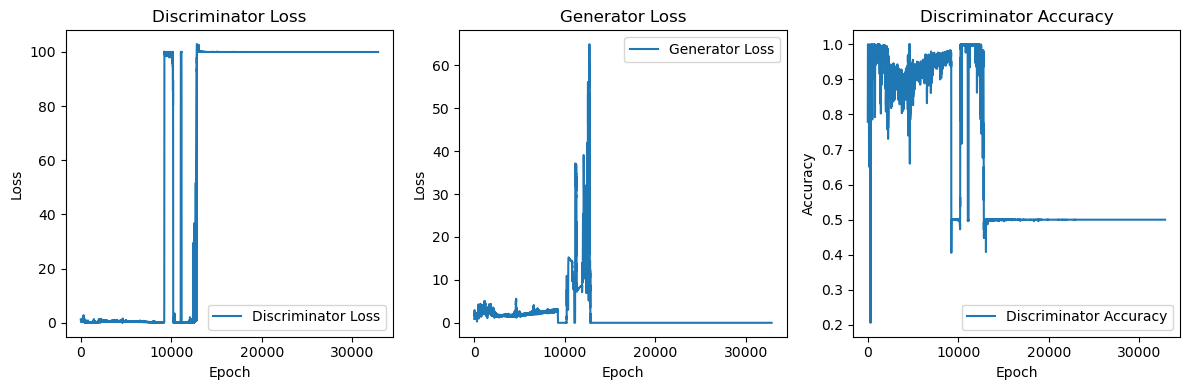

In [68]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(g_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(d_accuracies, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
# Platting the values again

In [70]:
# Now we can calculate the averages and plot the values as previously done
# Calculate average values per epoch
avg_real_accuracies = []
avg_fake_accuracies = []
avg_d_losses = []
avg_g_losses = []

In [71]:
# Helper function for averaging
def calculate_average(values):
    return np.mean(values) if values else 0

current_epoch = 0
temp_real_acc = []
temp_fake_acc = []
temp_d_loss = []
temp_g_loss = []

In [72]:
for i in range(len(epochs)):
    if epochs[i] != current_epoch:
        # Calculate averages for the current epoch and reset lists
        avg_real_accuracies.append(calculate_average(temp_real_acc))
        avg_fake_accuracies.append(calculate_average(temp_fake_acc))
        avg_d_losses.append(calculate_average(temp_d_loss))
        avg_g_losses.append(calculate_average(temp_g_loss))

        temp_real_acc = []
        temp_fake_acc = []
        temp_d_loss = []
        temp_g_loss = []
        current_epoch = epochs[i]

    # Append current values
    temp_real_acc.append(real_accuracy_list[i])
    temp_fake_acc.append(fake_accuracy_list[i])
    temp_d_loss.append(d_losses[i])
    temp_g_loss.append(g_losses[i])

In [73]:
# Add averages for the last epoch
avg_real_accuracies.append(calculate_average(temp_real_acc))
avg_fake_accuracies.append(calculate_average(temp_fake_acc))
avg_d_losses.append(calculate_average(temp_d_loss))
avg_g_losses.append(calculate_average(temp_g_loss))

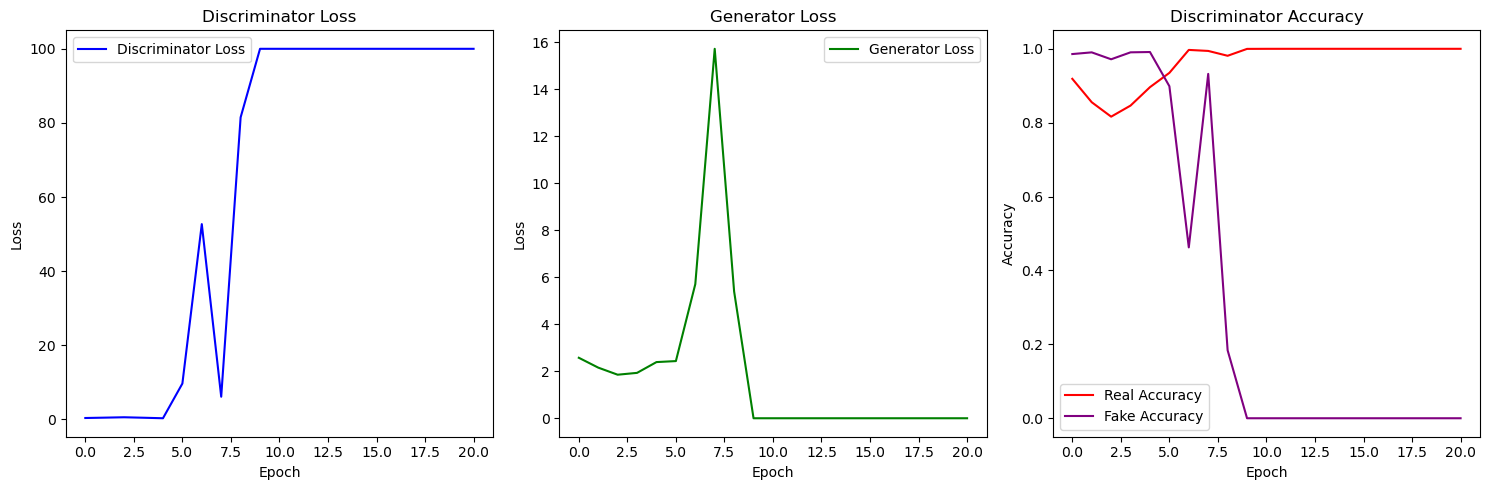

In [74]:
# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Plotting the graphs
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, avg_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, avg_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, avg_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, avg_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


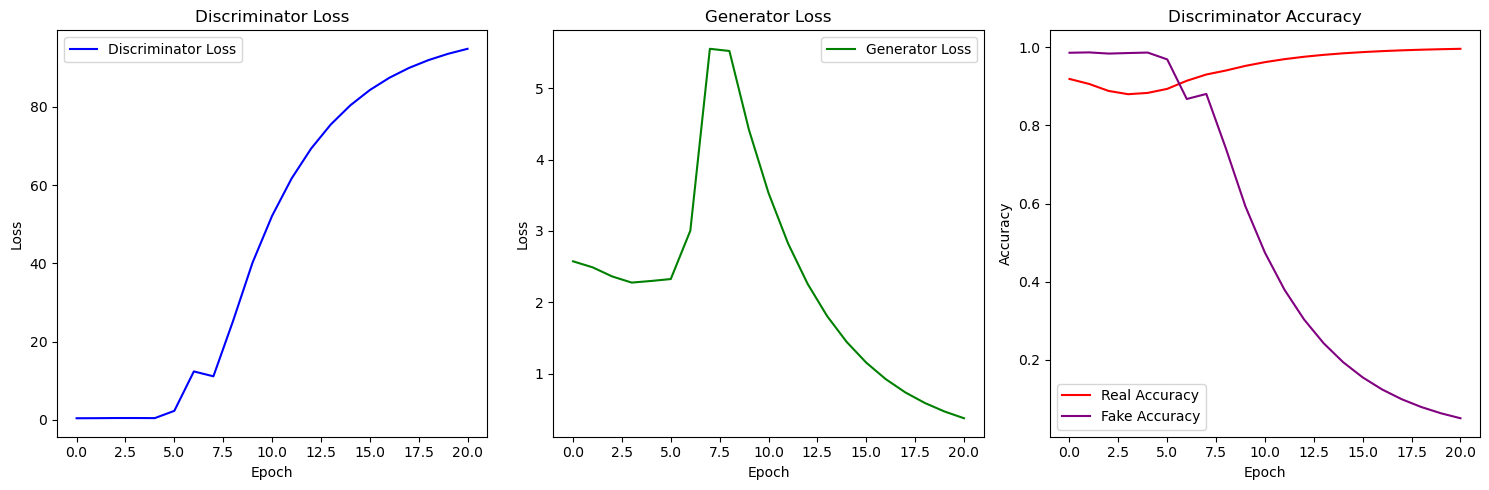

In [75]:
import matplotlib.pyplot as plt
import numpy as np


# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Smoothing the lines
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Applying smoothing
smoothed_d_losses = smooth_curve(avg_d_losses)
smoothed_g_losses = smooth_curve(avg_g_losses)
smoothed_real_accuracies = smooth_curve(avg_real_accuracies)
smoothed_fake_accuracies = smooth_curve(avg_fake_accuracies)

# Plotting the graphs with enhanced visualization
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, smoothed_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, smoothed_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, smoothed_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, smoothed_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


d_losses 32852
smoothed_d_losses1 32852


ValueError: x and y must have same first dimension, but have shapes (32823,) and (32852,)

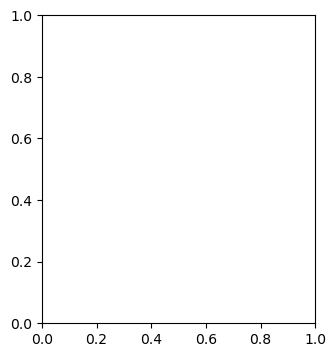

In [76]:
# Applying smoothing to these data as well
smoothed_d_losses1 = smooth_curve(d_losses)
smoothed_g_losses1 = smooth_curve(g_losses)
smoothed_d_accuracies1 = smooth_curve(d_accuracies)

print("d_losses", len(d_losses))
print("smoothed_d_losses1", len(smoothed_d_losses1))

# Enhanced plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, smoothed_d_losses1, label='Discriminator Loss', color='blue', marker='o')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, smoothed_g_losses1, label='Generator Loss', color='green', marker='o')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, smoothed_d_accuracies1, label='Discriminator Accuracy', color='red', marker='o')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (32823,) and (32852,)

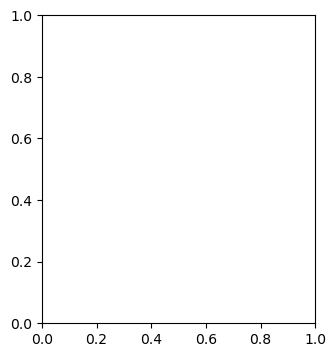

In [77]:
# Applying smoothing to these data as well
smoothed_d_losses1 = smooth_curve(d_losses)
smoothed_g_losses1 = smooth_curve(g_losses)
smoothed_d_accuracies1 = smooth_curve(d_accuracies)

# Enhanced plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, smoothed_d_losses1, label='Discriminator Loss', color='blue')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(epochs, smoothed_g_losses1, label='Generator Loss', color='green')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, smoothed_d_accuracies1, label='Discriminator Accuracy', color='red')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


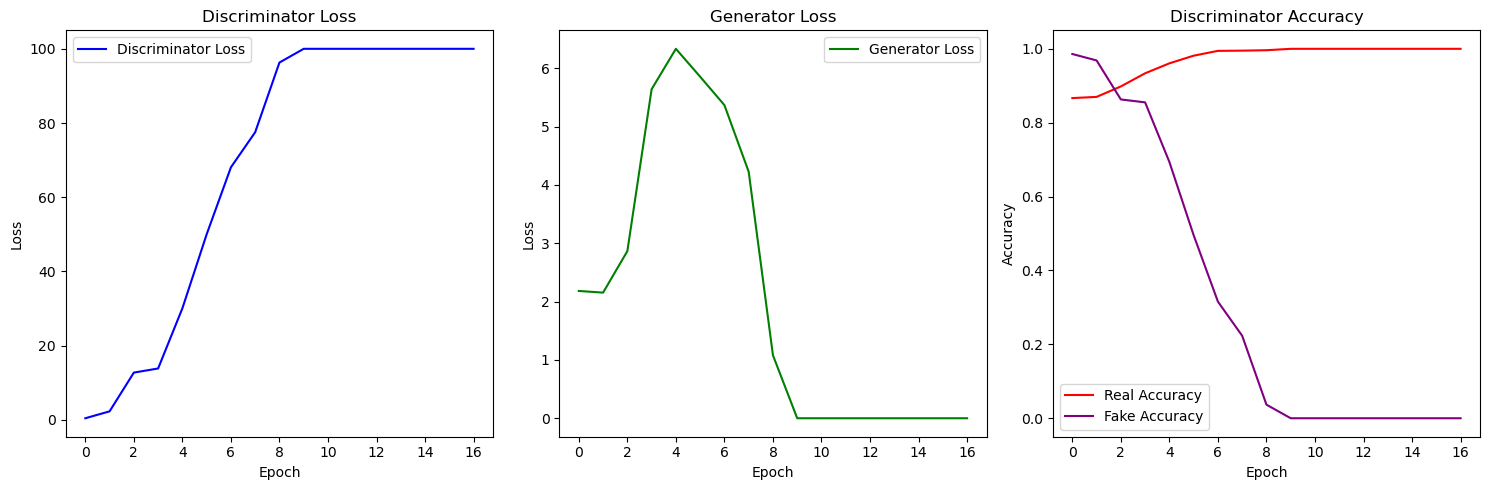

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))
window_size = 5

# Smoothing the lines with Simple Moving Average
def smooth_curve_SMA(points, window_size=5):
    window = np.ones(window_size) / window_size
    return np.convolve(points, window, 'valid')

# Applying SMA smoothing
smoothed_d_losses = smooth_curve_SMA(avg_d_losses)
smoothed_g_losses = smooth_curve_SMA(avg_g_losses)
smoothed_real_accuracies = smooth_curve_SMA(avg_real_accuracies)
smoothed_fake_accuracies = smooth_curve_SMA(avg_fake_accuracies)

# Adjusting 'unique_epochs' for the reduced size after convolution
adjusted_epochs = unique_epochs[:len(unique_epochs) - window_size + 1]

# Plotting the graphs with enhanced visualization
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(adjusted_epochs, smoothed_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(adjusted_epochs, smoothed_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(adjusted_epochs, smoothed_real_accuracies, label='Real Accuracy', color='red')
plt.plot(adjusted_epochs, smoothed_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [79]:
# Fake and real graph batch values comparision

In [80]:
import networkx as nx
import torch
from torch_geometric.utils import to_networkx

def calculate_graph_metrics(data_x, data_edge_index):
    # Convert to NetworkX graph
    data = Data(x=data_x, edge_index=data_edge_index)
    G = to_networkx(data, to_undirected=True)

    # Calculate metrics
    metrics = {
        'degree_distribution': [G.degree(n) for n in G.nodes()],
        'clustering_coefficients': nx.clustering(G),
        'graph_diameter': nx.diameter(G) if nx.is_connected(G) else float('inf'),
        'num_edges': G.number_of_edges(),
        'num_nodes': G.number_of_nodes(),
        'density': nx.density(G)
    }
    return metrics



In [81]:
# Example usage for a specific epoch
epoch_to_analyze = 49  # Change this to the epoch you want to analyze

real_graph_metrics = []
fake_graph_metrics = []

for graph_data in graph_data_per_epoch[epoch_to_analyze]:
    real_metrics = calculate_graph_metrics(graph_data['real_x'], graph_data['real_edge_index'])
    fake_metrics = calculate_graph_metrics(graph_data['fake_x'], graph_data['fake_edge_index'])

    real_graph_metrics.append(real_metrics)
    fake_graph_metrics.append(fake_metrics)

# Now real_graph_metrics and fake_graph_metrics contain the metrics for each graph in the specified epoch


In [82]:
print("real_graph_metrics",real_graph_metrics)
print("fake_graph_metrics",fake_graph_metrics)

real_graph_metrics [{'degree_distribution': [1, 3, 2, 2, 3, 2, 3, 1, 3, 2, 2, 2, 3, 2, 4, 1, 1, 1, 3, 3, 2, 2, 2, 1, 3, 2, 3, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 3, 2, 1, 2, 3, 2, 2, 2, 3, 3, 1, 1, 1, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 2, 1, 2, 3, 2, 2, 2, 2, 3, 1, 3, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 1, 2, 1, 3, 2, 1, 2, 4, 2, 1, 2, 3, 2, 2, 3, 2, 1, 3, 2, 3, 1, 2, 3, 3, 1, 2, 3, 2, 2, 2, 2, 2, 1, 2, 3, 1, 2, 3, 1, 3, 2, 3, 2, 3, 1, 2, 3, 2, 2, 3, 3, 1, 3, 2, 2, 2, 3, 3, 1, 2, 3, 2, 2, 3, 2, 3, 1, 3, 2, 2, 3, 1, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 1, 1, 3, 1, 2, 2, 3, 2, 2, 3, 3, 1, 2, 3, 2, 3, 1, 2, 2, 3, 1, 2, 1, 2, 2, 2, 3, 1, 3, 1, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 1, 1, 2, 1, 4, 1, 2, 3, 2, 3, 1, 3, 2, 2, 2, 2, 3, 2, 2, 3, 4, 1, 1, 2, 3, 2, 2, 2, 2, 3, 1, 2, 3, 1, 2, 4, 2, 1, 3, 1, 1, 3, 1, 2, 3, 2, 3, 1, 1, 3, 3, 2, 2, 3, 1, 1, 2, 3, 2, 2, 2, 2, 3, 1, 3, 3, 3, 1, 3, 2, 2, 2, 4, 1, 3, 1, 1, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 1, 3, 2, 2, 3, 3, 1

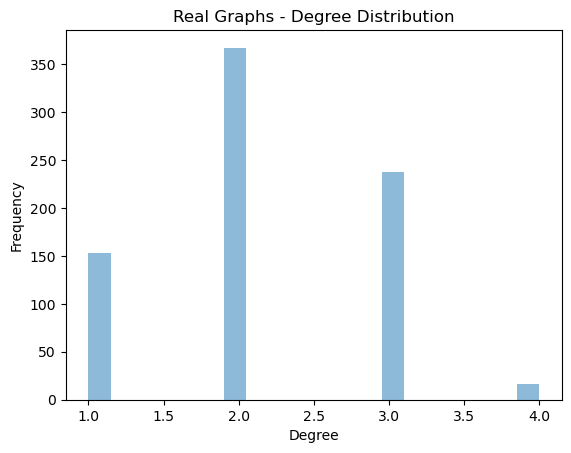

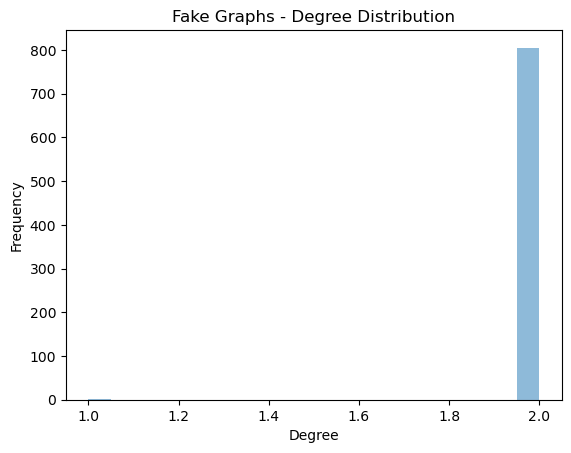

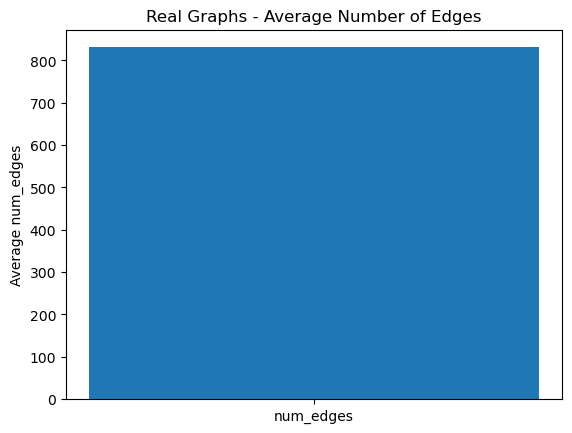

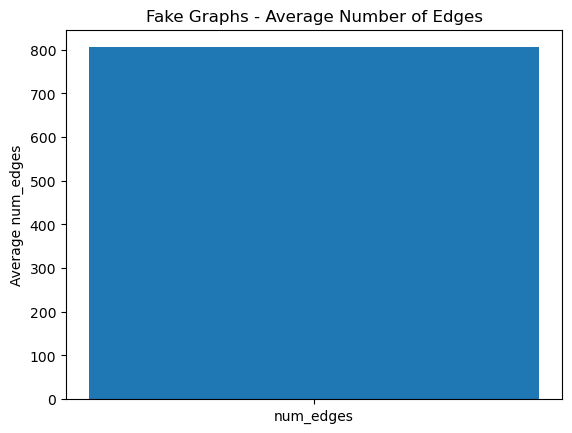

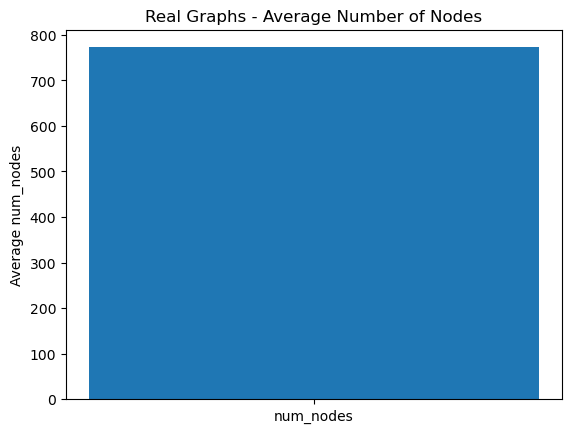

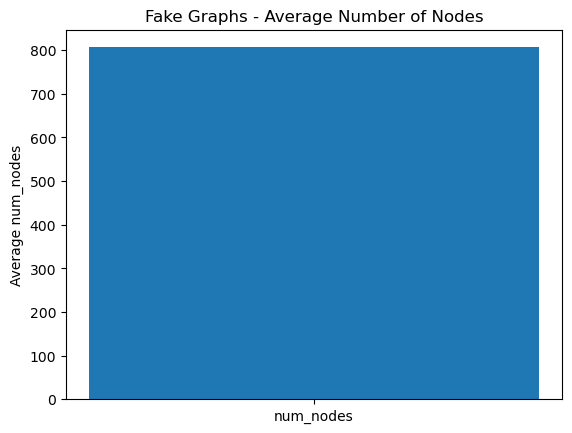

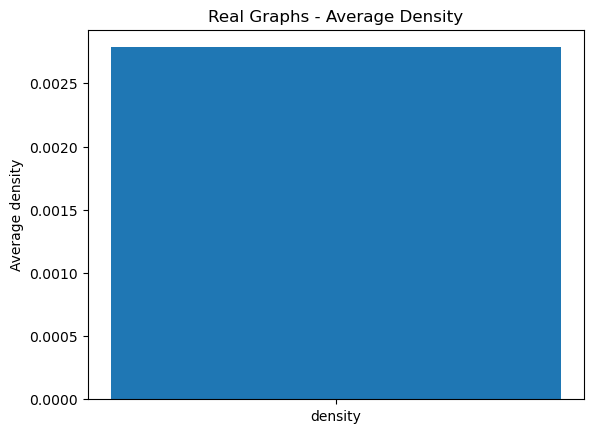

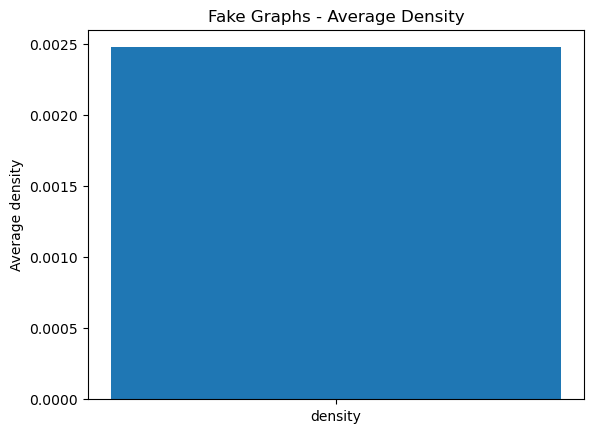

In [83]:
import matplotlib.pyplot as plt

def plot_degree_distribution(graph_metrics_list, title):
    all_degrees = [degree for metrics in graph_metrics_list for degree in metrics['degree_distribution']]
    plt.hist(all_degrees, bins=20, alpha=0.5)
    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

def plot_average_metric(graph_metrics_list, metric_name, title):
    average_metric = sum(metrics[metric_name] for metrics in graph_metrics_list) / len(graph_metrics_list)
    plt.bar(metric_name, average_metric)
    plt.title(title)
    plt.ylabel('Average ' + metric_name)
    plt.show()

# Plot degree distribution
plot_degree_distribution(real_graph_metrics, 'Real Graphs - Degree Distribution')
plot_degree_distribution(fake_graph_metrics, 'Fake Graphs - Degree Distribution')

# Plot other metrics
# Note: Adjust the metric names and titles based on your metrics dictionary keys
plot_average_metric(real_graph_metrics, 'num_edges', 'Real Graphs - Average Number of Edges')
plot_average_metric(fake_graph_metrics, 'num_edges', 'Fake Graphs - Average Number of Edges')

plot_average_metric(real_graph_metrics, 'num_nodes', 'Real Graphs - Average Number of Nodes')
plot_average_metric(fake_graph_metrics, 'num_nodes', 'Fake Graphs - Average Number of Nodes')

plot_average_metric(real_graph_metrics, 'density', 'Real Graphs - Average Density')
plot_average_metric(fake_graph_metrics, 'density', 'Fake Graphs - Average Density')

# Repeat for other metrics as desired


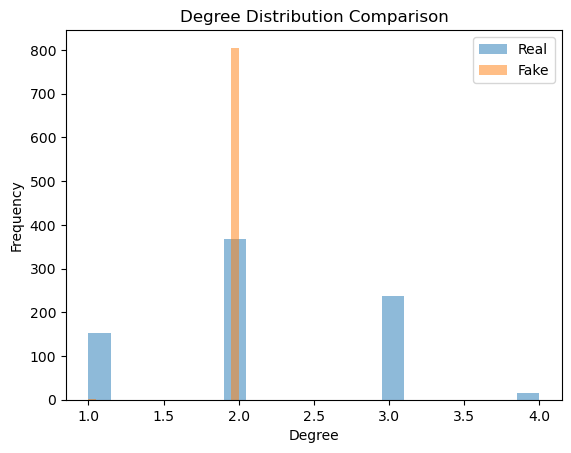

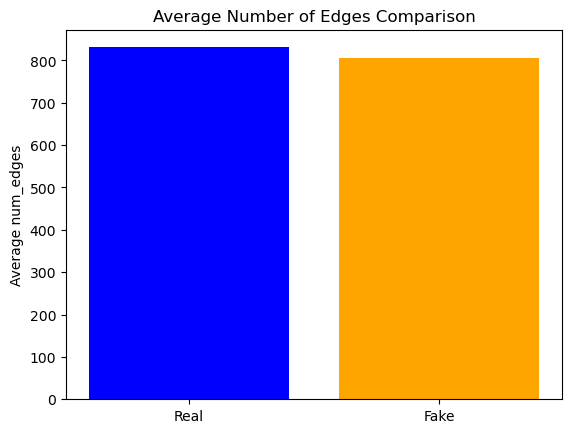

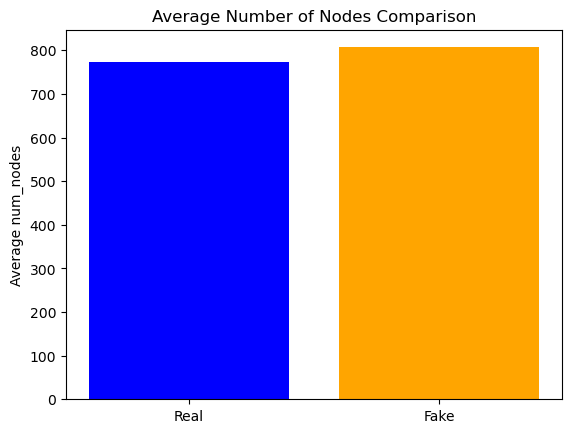

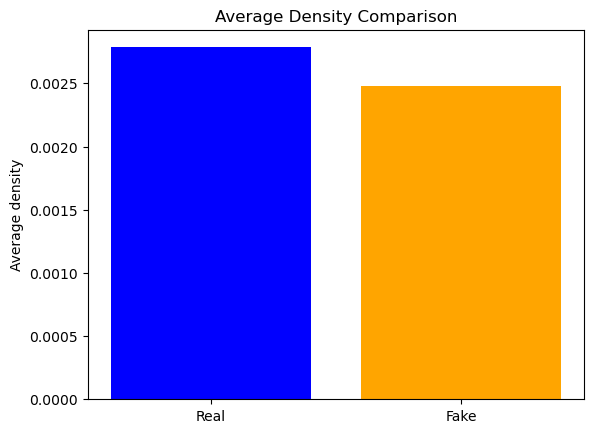

In [84]:
def plot_degree_distribution_comparison(real_graph_metrics, fake_graph_metrics, title):
    # Collect all degrees for real and fake graphs
    real_degrees = [degree for metrics in real_graph_metrics for degree in metrics['degree_distribution']]
    fake_degrees = [degree for metrics in fake_graph_metrics for degree in metrics['degree_distribution']]

    # Plot histograms
    plt.hist(real_degrees, bins=20, alpha=0.5, label='Real')
    plt.hist(fake_degrees, bins=20, alpha=0.5, label='Fake')
    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_average_metric_comparison(real_graph_metrics, fake_graph_metrics, metric_name, title):
    # Calculate average metrics
    avg_real_metric = sum(metrics[metric_name] for metrics in real_graph_metrics) / len(real_graph_metrics)
    avg_fake_metric = sum(metrics[metric_name] for metrics in fake_graph_metrics) / len(fake_graph_metrics)

    # Plot grouped bar chart
    labels = ['Real', 'Fake']
    values = [avg_real_metric, avg_fake_metric]

    plt.bar(labels, values, color=['blue', 'orange'])
    plt.title(title)
    plt.ylabel('Average ' + metric_name)
    plt.show()

# Plot degree distribution comparison
plot_degree_distribution_comparison(real_graph_metrics, fake_graph_metrics, 'Degree Distribution Comparison')

# Plot other metric comparisons
# Adjust the metric names based on your metrics dictionary keys
plot_average_metric_comparison(real_graph_metrics, fake_graph_metrics, 'num_edges', 'Average Number of Edges Comparison')
plot_average_metric_comparison(real_graph_metrics, fake_graph_metrics, 'num_nodes', 'Average Number of Nodes Comparison')
plot_average_metric_comparison(real_graph_metrics, fake_graph_metrics, 'density', 'Average Density Comparison')



In [ ]:
#The `nx.density(G)` function in NetworkX calculates the density of a graph `G`. Graph density provides a measure of how many edges are in the graph compared to the maximum possible number of edges between nodes.

#The density is calculated using the formula:

#\[ \text{Density} = \frac{2 \times \text{Number of Edges}}{\text{Number of Nodes} \times (\text{Number of Nodes} - 1)} \]

#For undirected graphs, this formula considers each edge between two nodes as a single edge. For directed graphs, where edges have a direction, the formula is usually adjusted to:

#\[ \text{Density} = \frac{\text{Number of Edges}}{\text{Number of Nodes} \times (\text{Number of Nodes} - 1)} \]

### Interpretation:

#1. **Range**: The density of a graph ranges from 0 to 1. 
#   - A density of 0 means there are no edges in the graph.
#   - A density of 1 indicates a complete graph, where every node is connected to every other node.

#2. **Sparse vs. Dense Graphs**:
#   - **Sparse Graphs**: Graphs with low density have relatively few edges compared to the number of possible edges. Sparse graphs are common in real-world networks where not all nodes are interconnected.
#   - **Dense Graphs**: Graphs with high density are closer to complete graphs. They have many edges, and most pairs of nodes are directly connected by an edge.

#3. **Application**: 
#   - Graph density is a simple yet informative measure that gives an idea of the connectivity of the graph. 
#   - It is used in various applications like social network analysis, biology, transportation networks, etc., to understand the underlying structure and connectivity of the network.

#4. **Limitations**:
#   - While density gives a quick overview of how connected a graph is, it does not provide detailed information about the graph's topology, such as clusters, central nodes, or other structural properties.

#Graph density is particularly useful when comparing different graphs to understand their relative connectivity or when characterizing a single graph's overall connectivity level.

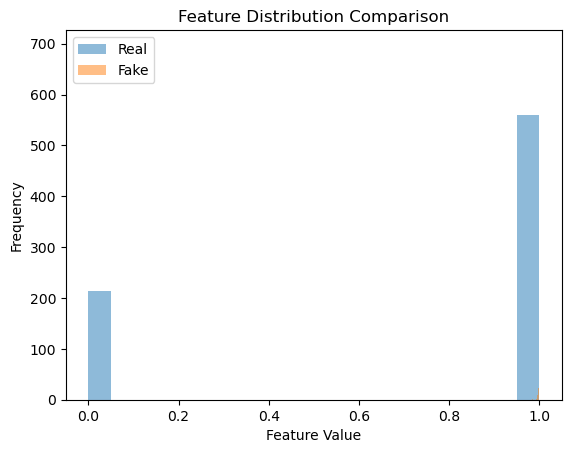

In [85]:
def plot_feature_distribution(graph_data, feature_index, title):
    # Extract the features from all nodes in all graph data
    real_features = torch.cat([g['real_x'][:, feature_index] for g in graph_data], dim=0)
    fake_features = torch.cat([g['fake_x'][:, feature_index] for g in graph_data], dim=0)

    # Plot histograms
    plt.hist(real_features.numpy(), bins=20, alpha=0.5, label='Real')
    plt.hist(fake_features.numpy(), bins=20, alpha=0.5, label='Fake')
    plt.title(title)
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

epoch_to_analyze = max(graph_data_per_epoch.keys())  # Analyze the last epoch
plot_feature_distribution(graph_data_per_epoch[epoch_to_analyze], 0, 'Feature Distribution Comparison')


In [86]:
def calculate_simple_similarity(G1, G2):
    # Simplified similarity measure based on node degrees
    degrees1 = sorted([d for n, d in G1.degree()])
    degrees2 = sorted([d for n, d in G2.degree()])
    return sum((d1 - d2)**2 for d1, d2 in zip(degrees1, degrees2))**0.5

def compare_graph_similarity(graph_data):
    similarities = []
    for data in graph_data:
        real_g_nx = to_networkx(Data(x=data['real_x'], edge_index=data['real_edge_index']), to_undirected=True)
        fake_g_nx = to_networkx(Data(x=data['fake_x'], edge_index=data['fake_edge_index']), to_undirected=True)
        similarity = calculate_simple_similarity(real_g_nx, fake_g_nx)
        similarities.append(similarity)
    return similarities

# Compare similarities
similarities = compare_graph_similarity(graph_data_per_epoch[epoch_to_analyze])
print("Graph Similarities:", similarities)


Graph Similarities: [21.2602916254693]


In [87]:
#The values `[19.183326093250876, 9.899494936611665]` from the graph similarity function indicate the degree of dissimilarity between pairs of real and fake graphs based on the simplified similarity measure you've used. This measure primarily focuses on the degree distribution of the graphs, and the values are computed as the root mean square difference in degrees between corresponding nodes of real and fake graphs.

#Here's how to interpret these values:

#1. **Numerical Interpretation**:
#   - A value of `19.183326093250876` for the first graph pair means that, on average, the square root of the sum of squared differences in degrees between corresponding nodes of the real and fake graphs is about 19.18. 
#   - Similarly, a value of `9.899494936611665` for the second graph pair indicates an average square root of the sum of squared degree differences of approximately 9.90.

#2. **Qualitative Interpretation**:
#   - Lower values (closer to 0) suggest that the fake graph has a node degree distribution more similar to that of the real graph. In other words, nodes in the fake graph tend to have a number of connections similar to their counterparts in the real graph.
#   - Higher values indicate greater differences in the node degree distributions between the real and fake graphs. A larger value suggests that the structure of the fake graph differs more significantly from the real graph.

#3. **Contextual Understanding**:
#   - In the context of your GAN model, these values can be used to assess the model's performance in replicating the structural properties of the real graphs. A well-trained generator should ideally produce fake graphs that closely mimic the structural characteristics of the real graphs, resulting in lower similarity scores.
#   - The values you provided show that the first pair of graphs has a higher dissimilarity compared to the second pair. This could imply that the generator is better at replicating the structure of some graphs than others, or it might indicate that certain real graphs are easier to mimic.

#4. **Limitations**:
#   - It's important to remember that this is a simplified approach to measuring graph similarity. It does not account for the arrangement of edges, specific attributes of nodes or edges, or more complex graph structures. Depending on the complexity and requirements of your application, you might need to use more advanced metrics for a comprehensive analysis.

#In summary, these values give you a basic quantitative assessment of how well the generated (fake) graphs are mimicking the structural properties of the real graphs, specifically in terms of node connectivity. Lower values are generally better, indicating closer structural resemblance.

In [ ]:
#The graph similarity measure calculated by `compare_graph_similarity` function aims to provide a quantitative assessment of how similar each fake graph is to its corresponding real graph. This comparison is based on a simplified similarity measure that primarily focuses on the degree distribution of the graphs.

### Understanding the Graph Similarity Measure:

#1. **Degree Distribution Based**: The measure calculates the similarity between two graphs by comparing the degree of each node in one graph to the degree of the corresponding node in the other graph. The degree of a node is the number of connections (edges) it has to other nodes.

#2. **Root Mean Square Difference**: The function computes the root mean square difference in degrees between nodes of the two graphs. This provides a single scalar value that represents the 'distance' or dissimilarity between the two graphs. A lower value indicates more similarity in terms of how nodes are connected.

#3. **Limitations**: This is a very simplified approach to measuring graph similarity. Real-world graphs, especially complex networks, may have a wide range of properties and structures that this measure does not capture. For instance, it does not consider the actual arrangement of edges, any specific attributes of nodes or edges, or more complex structures like subgraphs or motifs.

### Interpretation:

#- **Low Values**: Indicate that the fake graph has a node degree distribution similar to that of the real graph. In other words, nodes in the fake graph have a similar number of connections as their counterparts in the real graph.

#- **High Values**: Suggest significant differences in the way nodes are connected in the fake graph compared to the real graph.

### Application:

#In the context of your GAN model, these similarity values can be used to gauge how well the generator is performing in terms of replicating the structural characteristics of the real graphs. Ideally, a well-trained generator should produce fake graphs that have similar structural properties to the real graphs, resulting in lower similarity scores.

#However, it's important to remember that this is just one aspect of graph similarity. Depending on your specific use case (like chemical structure generation, social network modeling, etc.), you may need more sophisticated metrics that can account for the full complexity of the graphs you're working with.

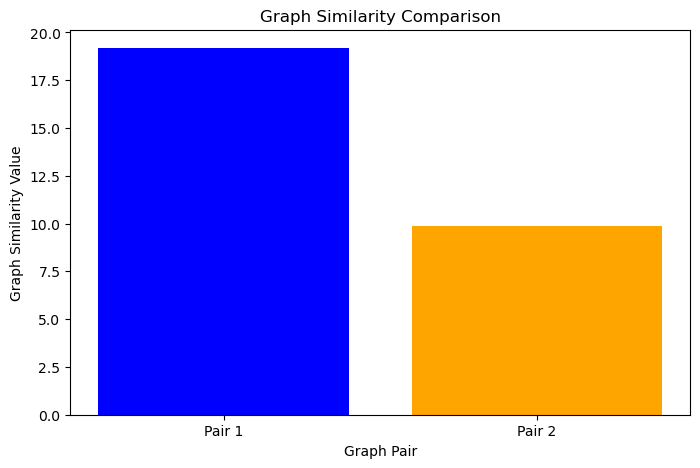

In [88]:
import matplotlib.pyplot as plt

# Graph similarity values
similarities = [19.183326093250876, 9.899494936611665]

# Create a bar chart
plt.figure(figsize=(8, 5))  # Adjust the size of the plot as needed
plt.bar(range(len(similarities)), similarities, color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Graph Pair')
plt.ylabel('Graph Similarity Value')
plt.title('Graph Similarity Comparison')
plt.xticks(range(len(similarities)), ['Pair 1', 'Pair 2'])  # Label each bar

# Show the plot
plt.show()
